<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Allianz/Allianz_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ALV.DE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   77.01   77.74   75.20   77.15      44.08  1424010
2009-01-05   77.60   77.70   75.75   76.93      43.96  1598972
2009-01-06   76.23   76.50   72.23   73.20      41.83  3403388
2009-01-07   72.00   72.67   70.12   70.50      40.29  2934935
2009-01-08   69.50   69.60   62.50   66.67      38.10  7435818
...            ...     ...     ...     ...        ...      ...
2018-12-19  175.60  177.20  174.68  175.94     168.36  1326802
2018-12-20  173.20  175.82  172.86  174.96     167.43  1599316
2018-12-21  174.60  175.22  173.70  175.02     167.48  3334380
2018-12-27  174.68  174.78  170.46  172.16     164.75  1214929
2018-12-28  172.80  175.92  172.48  175.14     167.60   792046

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean    123.166526   124.302414   121.922410   123.128429    96.452513  2.033890e+06
std      39.653474    39.668434    39.603965    39.631015    44.819951  1.220989e+06
min      49.000000    49.130000    46.680000    48.680000    27.820000  0.000000e+00
25%      87.460000    88.160000    86.610000    87.345000    55.825000  1.277554e+06
50%     122.150000   123.050000   121.250000   122.050000    89.590000  1.729896e+06
75%     152.975000   154.425000   151.125000   152.575000   123.005000  2.403179e+06
max     206.200000   206.850000   204.950000   205.750000   189.000000  1.812590e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   56.85   58.10   56.09   56.39      32.22  4303892   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   53.661104   54.261448   47.041152   54.323984   53.626537   51.938385      52.535       52.39   48.080832   52.57500   56.003523   51.9155   53.496667   52.57500   55.366667   53.911181               58.464983                 52.57500               46.685017               61.409975                 52.57500               43.740025               64.354966                 52.57500               40.795034               67.299958                 52.57500               37.850042   53.626537   55.229524   53.333710               59.516520                53.626537               47.736554               62.461512                53.626537               44.791562               65.406503                53.626537               41.846571               68.351495   
2009-03-16   57.21   59.90   57.21   58.45      33.40  3553530   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   53.900549   54.252425   47.483506   56.074562   54.698418   52.256345      53.565       53.29   48.882365   53.07875   57.908745   53.0845   54.802222   53.07875   57.420000   53.780313               60.095348                 53.07875               46.062152               63.603647                 53.07875               42.553853               67.111945                 53.07875               39.045555               70.620244                 53.07875               35.537256   54.698418   57.573124   53.308578               61.715015                54.698418               47.681820               65.223314                54.698418               44.173521               68.731613                54.698418               40.665222               72.239912   
2009-03-17   58.16   61.66   57.25   59.90      34.23  4272399

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean    124.386360   125.512865   123.164813   124.357509    97.679020  2.000422e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020   124.256469   123.904027     4.728816   124.359791   124.185588   124.233620   124.103845   123.963783   123.434194   124.186168   124.358940   124.186688   124.243951   124.186168   124.323149   123.836332              127.778966               124.186168              120.593370              129.575365               124.186168              118.796971              131.371764               124.186168              117.000572              133.168163               124.186168              115.204173   124.185588   124.322206   123.888877              127.778387               124.185588              120.592790              129.574786               124.185588              118.796391              131.371185   
std      39.078636    39.109081    38.991227    39.040991    44.411407  1.193359e+06     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    39.049682    39.089857   129.870240    39.063000    39.006244    39.177756    39.038652    38.981301    39.068916    39.033192    39.050284    39.044794    39.025505    39.033192    39.044871    39.014789               39.327227                39.033192               38.845071               39.513256                39.033192               38.791244               39.724823                39.033192               38.764406               39.961522                39.033192               38.764613    39.006244    39.031473    39.020616               39.300991                39.006244               38.817475               39.487399                39.006244               38.763350               39.699356   
min      56.850000    58.100000    56.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.000000  0.000000  0.000000  0.000000   0.000000  4303892   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000061  0.621586  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000879                0.000000                 0.000000                0.003964                0.000000                 0.000000                0.007418                0.000000                 0.000000                0.010753                0.000000                 0.000000                0.013976  0.000000  0.000000  0.000168                0.000000                 0.000000                0.000354                0.000000                 0.000000                0.003922                0.000000                 0.000000                0.007367                0.000000                 0.000000   
2009-03-16  0.002410  0.012101  0.007524  0.013792   0.007526  3553530   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.001587  0.000000  0.622669  0.011559  0.007129  0.002079    0.006767    0.005910  0.005048  0.003313  0.012695  0.007646  0.008642  0.003313  0.013678  0.000000                0.010803                 0.003313                0.000000                0.014376                 0.003313                0.000000                0.017689                 0.003313                0.000000                0.020866                 0.003313                0.000000  0.007129  0.015625  0.000000                0.014824                 0.007129                0.000000                0.018428                 0.007129                0.000000                0.021714                 0.007129                0.000000                0.024863                 0.007129   
2009-03-17  0.008771  0.023933  0.007793  0.023500  

140034

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpim_n6lvm
  JVM stdout: /tmp/tmpim_n6lvm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpim_n6lvm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_wxq0yp
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.526348  14.145381              0.466522  0.665226  0.442525
1  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.519931  14.008077              0.466522  0.663459  0.440178
2  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.507065   0.690496              0.500000  0.498675  0.248677
3              DeepLearning_1_AutoML_20190828_115737  0.500000  16.090354              0.500000  0.682542  0.465863
4  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.500000  16.090354              0.500000  0.682542  0.465863
5  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.500000  16.090354              0.500000  0.682542  0.465863
6  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.500000   0.692366              0.500000  0.499602  0.249602
7  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.496856  15.979650              0.495690  0.682536  0.465856
8  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.496856  15.974052              0.495690  0.682520  0.465833
9  DeepLearning_grid_1_AutoML_20190828_115737_mod...  0.493129  15.951789              0.495690  0.679630  0.461898

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.002233
1                 STOCHF_fastk             0.730306           0.730306    0.001631
2               STOCHRSI_fastk             0.657729           0.657729    0.001469
3                      WILLR_8             0.637646           0.637646    0.001424
4                     WILLR_12             0.576991           0.576991    0.001289
...                        ...                  ...                ...         ...
1036   BBANDS_upperband_30_1_4             0.389608           0.389608    0.000870
1037                   MA_20_3             0.387161           0.387161    0.000865
1038   BBANDS_upperband_20_5_3             0.387038           0.387038    0.000864
1039  BBANDS_middleband_20_3_5             0.385557           0.385557    0.000861
1040    BBANDS_upperband_8_4_2             0.385403           0.385403    0.000861

[1041 rows x 4 columns]

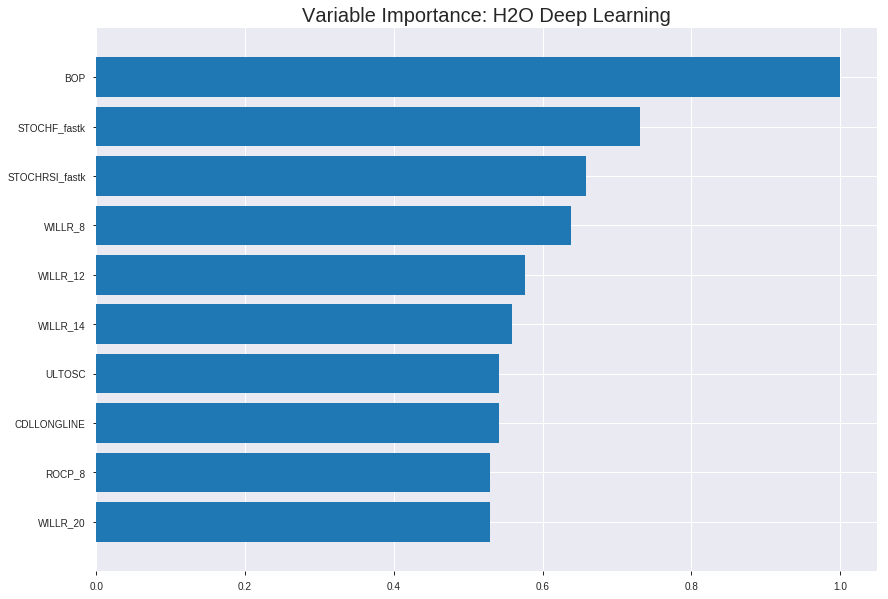

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_115737_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24475775570707078
RMSE: 0.49472998262392665
LogLoss: 0.6825808009213541
Mean Per-Class Error: 0.42296303359210086
AUC: 0.592919252355261
pr_auc: 0.6261953481042734
Gini: 0.185838504710522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4065685517437796: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   792   0.967    (792.0/819.0)
1      5    917   0.0054   (5.0/922.0)
Total  32   1709  0.4578   (797.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406569     0.697073  382
max f2                       0.39624      0.851182  390
max f0point5                 0.441424     0.59721   321
max accuracy                 0.522322     0.570362  148
max precision                0.642976     1         0
max recall                   0.39624      1         390
max specificity              0.642976     1         0
max absolute_mcc             0.531827     0.16272   124
max min_per_class_accuracy   0.508803     0.563991  183
max mean_per_class_accuracy  0.522322     0.577037  148

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 50.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.588428           1.67848   1.67848            0.888889         0.614785  0.888889                    0.614785            0.0173536       0.0173536                  67.8477   67.8477
    2        0.0201034                   0.578471           1.11076   1.40273            0.588235         0.582706  0.742857                    0.599204            0.010846        0.0281996                  11.0757   40.2727
    3        0.0304423                   0.571571           1.57357   1.46075            0.833333         0.574399  0.773585                    0.590779            0.016269        0.0444685                  57.3572   46.075
    4        0.0402068                   0.568605           1.55506   1.48365            0.823529         0.570215  0.785714                    0.585785            0.0151844       0.0596529                  55.5059   48.3654
    5        0.0505457                   0.566024           1.25886   1.43767            0.666667         0.567211  0.761364                    0.581986            0.0130152       0.0726681                  25.8858   43.7673
    6        0.100517                    0.554787           1.30227   1.37036            0.689655         0.560099  0.725714                    0.571105            0.0650759       0.137744                   30.2266   37.0356
    7        0.150488                    0.548499           1.12863   1.29009            0.597701         0.551576  0.683206                    0.56462             0.0563991       0.194143                   12.8631   29.0089
    8        0.20046                     0.542975           1.17204   1.26066            0.62069          0.545624  0.667622                    0.559885            0.0585683       0.252711                   17.204    26.0661
    9        0.300402                    0.532474           1.16119   1.22757            0.614943         0.537741  0.650096                    0.552518            0.116052        0.368764                   16.1188   22.7567
    10       0.400345                    0.521174           1.02011   1.17578            0.54023          0.526999  0.622669                    0.546147            0.101952        0.470716                   2.01087   17.5777
    11       0.500287                    0.509025           0.911587  1.123              0.482759         0.514929  0.594719                    0.539911            0.0911063       0.561822                   -8.84135  12.2999
    12       0.60023                     0.494706           0.87903   1.08238            0.465517         0.502312  0.573206                    0.53365             0.0878525       0.649675                   -12.097   8.23766
    13       0.700172                    0.472116           0.857325  1.05025            0.454023         0.484299  0.556194                    0.526606            0.0856833       0.735358                   -14.2675  5.02528
    14       0.800115                    0.450895           0.987552  1.04242            0.522989         0.460083  0.552046                    0.518296            0.0986985       0.834056                   -1.2448   4.24208
    15       0.900057                    0.432692           0.900734  1.02669            0.477011         0.44202   0.543714                    0.509827            0.0900217       0.924078                   -9.92657  2.66879
    16       1                           0.384188           0.759655  1                  0.402299         0.416383  0.529581                    0.500488          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30317062642039194
RMSE: 0.5506093228600402
LogLoss: 4.261410424570193
Mean Per-Class Error: 0.45698142489936466
AUC: 0.5332945341675154
pr_auc: 0.4016968778629239
Gini: 0.06658906833503075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40027815305057934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    231  0.9747   (231.0/237.0)
1      3    258  0.0115   (3.0/261.0)
Total  9    489  0.4699   (234.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.400278     0.688      367
max f2                       0.390583     0.846304   376
max f0point5                 0.414813     0.582548   317
max accuracy                 0.464438     0.544177   140
max precision                0.464438     0.564885   140
max recall                   0.390583     1          376
max specificity              1            0.772152   0
max absolute_mcc             0.464438     0.0860545  140
max min_per_class_accuracy   0.466594     0.535865   128
max mean_per_class_accuracy  0.464438     0.543019   140

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 59.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.236948                    1                  1.06721   1.06721            0.559322         1         0.559322                    1                   0.252874        0.252874                   6.72122   6.72122
    2        0.301205                    0.549549           0.954023  1.04307            0.5              0.761426  0.546667                    0.949104            0.0613027       0.314176                   -4.5977   4.30651
    3        0.399598                    0.487373           1.05137   1.04511            0.55102          0.509734  0.547739                    0.840918            0.103448        0.417625                   5.13723   4.51106
    4        0.5                         0.466719           1.14483   1.06513            0.6              0.474632  0.558233                    0.767366            0.114943        0.532567                   14.4828   6.51341
    5        0.600402                    0.454265           1.03034   1.05932            0.54             0.460307  0.555184                    0.716019            0.103448        0.636015                   3.03448   5.93165
    6        0.698795                    0.438473           0.739855  1.01433            0.387755         0.447816  0.531609                    0.678254            0.0727969       0.708812                   -26.0145  1.43348
    7        0.799197                    0.424425           1.06851   1.02114            0.56             0.431784  0.535176                    0.647291            0.10728         0.816092                   6.85057   2.11402
    8        0.899598                    0.413043           0.877701  1.00513            0.46             0.418296  0.526786                    0.621733            0.0881226       0.904215                   -12.2299  0.513136
    9        1                           0.390583           0.954023  1                  0.5              0.404591  0.524096                    0.599932            0.0957854       1                          -4.5977   0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:18:12  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:18:13  6 min 14.262 sec   249 obs/sec       0.21884   1             381        0.592977         1.09533             -0.411425      0.522589        0.540209           1.04905          0.46008                          0.628134           6.73506               -0.581884        0.520054          0.552134             1.14483            0.475904
    2019-08-28 12:19:04  7 min  5.056 sec   229 obs/sec       6.26766   28            10912      0.49473          0.682581            0.0175303      0.592919        0.626195           1.67848          0.457783                         0.550609           4.26141               -0.215506        0.533295          0.401697             1.06721            0.46988
    2019-08-28 12:19:53  7 min 54.365 sec   243 obs/sec       12.8782   58            22421      0.490669         0.674256            0.033594       0.625956        0.654781           1.67848          0.457209                         0.573984           5.34112               -0.3209          0.531549          0.576671             1.90805            0.475904
    2019-08-28 12:20:42  8 min 43.502 sec   250 obs/sec       19.5813   88            34091      0.478702         0.648659            0.0801577      0.706558        0.719212           1.88829          0.364733                         0.561588           4.71325               -0.264459        0.579457          0.404531             1.05676            0.435743
    2019-08-28 12:21:33  9 min 34.080 sec   254 obs/sec       26.5652   119           46250      0.461052         0.613089            0.146737       0.738429        0.746268           1.88829          0.35382                          0.560522           5.32903               -0.259663        0.585795          0.390745             1.03956            0.407631
    2019-08-28 12:22:23  10 min 23.667 sec  254 obs/sec       33.1057   148           57637      0.45558          0.603114            0.166871       0.762743        0.766847           1.88829          0.317634                         0.558845           5.79649               -0.252139        0.603165          0.387181             1.05187            0.369478
    2019-08-28 12:23:13  11 min 13.900 sec  257 obs/sec       40.1689   180           69934      0.456478         0.604555            0.163585       0.760339        0.767942           1.88829          0.309592                         0.56083            5.78893               -0.261049        0.596473          0.384718             1.04635            0.413655
    2019-08-28 12:23:18  11 min 18.933 sec  257 obs/sec       40.1689   180           69934      0.49473          0.682581            0.0175303      0.592919        0.626195           1.67848          0.457783                         0.550609           4.26141               -0.215506        0.533295          0.401697             1.06721            0.46988

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0022332107217952735
STOCHF_fastk              0.730306088924408      0.730306088924408    0.0016309273879783603
STOCHRSI_fastk            0.6577292680740356     0.6577292680740356   0.001468848053501494
WILLR_8                   0.6376463770866394     0.6376463770866394   0.0014239987260237952
WILLR_12                  0.5769907832145691     0.5769907832145691   0.001288542003451828
---                       ---                    ---                  ---
BBANDS_upperband_30_1_4   0.38960757851600647    0.38960757851600647  0.0008700758216346396
MA_20_3                   0.38716092705726624    0.38716092705726624  0.0008646119333644848
BBANDS_upperband_20_5_3   0.38703757524490356    0.38703757524490356  0.0008643364627745636
BBANDS_middleband_20_3_5  0.38555672764778137    0.38555672764778137  0.0008610294180433256
BBANDS_upperband_8_4_2    0.3854031264781952     0.3854031264781952   0.0008606863942645254


See the whole table with table.as_data_frame()


('accuracy', 0.5622489959839357)

('F1', 0.6997245179063362)

('auc', 0.5263481980814104)

('logloss', 14.14538100745393)

('mean_per_class_error', 0.4665219082188229)

('rmse', 0.6652258754491555)

('mse', 0.44252546536709525)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


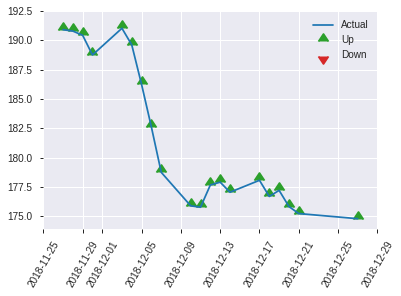


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.44252546536709525
RMSE: 0.6652258754491555
LogLoss: 14.14538100745393
Mean Per-Class Error: 0.4665219082188229
AUC: 0.5263481980814104
pr_auc: 0.040524339283490446
Gini: 0.05269639616282085
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8757514874433331: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   103  0.8879   (103.0/116.0)
1      6    127  0.0451   (6.0/133.0)
Total  19   230  0.4378   (109.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.875751     0.699725  6
max f2                       0.451073     0.851472  25
max f0point5                 0.875751     0.603039  6
max accuracy                 0.875751     0.562249  6
max precision                0.875751     0.552174  6
max recall                   0.451073     1         25
max specificity              1            0.12931   0
max absolute_mcc             0.875751     0.125807  6
max min_per_class_accuracy   1            0.12931   0
max mean_per_class_accuracy  0.875751     0.533478  6

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 96.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.875502                    1                  1.01338   1.01338            0.541284         1         0.541284                    1                   0.887218        0.887218                   1.33821   1.33821
    2        0.899598                    0.999999           1.56015   1.02803            0.833333         1         0.549107                    1                   0.037594        0.924812                   56.015    2.80277
    3        1                           0.451073           0.748872  1                  0.4              0.684963  0.534137                    0.96837             0.075188        1                          -25.1128  0

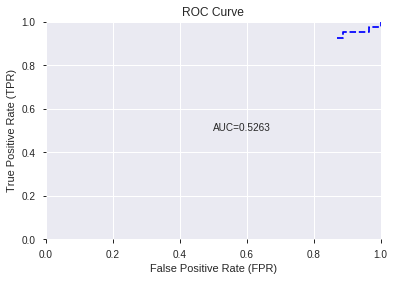

This function is available for GLM models only


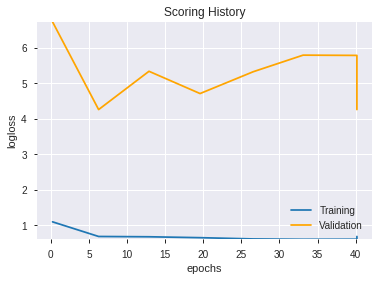

--2019-08-28 12:23:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.6MB/s    in 23s     

2019-08-28 12:23:56 (15.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_115737_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_115737_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_122409_model_8  0.733990  0.613179              0.306845  0.459595  0.211227
1  DeepLearning_grid_1_AutoML_20190828_122409_model_6  0.726666  0.603938              0.317118  0.455832  0.207783
2               DeepLearning_1_AutoML_20190828_122409  0.720897  0.623219              0.307396  0.462685  0.214077
3  DeepLearning_grid_1_AutoML_20190828_122409_model_9  0.718369  0.605429              0.308498  0.456418  0.208317
4  DeepLearning_grid_1_AutoML_20190828_122409_model_4  0.712989  0.724121              0.356560  0.482431  0.232740
5  DeepLearning_grid_1_AutoML_20190828_122409_model_5  0.705082  0.619786              0.340874  0.464026  0.215320
6  DeepLearning_grid_1_AutoML_20190828_122409_model_3  0.700998  0.709794              0.338216  0.487614  0.237767
7  DeepLearning_grid_1_AutoML_20190828_122409_model_7  0.699183  0.744453              0.337568  0.507520  0.257577
8  DeepLearning_grid_1_AutoML_20190828_122409_model_2  0.661136  0.764755              0.375356  0.504496  0.254516
9  DeepLearning_grid_1_AutoML_20190828_122409_model_1  0.622245  0.951586              0.495690  0.542236  0.294020

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.046482
1                  SUB             0.846495           0.846495    0.039347
2   CDLCLOSINGMARUBOZU             0.661421           0.661421    0.030744
3    CDLLONGLEGGEDDOJI             0.627864           0.627864    0.029185
4            STDDEV_20             0.600394           0.600394    0.027908
5              CDLDOJI             0.599575           0.599575    0.027870
6              quarter             0.572413           0.572413    0.026607
7               ULTOSC             0.571590           0.571590    0.026569
8         aroondown_30             0.532235           0.532235    0.024739
9                ADOSC             0.519854           0.519854    0.024164
10             BETA_20             0.501862           0.501862    0.023328
11             weekday             0.494951           0.494951    0.023006
12        STOCHF_fastk             0.474005           0.474005    0.022033
13        aroondown_14             0.472606           0.472606    0.021968
14              SAREXT             0.472547           0.472547    0.021965
15      STOCHRSI_fastd             0.470615           0.470615    0.021875
16               CCI_8             0.451523           0.451523    0.020988
17          aroonup_30             0.440089           0.440089    0.020456
18        STOCHF_fastd             0.427243           0.427243    0.019859
19          ROCR100_12             0.410106           0.410106    0.019063
20   MACDFIX_signal_24             0.403896           0.403896    0.018774
21      STOCHRSI_fastk             0.400783           0.400783    0.018629
22             ROCP_12             0.390780           0.390780    0.018164
23   LINEARREG_SLOPE_8             0.378266           0.378266    0.017583
24         CDLBELTHOLD             0.374154           0.374154    0.017392
25             ROCR_12             0.369345           0.369345    0.017168
26         CDLLONGLINE             0.369204           0.369204    0.017161
27              MOM_14             0.368781           0.368781    0.017142
28            WILLR_20             0.366874           0.366874    0.017053
29   MACDFIX_signal_14             0.366664           0.366664    0.017043
30              MOM_12             0.363184           0.363184    0.016882
31          MACDFIX_12             0.359314           0.359314    0.016702
32            WILLR_12             0.354337           0.354337    0.016470
33          ROCR100_14             0.350022           0.350022    0.016270
34            WILLR_24             0.347971           0.347971    0.016174
35            WILLR_14             0.347368           0.347368    0.016146
36         MACD_signal             0.346138           0.346138    0.016089
37              ROC_14             0.335007           0.335007    0.015572
38               MOM_8             0.331632           0.331632    0.015415
39              ROCP_8             0.330054           0.330054    0.015342
40              CMO_20             0.328107           0.328107    0.015251
41             WILLR_8             0.324114           0.324114    0.015066
42            WILLR_30             0.323470           0.323470    0.015036
43               ROC_8             0.316829           0.316829    0.014727
44              ROCR_8             0.313402           0.313402    0.014568
45           ROCR100_8             0.310093           0.310093    0.014414
46              RSI_14             0.304842           0.304842    0.014170
47               RSI_8             0.303546           0.303546    0.014110
48               CMO_8             0.300270           0.300270    0.013957
49              RSI_12             0.287753           0.287753    0.013375

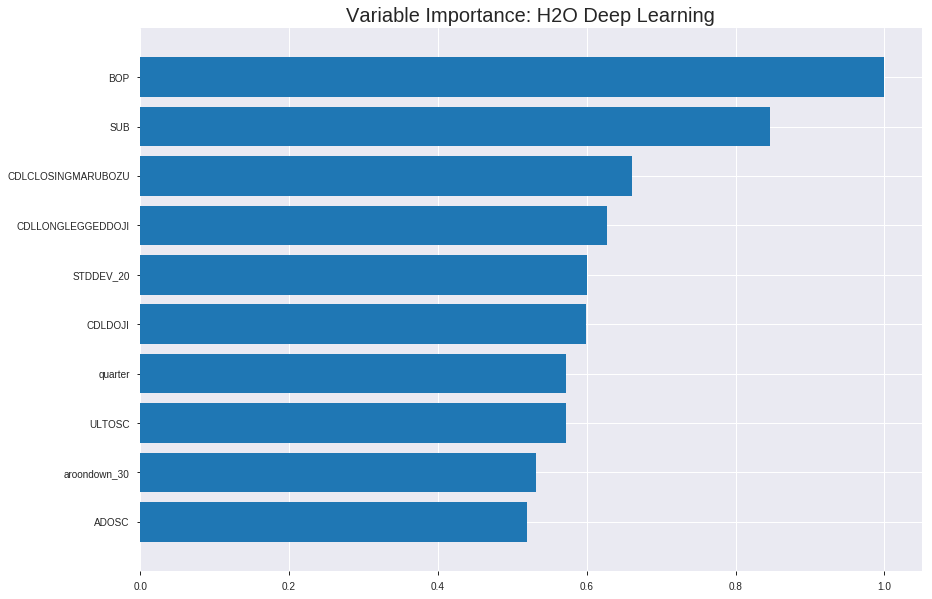

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_122409_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18056980410885315
RMSE: 0.424935058695859
LogLoss: 0.5356316980609573
Mean Per-Class Error: 0.26468975709756615
AUC: 0.802428229760117
pr_auc: 0.8049413559912022
Gini: 0.6048564595202339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3649126144242626: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      412  407   0.4969   (407.0/819.0)
1      69   853   0.0748   (69.0/922.0)
Total  481  1260  0.2734   (476.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364913     0.781852  267
max f2                       0.277008     0.876541  308
max f0point5                 0.488626     0.743677  209
max accuracy                 0.485937     0.739805  210
max precision                0.987757     1         0
max recall                   0.101859     1         375
max specificity              0.987757     1         0
max absolute_mcc             0.375696     0.478055  262
max min_per_class_accuracy   0.548697     0.71917   180
max mean_per_class_accuracy  0.485937     0.73531   210

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 50.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.969609           1.88829    1.88829            1                0.978341  1                           0.978341            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.942038           1.88829    1.88829            1                0.956646  1                           0.967803            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.921541           1.78338    1.85266            0.944444         0.932379  0.981132                    0.955772            0.0184382       0.0563991                  78.3382   85.2658
    4        0.0402068                   0.89479            1.77721    1.83434            0.941176         0.904493  0.971429                    0.943319            0.0173536       0.0737527                  77.7211   83.4335
    5        0.0505457                   0.865182           1.88829    1.84537            1                0.879582  0.977273                    0.930282            0.0195228       0.0932755                  88.8286   84.5371
    6        0.100517                    0.750382           1.67124    1.7588             0.885057         0.804714  0.931429                    0.867857            0.0835141       0.17679                    67.1242   75.8804
    7        0.150488                    0.699524           1.49761    1.67207            0.793103         0.723388  0.885496                    0.819884            0.0748373       0.251627                   49.7606   67.207
    8        0.20046                     0.673497           1.36738    1.59612            0.724138         0.686617  0.845272                    0.786663            0.0683297       0.319957                   36.738    59.6116
    9        0.300402                    0.640989           1.31312    1.50196            0.695402         0.65496   0.795411                    0.742846            0.131236        0.451193                   31.3119   50.1964
    10       0.400345                    0.602075           1.25886    1.44127            0.666667         0.623292  0.763271                    0.713               0.125813        0.577007                   25.8858   44.1275
    11       0.500287                    0.555645           1.29141    1.41134            0.683908         0.580919  0.747417                    0.686614            0.129067        0.706074                   29.1414   41.1337
    12       0.60023                     0.475126           1.11778    1.36246            0.591954         0.5158    0.721531                    0.658172            0.111714        0.817787                   11.7779   36.2457
    13       0.700172                    0.387154           0.889882   1.295              0.471264         0.431263  0.685808                    0.625783            0.0889371       0.906725                   -11.0118  29.5002
    14       0.800115                    0.293371           0.542611   1.20102            0.287356         0.341777  0.636037                    0.590308            0.0542299       0.960954                   -45.7389  20.1021
    15       0.900057                    0.186272           0.325567   1.10381            0.172414         0.241901  0.584556                    0.551621            0.032538        0.993492                   -67.4433  10.381
    16       1                           0.0223295          0.0651133  1                  0.0344828        0.113281  0.529581                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20668962990266515
RMSE: 0.4546313120569954
LogLoss: 0.5989671705770219
Mean Per-Class Error: 0.3105145739366604
AUC: 0.7366102462130397
pr_auc: 0.7330133751243019
Gini: 0.47322049242607944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34498480375493995: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  135  0.5696   (135.0/237.0)
1      29   232  0.1111   (29.0/261.0)
Total  131  367  0.3293   (164.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344985     0.738854  286
max f2                       0.224887     0.858688  344
max f0point5                 0.583995     0.711111  163
max accuracy                 0.560419     0.688755  184
max precision                0.987683     1         0
max recall                   0.0889476    1         391
max specificity              0.987683     1         0
max absolute_mcc             0.583995     0.379651  163
max min_per_class_accuracy   0.555454     0.678161  188
max mean_per_class_accuracy  0.560419     0.689485  184

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.965128           1.90805   1.90805            1                0.976138  1                           0.976138            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.938642           1.90805   1.90805            1                0.950257  1                           0.963197            0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.923714           1.52644   1.78084            0.8              0.931954  0.933333                    0.952783            0.0153257       0.0536398                  52.6437   78.0843
    4        0.0401606                   0.895353           1.90805   1.81264            1                0.913851  0.95                        0.94305             0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.864518           1.52644   1.7554             0.8              0.880391  0.92                        0.930518            0.0153257       0.0881226                  52.6437   75.5402
    6        0.100402                    0.75112            1.37379   1.5646             0.72             0.799722  0.82                        0.86512             0.0689655       0.157088                   37.3793   56.4598
    7        0.150602                    0.696951           1.45011   1.52644            0.76             0.719149  0.8                         0.816463            0.0727969       0.229885                   45.0115   52.6437
    8        0.200803                    0.666088           1.22115   1.45011            0.64             0.681621  0.76                        0.782753            0.0613027       0.291188                   22.1149   45.0115
    9        0.301205                    0.630763           1.25931   1.38651            0.66             0.646106  0.726667                    0.737204            0.126437        0.417625                   25.931    38.6513
    10       0.399598                    0.592847           1.51865   1.41905            0.795918         0.611515  0.743719                    0.706255            0.149425        0.56705                    51.8649   41.9049
    11       0.5                         0.556017           1.06851   1.34866            0.56             0.577492  0.706827                    0.680399            0.10728         0.67433                    6.85057   34.8659
    12       0.600402                    0.477811           0.915862  1.27628            0.48             0.515744  0.668896                    0.652865            0.091954        0.766284                   -8.41379  27.6285
    13       0.698795                    0.39039            0.856674  1.2172             0.44898          0.431618  0.637931                    0.621712            0.0842912       0.850575                   -14.3326  21.7202
    14       0.799197                    0.303864           0.801379  1.16496            0.42             0.339368  0.610553                    0.586242            0.0804598       0.931034                   -19.8621  16.4963
    15       0.899598                    0.195934           0.457931  1.08605            0.24             0.24942   0.569196                    0.54865             0.045977        0.977011                   -54.2069  8.6053
    16       1                           0.0234804          0.228966  1                  0.12             0.128532  0.524096                    0.50647           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:29:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:29:59  1 min  3.778 sec  656 obs/sec       0.554279  1             965        0.518449         0.764153            -0.0789328     0.680448        0.683729           1.67848          0.38139                          0.524528           0.776425              -0.103082        0.658681          0.680134             1.90805            0.385542
    2019-08-28 12:30:09  1 min 14.112 sec  1038 obs/sec      6.44687   12            11224      0.455896         0.604232            0.165714       0.757674        0.765647           1.88829          0.321654                         0.463784           0.619239              0.137613         0.724647          0.73891              1.90805            0.373494
    2019-08-28 12:30:20  1 min 24.260 sec  1176 obs/sec      13.4963   25            23497      0.460341         0.610977            0.149368       0.775979        0.781622           1.88829          0.300976                         0.47215            0.634879              0.10622          0.735899          0.741859             1.90805            0.38755
    2019-08-28 12:30:30  1 min 34.337 sec  1260 obs/sec      21.0454   39            36640      0.443094         0.575227            0.211914       0.76281         0.770298           1.88829          0.302125                         0.463574           0.616786              0.138396         0.706945          0.707994             1.90805            0.381526
    2019-08-28 12:30:39  1 min 44.197 sec  1310 obs/sec      28.5497   53            49705      0.450472         0.588455            0.18545        0.788859        0.794194           1.88829          0.277427                         0.469836           0.631624              0.114961         0.728761          0.730416             1.90805            0.351406
    2019-08-28 12:30:50  1 min 54.363 sec  1356 obs/sec      36.6077   68            63734      0.424935         0.535632            0.275184       0.802428        0.804941           1.88829          0.273406                         0.454631           0.598967              0.171317         0.73661           0.733013             1.90805            0.329317
    2019-08-28 12:31:01  2 min  5.269 sec  1403 obs/sec      45.8696   85            79859      0.425578         0.533892            0.272988       0.811453        0.81518            1.88829          0.264216                         0.462998           0.624342              0.140535         0.722141          0.724177             1.90805            0.321285
    2019-08-28 12:31:02  2 min  6.284 sec  1402 obs/sec      45.8696   85            79859      0.424935         0.535632            0.275184       0.802428        0.804941           1.88829          0.273406                         0.454631           0.598967              0.171317         0.73661           0.733013             1.90805            0.329317

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04648224472523046
SUB                 0.8464951515197754     0.8464951515197754   0.03934699479166324
CDLCLOSINGMARUBOZU  0.6614209413528442     0.6614209413528442   0.03074433006235521
CDLLONGLEGGEDDOJI   0.6278640627861023     0.6278640627861023   0.02918453102060107
STDDEV_20           0.6003938317298889     0.6003938317298889   0.027907653017987533
---                 ---                    ---                  ---
ROCR100_8           0.3100931942462921     0.3100931942462921   0.014413827742584576
RSI_14              0.304842472076416      0.304842472076416    0.014169762389700202
RSI_8               0.30354639887809753    0.30354639887809753  0.01410951799811415
CMO_8               0.3002704381942749     0.3002704381942749   0.013957243991898474
RSI_12              0.28775277733802795    0.28775277733802795  0.013375395016590965


See the whole table with table.as_data_frame()


('accuracy', 0.7028112449799196)

('F1', 0.75)

('auc', 0.7339901477832512)

('logloss', 0.6131793423643476)

('mean_per_class_error', 0.3013352346383199)

('rmse', 0.4595946690869952)

('mse', 0.21122725985318463)

deeplearning prediction progress: |███████████████████████████████████████| 100%


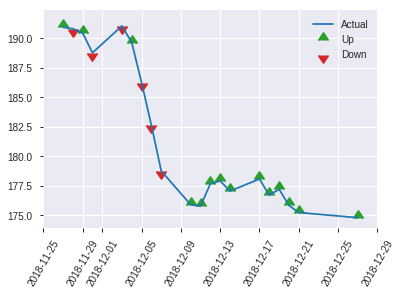


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21122725985318463
RMSE: 0.4595946690869952
LogLoss: 0.6131793423643476
Mean Per-Class Error: 0.3013352346383199
AUC: 0.7339901477832512
pr_auc: 0.7345874324301458
Gini: 0.46798029556650245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3981062339069207: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   52   0.4483   (52.0/116.0)
1      22   111  0.1654   (22.0/133.0)
Total  86   163  0.2972   (74.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398106     0.75      162
max f2                       0.0610912    0.859173  241
max f0point5                 0.46373      0.716312  142
max accuracy                 0.46373      0.702811  142
max precision                0.963194     1         0
max recall                   0.0610912    1         241
max specificity              0.963194     1         0
max absolute_mcc             0.398106     0.405274  162
max min_per_class_accuracy   0.523715     0.646617  125
max mean_per_class_accuracy  0.46373      0.698665  142

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 47.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.923854           1.87218   1.87218            1                0.94836    1                           0.94836             0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.893477           1.87218   1.87218            1                0.904081   1                           0.930648            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.882441           1.24812   1.63816            0.666667         0.88997    0.875                       0.915394            0.0150376       0.0526316                  24.812    63.8158
    4        0.0401606                   0.854277           1.87218   1.68496            1                0.865812   0.9                         0.905478            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.782808           1.24812   1.58415            0.666667         0.816279   0.846154                    0.884893            0.0150376       0.0827068                  24.812    58.4153
    6        0.100402                    0.71894            1.56015   1.57263            0.833333         0.743642   0.84                        0.817092            0.075188        0.157895                   56.015    57.2632
    7        0.15261                     0.677654           1.44014   1.52731            0.769231         0.694865   0.815789                    0.775278            0.075188        0.233083                   44.0139   52.7305
    8        0.200803                    0.665107           1.40414   1.49774            0.75             0.670859   0.8                         0.750217            0.0676692       0.300752                   40.4135   49.7744
    9        0.301205                    0.626693           1.27308   1.42286            0.68             0.642247   0.76                        0.714227            0.12782         0.428571                   27.3083   42.2857
    10       0.401606                    0.600743           1.12331   1.34797            0.6              0.613937   0.72                        0.689154            0.112782        0.541353                   12.3308   34.797
    11       0.502008                    0.528012           0.973534  1.27308            0.52             0.571042   0.68                        0.665532            0.0977444       0.639098                   -2.64662  27.3083
    12       0.598394                    0.414574           1.32613   1.28163            0.708333         0.478063   0.684564                    0.635336            0.12782         0.766917                   32.6128   28.1627
    13       0.698795                    0.348824           0.898647  1.2266             0.48             0.387598   0.655172                    0.599741            0.0902256       0.857143                   -10.1353  22.6601
    14       0.799197                    0.225964           0.599098  1.14777            0.32             0.285693   0.613065                    0.560288            0.0601504       0.917293                   -40.0902  14.7769
    15       0.899598                    0.141399           0.374436  1.06146            0.2              0.185872   0.566964                    0.5185              0.037594        0.954887                   -62.5564  6.14595
    16       1                           0.0309748          0.449323  1                  0.24             0.0785314  0.534137                    0.

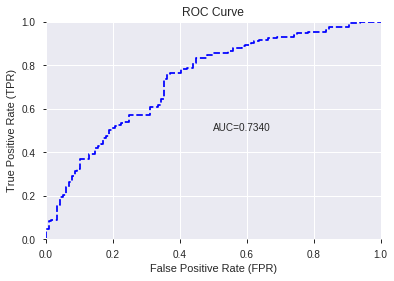

This function is available for GLM models only


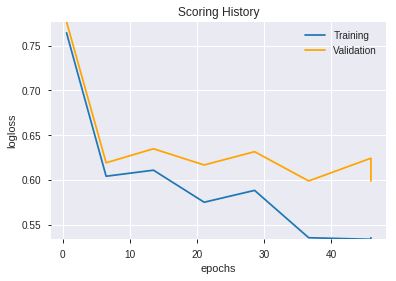

--2019-08-28 12:32:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.98.120
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.98.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_122409_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_122409_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_20',
 'CDLDOJI',
 'quarter',
 'ULTOSC',
 'aroondown_30',
 'ADOSC',
 'BETA_20',
 'weekday',
 'STOCHF_fastk',
 'aroondown_14',
 'SAREXT',
 'STOCHRSI_fastd',
 'CCI_8',
 'aroonup_30',
 'STOCHF_fastd',
 'ROCR100_12',
 'MACDFIX_signal_24',
 'STOCHRSI_fastk',
 'ROCP_12',
 'LINEARREG_SLOPE_8',
 'CDLBELTHOLD',
 'ROCR_12',
 'CDLLONGLINE',
 'MOM_14',
 'WILLR_20',
 'MACDFIX_signal_14',
 'MOM_12',
 'MACDFIX_12',
 'WILLR_12',
 'ROCR100_14',
 'WILLR_24',
 'WILLR_14',
 'MACD_signal',
 'ROC_14',
 'MOM_8',
 'ROCP_8',
 'CMO_20',
 'WILLR_8',
 'WILLR_30',
 'ROC_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_14',
 'RSI_8',
 'CMO_8',
 'RSI_12']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_123225_model_1  0.731203  0.61061              0.364629  0.45921  0.210874

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.819183           1.000000    0.133120
1         STOCHF_fastk             0.460370           0.561987    0.074812
2         STOCHF_fastd             0.330462           0.403405    0.053701
3                CCI_8             0.297469           0.363128    0.048340
4                  SUB             0.296061           0.361411    0.048111
5               CMO_20             0.268453           0.327708    0.043624
6       STOCHRSI_fastk             0.261957           0.319778    0.042569
7               ULTOSC             0.241177           0.294412    0.039192
8              WILLR_8             0.195382           0.238508    0.031750
9               MOM_14             0.186573           0.227755    0.030319
10               MOM_8             0.181006           0.220960    0.029414
11          ROCR100_14             0.154979           0.189188    0.025185
12              ROC_14             0.154480           0.188578    0.025104
13          MACDFIX_12             0.148116           0.180809    0.024069
14               RSI_8             0.142605           0.174082    0.023174
15               CMO_8             0.138721           0.169341    0.022543
16   MACDFIX_signal_24             0.124259           0.151686    0.020192
17        aroondown_14             0.123307           0.150525    0.020038
18  CDLCLOSINGMARUBOZU             0.121880           0.148783    0.019806
19            WILLR_14             0.120408           0.146985    0.019567
20         CDLLONGLINE             0.106344           0.129817    0.017281
21         CDLBELTHOLD             0.101318           0.123681    0.016464
22              RSI_14             0.087697           0.107054    0.014251
23            WILLR_24             0.081948           0.100037    0.013317
24         MACD_signal             0.079841           0.097465    0.012975
25             CDLDOJI             0.076377           0.093236    0.012412
26        aroondown_30             0.071206           0.086923    0.011571
27      STOCHRSI_fastd             0.070777           0.086400    0.011502
28             quarter             0.066020           0.080593    0.010729
29            WILLR_20             0.065316           0.079733    0.010614
30              SAREXT             0.061129           0.074622    0.009934
31           STDDEV_20             0.059509           0.072644    0.009670
32   LINEARREG_SLOPE_8             0.054852           0.066960    0.008914
33               ADOSC             0.042464           0.051836    0.006900
34            WILLR_12             0.039729           0.048498    0.006456
35              MOM_12             0.036639           0.044726    0.005954
36          ROCR100_12             0.036020           0.043970    0.005853
37             ROCR_12             0.035710           0.043593    0.005803
38             ROCP_12             0.035116           0.042868    0.005707
39             weekday             0.033739           0.041186    0.005483
40            WILLR_30             0.025567           0.031210    0.004155
41           ROCR100_8             0.020060           0.024488    0.003260
42              ROCR_8             0.020047           0.024472    0.003258
43               ROC_8             0.019874           0.024261    0.003230
44              ROCP_8             0.019687           0.024033    0.003199
45   MACDFIX_signal_14             0.011126           0.013582    0.001808
46   CDLLONGLEGGEDDOJI             0.010003           0.012211    0.001626
47              RSI_12             0.008007           0.009775    0.001301
48             BETA_20             0.007430           0.009070    0.001207
49          aroonup_30             0.003320           0.004052    0.000539

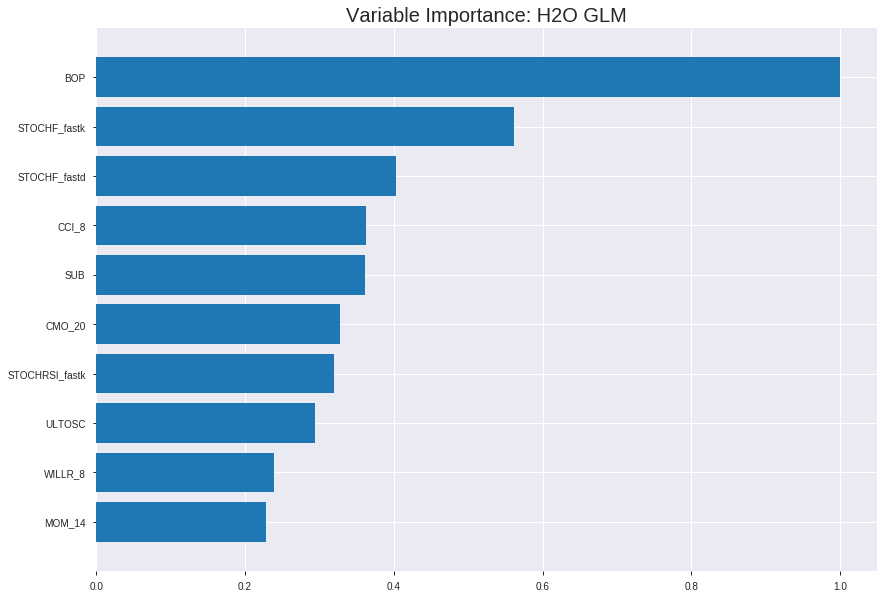

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123225_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19407294418404789
RMSE: 0.4405371087480008
LogLoss: 0.5716073050529222
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2407.4412986831494
Residual deviance: 1990.3366361942753
AIC: 2092.3366361942753
AUC: 0.7692830789360074
pr_auc: 0.76715306618965
Gini: 0.5385661578720149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31866114399839857: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      321  498   0.6081   (498.0/819.0)
1      61   861   0.0662   (61.0/922.0)
Total  382  1359  0.3211   (559.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318661     0.754932  293
max f2                       0.187989     0.86099   350
max f0point5                 0.484789     0.721059  219
max accuracy                 0.484789     0.714532  219
max precision                0.916238     1         0
max recall                   0.0567165    1         393
max specificity              0.916238     1         0
max absolute_mcc             0.476342     0.426662  222
max min_per_class_accuracy   0.558444     0.692308  183
max mean_per_class_accuracy  0.484789     0.709676  219

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.884856           1.78338   1.78338            0.944444         0.898229  0.944444                    0.898229            0.0184382       0.0184382                  78.3382   78.3382
    2        0.0201034                   0.872802           1.77721   1.78038            0.941176         0.879643  0.942857                    0.889202            0.0173536       0.0357918                  77.7211   78.0384
    3        0.0304423                   0.861806           1.57357   1.71015            0.833333         0.86733   0.90566                     0.881773            0.016269        0.0520607                  57.3572   71.0146
    4        0.0402068                   0.854158           1.55506   1.67248            0.823529         0.856901  0.885714                    0.875733            0.0151844       0.0672451                  55.5059   67.2482
    5        0.0505457                   0.842736           1.57357   1.65225            0.833333         0.847684  0.875                       0.869996            0.016269        0.0835141                  57.3572   65.2251
    6        0.100517                    0.803852           1.54102   1.59695            0.816092         0.821736  0.845714                    0.846004            0.0770065       0.160521                   54.1015   59.6951
    7        0.150488                    0.772955           1.62783   1.60721            0.862069         0.788582  0.851145                    0.826936            0.0813449       0.241866                   62.7833   60.7206
    8        0.20046                     0.743661           1.41079   1.55824            0.747126         0.7581    0.825215                    0.809776            0.0704989       0.312364                   41.0789   55.8242
    9        0.300402                    0.690088           1.30227   1.47308            0.689655         0.715784  0.780115                    0.778506            0.130152        0.442516                   30.2266   47.308
    10       0.400345                    0.639059           1.33482   1.43857            0.706897         0.66518   0.761836                    0.750215            0.133406        0.575922                   33.4823   43.8565
    11       0.500287                    0.566064           1.03096   1.35714            0.545977         0.607196  0.718714                    0.721644            0.103037        0.678959                   3.09609   35.7138
    12       0.60023                     0.476154           1.18289   1.32812            0.626437         0.526268  0.703349                    0.689112            0.118221        0.79718                    18.2892   32.8125
    13       0.700172                    0.38451            0.705394  1.23924            0.373563         0.428536  0.656276                    0.651918            0.0704989       0.867679                   -29.4606  23.9236
    14       0.800115                    0.29914            0.748803  1.17798            0.396552         0.344539  0.623833                    0.613523            0.0748373       0.942516                   -25.1197  17.7976
    15       0.900057                    0.19869            0.368975  1.08814            0.195402         0.252266  0.57626                     0.573409            0.0368764       0.979393                   -63.1025  8.81446
    16       1                           0.0253755          0.206192  1                  0.109195         0.134875  0.529581                    0.529581          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2058228260442314
RMSE: 0.453677006298789
LogLoss: 0.5972100329644614
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.27761756622
Residual deviance: 594.8211928326035
AIC: 696.8211928326035
AUC: 0.7402395848489257
pr_auc: 0.7406429599872485
Gini: 0.4804791696978514
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30313136977352817: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      23   238  0.0881   (23.0/261.0)
Total  109  389  0.3494   (174.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303131     0.732308  309
max f2                       0.164364     0.857713  366
max f0point5                 0.586682     0.7173    178
max accuracy                 0.555998     0.700803  197
max precision                0.882729     1         0
max recall                   0.131821     1         381
max specificity              0.882729     1         0
max absolute_mcc             0.555998     0.401186  197
max min_per_class_accuracy   0.555998     0.700422  197
max mean_per_class_accuracy  0.555998     0.700786  197

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 51.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.873793           1.90805   1.90805            1                0.878588  1                           0.878588            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.863046           1.90805   1.90805            1                0.866552  1                           0.87257             0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.846702           1.52644   1.78084            0.8              0.856549  0.933333                    0.86723             0.0153257       0.0536398                  52.6437   78.0843
    4        0.0401606                   0.831634           1.90805   1.81264            1                0.83882   0.95                        0.860127            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.808196           1.90805   1.83172            1                0.825265  0.96                        0.853155            0.0191571       0.091954                   90.8046   83.1724
    6        0.100402                    0.762014           1.37379   1.60276            0.72             0.785555  0.84                        0.819355            0.0689655       0.16092                    37.3793   60.2759
    7        0.150602                    0.737742           1.29747   1.501              0.68             0.751774  0.786667                    0.796828            0.0651341       0.226054                   29.7471   50.0996
    8        0.200803                    0.712663           1.22115   1.43103            0.64             0.726147  0.75                        0.779158            0.0613027       0.287356                   22.1149   43.1034
    9        0.301205                    0.666807           1.45011   1.43739            0.76             0.686588  0.753333                    0.748301            0.145594        0.43295                    45.0115   43.7395
    10       0.399598                    0.629457           1.40183   1.42864            0.734694         0.649621  0.748744                    0.724003            0.137931        0.570881                   40.183    42.8637
    11       0.5                         0.559905           1.14483   1.37165            0.6              0.596894  0.718876                    0.698479            0.114943        0.685824                   14.4828   37.1648
    12       0.600402                    0.460704           0.725057  1.26352            0.38             0.510704  0.662207                    0.667079            0.0727969       0.758621                   -27.4943  26.3522
    13       0.698795                    0.374458           0.778794  1.19527            0.408163         0.417703  0.626437                    0.631965            0.0766284       0.835249                   -22.1206  19.527
    14       0.799197                    0.286933           0.763218  1.14099            0.4              0.332781  0.59799                     0.594379            0.0766284       0.911877                   -23.6782  14.0992
    15       0.899598                    0.190703           0.534253  1.07328            0.28             0.244322  0.5625                      0.55531             0.0536398       0.965517                   -46.5747  7.32759
    16       1                           0.0261076          0.343448  1                  0.18             0.133648  0.524096                    0.512975          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 12:32:25  0.000 sec   2            .21E2     51            1.359573744872776   1.3682079361936468
     2019-08-28 12:32:25  0.083 sec   4            .13E2     51            1.3500005305424179  1.3615062044883264
     2019-08-28 12:32:26  0.173 sec   6            .81E1     51            1.3382532673031355  1.3530397838108765
     2019-08-28 12:32:26  0.202 sec   8            .5E1      51            1.3243422419094855  1.3425774332075213
     2019-08-28 12:32:26  0.238 sec   10           .31E1     51            1.3083533575470558  1.3298821716303844
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 12:32:26  0.620 sec   38           .4E-2     51            1.1405843887277163  1.1950392917156287
     2019-08-28 12:32:26  0.647 sec   40           .25E-2    51            1.1385053052640566  1.1963355657838117
     2019-08-28 12:32:26  0.678 sec   42           .15E-2    51            1.1369799471067468  1.198096270076636
     2019-08-28 12:32:26  0.701 sec   44           .95E-3    51            1.1359342418477227  1.2000206149943897
     2019-08-28 12:32:26  0.722 sec   46           .59E-3    51            1.1352902790268835  1.2018321433422254


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7393939393939394)

('auc', 0.731203007518797)

('logloss', 0.6106096742078307)

('mean_per_class_error', 0.3066502463054187)

('rmse', 0.4592102864786048)

('mse', 0.21087408720776227)

glm prediction progress: |████████████████████████████████████████████████| 100%


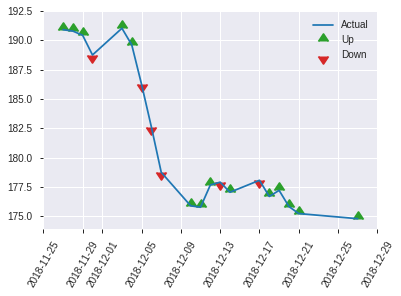


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21087408720776227
RMSE: 0.4592102864786048
LogLoss: 0.6106096742078307
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.04650308459236
Residual deviance: 304.08361775549974
AIC: 406.08361775549974
AUC: 0.731203007518797
pr_auc: 0.7309277253574472
Gini: 0.46240601503759393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24545214659145012: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   75   0.6466   (75.0/116.0)
1      11   122  0.0827   (11.0/133.0)
Total  52   197  0.3454   (86.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.245452     0.739394  196
max f2                       0.129697     0.865007  230
max f0point5                 0.519752     0.715421  123
max accuracy                 0.488229     0.694779  132
max precision                0.885598     1         0
max recall                   0.107316     1         238
max specificity              0.885598     1         0
max absolute_mcc             0.488229     0.3867    132
max min_per_class_accuracy   0.510794     0.681034  127
max mean_per_class_accuracy  0.488229     0.69335   132

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.845732           1.87218   1.87218            1                0.862805  1                           0.862805            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.834952           1.87218   1.87218            1                0.837359  1                           0.852627            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.815594           1.24812   1.63816            0.666667         0.823078  0.875                       0.841546            0.0150376       0.0526316                  24.812    63.8158
    4        0.0401606                   0.797864           1.87218   1.68496            1                0.808856  0.9                         0.835008            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.789552           1.87218   1.72817            1                0.793275  0.923077                    0.825377            0.0225564       0.0902256                  87.218    72.8167
    6        0.100402                    0.759922           1.09211   1.42286            0.583333         0.773323  0.76                        0.800391            0.0526316       0.142857                   9.21053   42.2857
    7        0.15261                     0.729435           1.72817   1.52731            0.923077         0.744207  0.815789                    0.78117             0.0902256       0.233083                   72.8167   52.7305
    8        0.200803                    0.696854           1.09211   1.42286            0.583333         0.710265  0.76                        0.764153            0.0526316       0.285714                   9.21053   42.2857
    9        0.301205                    0.667971           1.27308   1.37293            0.68             0.683452  0.733333                    0.737253            0.12782         0.413534                   27.3083   37.2932
    10       0.401606                    0.60358            1.27308   1.34797            0.68             0.640567  0.72                        0.713081            0.12782         0.541353                   27.3083   34.797
    11       0.502008                    0.518913           1.34797   1.34797            0.72             0.567227  0.72                        0.68391             0.135338        0.676692                   34.797    34.797
    12       0.598394                    0.409124           0.93609   1.28163            0.5              0.471844  0.684564                    0.649752            0.0902256       0.766917                   -6.39098  28.1627
    13       0.698795                    0.311592           0.599098  1.18356            0.32             0.361256  0.632184                    0.608301            0.0601504       0.827068                   -40.0902  18.3562
    14       0.799197                    0.229155           0.898647  1.14777            0.48             0.276425  0.613065                    0.566608            0.0902256       0.917293                   -10.1353  14.7769
    15       0.899598                    0.148359           0.524211  1.07818            0.28             0.186449  0.575893                    0.52418             0.0526316       0.969925                   -47.5789  7.81753
    16       1                           0.0503789          0.299549  1                  0.16             0.110516  0.534137                    0.482647            0

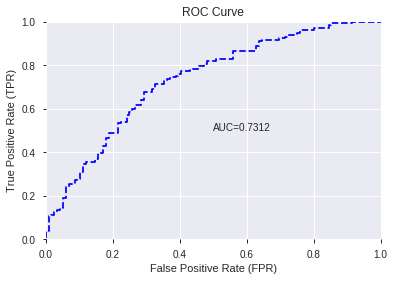

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


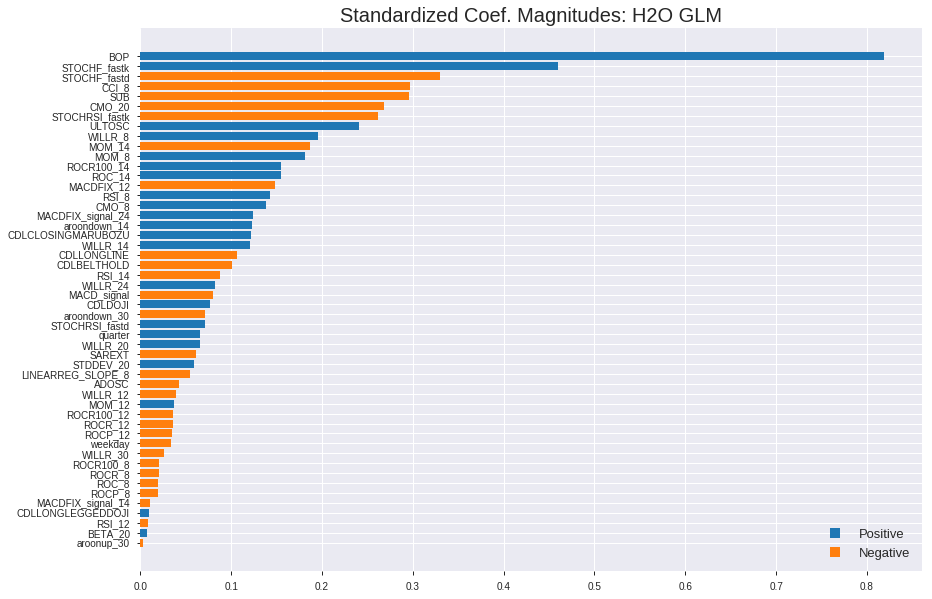

'log_likelihood'
--2019-08-28 12:32:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123225_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123225_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CCI_8',
 'SUB',
 'CMO_20',
 'STOCHRSI_fastk',
 'ULTOSC',
 'WILLR_8',
 'MOM_14',
 'MOM_8',
 'ROCR100_14',
 'ROC_14',
 'MACDFIX_12',
 'RSI_8',
 'CMO_8',
 'MACDFIX_signal_24',
 'aroondown_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_14',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'RSI_14',
 'WILLR_24',
 'MACD_signal',
 'CDLDOJI',
 'aroondown_30',
 'STOCHRSI_fastd',
 'quarter',
 'WILLR_20',
 'SAREXT',
 'STDDEV_20',
 'LINEARREG_SLOPE_8',
 'ADOSC',
 'WILLR_12',
 'MOM_12',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'weekday',
 'WILLR_30',
 'ROCR100_8',
 'ROCR_8',
 'ROC_8',
 'ROCP_8',
 'MACDFIX_signal_14',
 'CDLLONGLEGGEDDOJI',
 'RSI_12',
 'BETA_20',
 'aroonup_30']

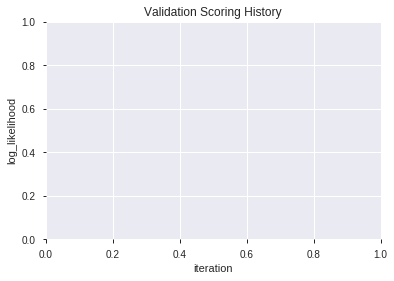

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123241_model_7  0.733148  0.605452              0.361972  0.457542  0.209345
1  XGBoost_grid_1_AutoML_20190828_123241_model_4  0.733083  0.609434              0.327392  0.458492  0.210215
2  XGBoost_grid_1_AutoML_20190828_123241_model_1  0.731333  0.617156              0.326290  0.461051  0.212568
3               XGBoost_2_AutoML_20190828_123241  0.731073  0.609719              0.320327  0.458695  0.210401
4  XGBoost_grid_1_AutoML_20190828_123241_model_2  0.730425  0.604641              0.347388  0.457446  0.209257
5  XGBoost_grid_1_AutoML_20190828_123241_model_6  0.729777  0.605068              0.342527  0.457406  0.209220
6  XGBoost_grid_1_AutoML_20190828_123241_model_3  0.729647  0.606709              0.308951  0.457680  0.209471
7  XGBoost_grid_1_AutoML_20190828_123241_model_5  0.725240  0.626933              0.351698  0.467249  0.218321
8               XGBoost_3_AutoML_20190828_123241  0.721610  0.615405              0.334911  0.461837  0.213294
9               XGBoost_1_AutoML_20190828_123241  0.720379  0.620283              0.331702  0.463459  0.214795

variable  relative_importance  scaled_importance  percentage
0                  BOP          1920.311523           1.000000    0.196763
1         STOCHF_fastk           747.312012           0.389162    0.076573
2                  SUB           599.421021           0.312148    0.061419
3            STDDEV_20           471.510956           0.245539    0.048313
4         STOCHF_fastd           331.080048           0.172410    0.033924
5                CCI_8           291.413239           0.151753    0.029859
6                ADOSC           280.581177           0.146112    0.028750
7               ULTOSC           270.314301           0.140766    0.027698
8       STOCHRSI_fastd           266.674011           0.138870    0.027325
9       STOCHRSI_fastk           263.158356           0.137039    0.026964
10             BETA_20           235.337463           0.122552    0.024114
11   LINEARREG_SLOPE_8           212.741653           0.110785    0.021798
12   MACDFIX_signal_24           209.510162           0.109102    0.021467
13             WILLR_8           208.219238           0.108430    0.021335
14          MACDFIX_12           202.227936           0.105310    0.020721
15        aroondown_30           180.929916           0.094219    0.018539
16         MACD_signal           178.345779           0.092873    0.018274
17              SAREXT           177.010361           0.092178    0.018137
18            WILLR_20           172.614334           0.089889    0.017687
19             weekday           164.770035           0.085804    0.016883
20              MOM_12           155.876251           0.081172    0.015972
21            WILLR_12           144.040070           0.075009    0.014759
22             ROCP_12           141.430740           0.073650    0.014492
23        aroondown_14           140.970230           0.073410    0.014444
24               CMO_8           132.210632           0.068849    0.013547
25              MOM_14           131.251587           0.068349    0.013449
26              RSI_12           130.851028           0.068141    0.013408
27              CMO_20           118.638458           0.061781    0.012156
28   MACDFIX_signal_14           116.158188           0.060489    0.011902
29               MOM_8           113.197571           0.058948    0.011599
30            WILLR_14           111.438927           0.058032    0.011419
31            WILLR_30           105.223335           0.054795    0.010782
32              ROC_14           102.361435           0.053305    0.010488
33               ROC_8            94.680367           0.049305    0.009701
34             quarter            90.710114           0.047237    0.009295
35          aroonup_30            88.083969           0.045870    0.009025
36            WILLR_24            80.665421           0.042006    0.008265
37  CDLCLOSINGMARUBOZU            58.395630           0.030409    0.005983
38          ROCR100_14            53.984768           0.028113    0.005532
39               RSI_8            48.811806           0.025419    0.005001
40              RSI_14            46.468136           0.024198    0.004761
41              ROCP_8            46.131550           0.024023    0.004727
42          ROCR100_12            41.574234           0.021650    0.004260
43             ROCR_12            29.307932           0.015262    0.003003
44              ROCR_8            28.812321           0.015004    0.002952
45         CDLLONGLINE            14.841593           0.007729    0.001521
46             CDLDOJI             7.338287           0.003821    0.000752
47         CDLBELTHOLD             2.562977           0.001335    0.000263

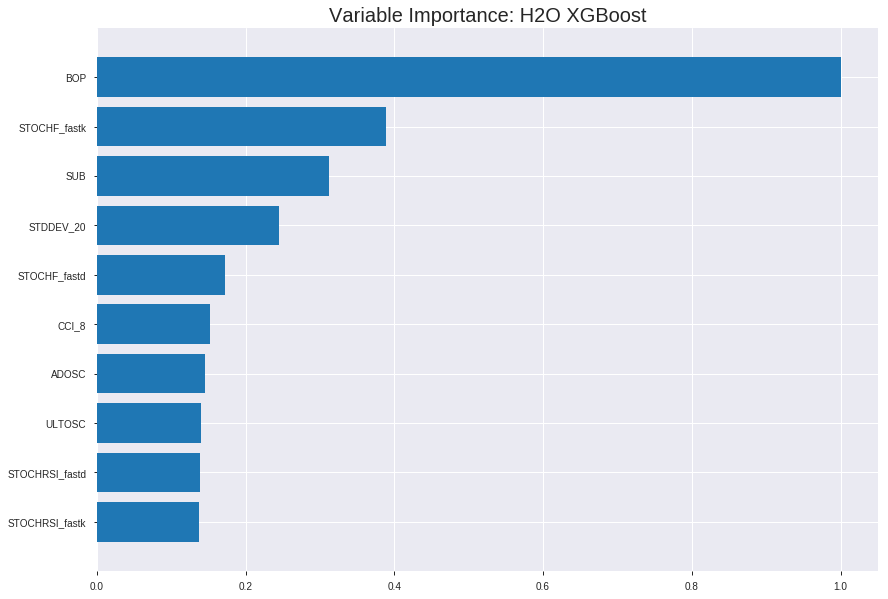

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123241_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11756957410257057
RMSE: 0.3428841992605821
LogLoss: 0.3956606818672345
Mean Per-Class Error: 0.12227161847552304
AUC: 0.9501614317232538
pr_auc: 0.9562494762488623
Gini: 0.9003228634465077
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138338655233383: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      696  123  0.1502   (123.0/819.0)
1      87   835  0.0944   (87.0/922.0)
Total  783  958  0.1206   (210.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513834     0.888298  202
max f2                       0.379722     0.923345  261
max f0point5                 0.613407     0.902389  156
max accuracy                 0.513834     0.87938   202
max precision                0.936716     1         0
max recall                   0.191048     1         345
max specificity              0.936716     1         0
max absolute_mcc             0.513834     0.757972  202
max min_per_class_accuracy   0.537981     0.873102  192
max mean_per_class_accuracy  0.513834     0.877728  202

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.918158           1.88829    1.88829            1                0.925614  1                           0.925614            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.908648           1.88829    1.88829            1                0.913881  1                           0.919915            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.895555           1.88829    1.88829            1                0.901443  1                           0.913642            0.0195228       0.0574837                  88.8286   88.8286
    4        0.0402068                   0.886967           1.88829    1.88829            1                0.8904    1                           0.907997            0.0184382       0.0759219                  88.8286   88.8286
    5        0.0505457                   0.874943           1.88829    1.88829            1                0.880187  1                           0.902309            0.0195228       0.0954447                  88.8286   88.8286
    6        0.100517                    0.83837            1.88829    1.88829            1                0.855846  1                           0.87921             0.0943601       0.189805                   88.8286   88.8286
    7        0.150488                    0.804054           1.88829    1.88829            1                0.818331  1                           0.858995            0.0943601       0.284165                   88.8286   88.8286
    8        0.20046                     0.774493           1.84488    1.87747            0.977011         0.788717  0.994269                    0.841475            0.0921909       0.376356                   84.4877   87.7465
    9        0.300402                    0.715041           1.81232    1.85579            0.95977          0.744408  0.982792                    0.809181            0.181128        0.557484                   81.2321   85.5792
    10       0.400345                    0.639899           1.64954    1.8043             0.873563         0.677198  0.955524                    0.776233            0.164859        0.722343                   64.9537   80.4302
    11       0.500287                    0.553226           1.23715    1.691              0.655172         0.597112  0.895522                    0.74045             0.123644        0.845987                   23.7153   69.1003
    12       0.60023                     0.458017           0.922439   1.56303            0.488506         0.509873  0.827751                    0.702057            0.0921909       0.938178                   -7.75613  56.3031
    13       0.700172                    0.362421           0.401532   1.39724            0.212644         0.409458  0.739951                    0.660292            0.0401302       0.978308                   -59.8468  39.7239
    14       0.800115                    0.259033           0.141079   1.24033            0.0747126        0.313999  0.656856                    0.617036            0.0140998       0.992408                   -85.8921  24.0332
    15       0.900057                    0.165847           0.0759655  1.11104            0.0402299        0.215735  0.588385                    0.572476            0.00759219      1                          -92.4034  11.104
    16       1                           0.0569734          0          1                  0                0.119211  0.529581                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20545129919726557
RMSE: 0.4532673595101081
LogLoss: 0.5975800475058319
Mean Per-Class Error: 0.3064649110044133
AUC: 0.7434324328693599
pr_auc: 0.7489694110391251
Gini: 0.4868648657387198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3498722016811371: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  135  0.5696   (135.0/237.0)
1      32   229  0.1226   (32.0/261.0)
Total  134  364  0.3353   (167.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349872     0.7328    289
max f2                       0.116458     0.850785  386
max f0point5                 0.609945     0.715588  160
max accuracy                 0.565966     0.692771  192
max precision                0.930953     1         0
max recall                   0.0836891    1         396
max specificity              0.930953     1         0
max absolute_mcc             0.5903       0.388429  170
max min_per_class_accuracy   0.565966     0.685824  192
max mean_per_class_accuracy  0.5903       0.693535  170

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.905541           1.90805   1.90805            1                0.919083  1                           0.919083            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.88313            1.90805   1.90805            1                0.894837  1                           0.90696             0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.875309           1.90805   1.90805            1                0.878441  1                           0.897453            0.0191571       0.0574713                  90.8046   90.8046
    4        0.0401606                   0.861752           1.52644   1.81264            0.8              0.870857  0.95                        0.890804            0.0153257       0.0727969                  52.6437   81.2644
    5        0.0502008                   0.853765           1.90805   1.83172            1                0.859017  0.96                        0.884447            0.0191571       0.091954                   90.8046   83.1724
    6        0.100402                    0.810769           1.29747   1.5646             0.68             0.833775  0.82                        0.859111            0.0651341       0.157088                   29.7471   56.4598
    7        0.150602                    0.775946           1.45011   1.52644            0.76             0.792968  0.8                         0.837063            0.0727969       0.229885                   45.0115   52.6437
    8        0.200803                    0.734208           1.45011   1.50736            0.76             0.757067  0.79                        0.817064            0.0727969       0.302682                   45.0115   50.7356
    9        0.301205                    0.677939           1.33563   1.45011            0.7              0.703166  0.76                        0.779098            0.1341          0.436782                   33.5632   45.0115
    10       0.399598                    0.615417           1.36289   1.42864            0.714286         0.647998  0.748744                    0.746817            0.1341          0.570881                   36.289    42.8637
    11       0.5                         0.56649            1.10667   1.36398            0.58             0.592302  0.714859                    0.71579             0.111111        0.681992                   10.6667   36.3985
    12       0.600402                    0.49151            0.801379  1.2699             0.42             0.530153  0.665552                    0.684747            0.0804598       0.762452                   -19.8621  26.9904
    13       0.698795                    0.390692           0.817734  1.20624            0.428571         0.444603  0.632184                    0.650934            0.0804598       0.842912                   -18.2266  20.6236
    14       0.799197                    0.291304           0.725057  1.14579            0.38             0.336266  0.600503                    0.611403            0.0727969       0.915709                   -27.4943  14.5786
    15       0.899598                    0.195797           0.534253  1.07753            0.28             0.245515  0.564732                    0.570567            0.0536398       0.969349                   -46.5747  7.75349
    16       1                           0.070417           0.305287  1                  0.16             0.137864  0.524096                    0.527123         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:32:59  10.723 sec  0                  0.5              0.693147            0.5             0                  1                0.470419                         0.5                0.693147              0.5               0                    1                  0.475904
    2019-08-28 12:32:59  10.881 sec  5                  0.467749         0.630267            0.861199        0.873982           1.88829          0.233774                         0.4813             0.656178              0.729101          0.742193             1.90805            0.313253
    2019-08-28 12:33:00  10.982 sec  10                 0.442294         0.582033            0.88411         0.894396           1.88829          0.208501                         0.469168           0.632215              0.742341          0.749822             1.90805            0.339357
    2019-08-28 12:33:00  11.093 sec  15                 0.423917         0.547359            0.895675        0.905758           1.88829          0.205629                         0.462851           0.619377              0.742875          0.745557             1.90805            0.323293
    2019-08-28 12:33:00  11.200 sec  20                 0.407391         0.516246            0.907114        0.916929           1.88829          0.180356                         0.457644           0.608414              0.743618          0.748953             1.90805            0.321285
    2019-08-28 12:33:00  11.300 sec  25                 0.394142         0.491066            0.916043        0.925724           1.88829          0.166571                         0.455498           0.603285              0.743125          0.751004             1.90805            0.329317
    2019-08-28 12:33:00  11.421 sec  30                 0.383872         0.471791            0.924427        0.932675           1.88829          0.151637                         0.454179           0.600184              0.743263          0.750372             1.90805            0.321285
    2019-08-28 12:33:00  11.523 sec  35                 0.374903         0.454776            0.929794        0.93681            1.88829          0.148191                         0.454883           0.601068              0.74045           0.746299             1.90805            0.329317
    2019-08-28 12:33:00  11.626 sec  40                 0.366037         0.437926            0.935071        0.942162           1.88829          0.143021                         0.454114           0.599205              0.739908          0.746426             1.90805            0.327309
    2019-08-28 12:33:00  11.729 sec  45                 0.358213         0.423272            0.939588        0.946905           1.88829          0.138426                         0.45292            0.596571              0.742883          0.748096             1.90805            0.327309
    2019-08-28 12:33:00  11.828 sec  50                 0.34993          0.408154            0.945356        0.952141           1.88829          0.129236                         0.453391           0.59755               0.742196          0.746735             1.90805            0.345382
    2019-08-28 12:33:00  11.929 sec  55                 0.342884         0.395661            0.950161        0.956249           1.88829          0.12062                          0.453267           0.59758               0.743432          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1920.3115234375        1.0                    0.1967632882596905
STOCHF_fastk  747.31201171875        0.38916186389435714    0.07657276800512383
SUB           599.4210205078125      0.31214780164147765    0.06141922787401076
STDDEV_20     471.5109558105469      0.24553878371073215    0.04831301847820859
STOCHF_fastd  331.0800476074219      0.1724095510372005     0.0339238701894565
---           ---                    ---                    ---
ROCR_12       29.307931900024414     0.015262071566159767   0.0030030153870123206
ROCR_8        28.812320709228516     0.015003982613014957   0.0029522329559280467
CDLLONGLINE   14.841592788696289     0.0077287422418466445  0.001520732737617318
CDLDOJI       7.338287353515625      0.0038214046335458877  0.0007519121414673065
CDLBELTHOLD   2.562976837158203      0.001334667217207698   0.0002626135103901972


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6867469879518072)

('F1', 0.7462686567164178)

('auc', 0.7331475239823697)

('logloss', 0.6054524104241265)

('mean_per_class_error', 0.32013222711952294)

('rmse', 0.45754194898686174)

('mse', 0.209344635082696)

xgboost prediction progress: |████████████████████████████████████████████| 100%


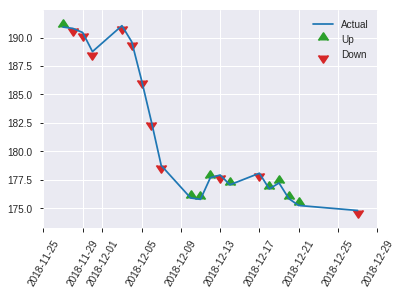


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.209344635082696
RMSE: 0.45754194898686174
LogLoss: 0.6054524104241265
Mean Per-Class Error: 0.32013222711952294
AUC: 0.7331475239823697
pr_auc: 0.7428760574116631
Gini: 0.4662950479647394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23126043379306793: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      39   77   0.6638   (77.0/116.0)
1      8    125  0.0602   (8.0/133.0)
Total  47   202  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23126      0.746269  201
max f2                       0.101391     0.859173  241
max f0point5                 0.508651     0.70073   137
max accuracy                 0.378742     0.686747  166
max precision                0.909852     1         0
max recall                   0.101391     1         241
max specificity              0.909852     1         0
max absolute_mcc             0.378742     0.373439  166
max min_per_class_accuracy   0.532514     0.655172  127
max mean_per_class_accuracy  0.508651     0.679868  137

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.875038           1.24812   1.24812            0.666667         0.892846  0.666667                    0.892846            0.0150376       0.0150376                  24.812    24.812
    2        0.0200803                   0.867662           1.87218   1.49774            1                0.871372  0.8                         0.884256            0.0150376       0.0300752                  87.218    49.7744
    3        0.0321285                   0.863641           1.87218   1.63816            1                0.866694  0.875                       0.877671            0.0225564       0.0526316                  87.218    63.8158
    4        0.0401606                   0.852238           1.87218   1.68496            1                0.857693  0.9                         0.873675            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.851137           1.87218   1.72817            1                0.851648  0.923077                    0.868592            0.0225564       0.0902256                  87.218    72.8167
    6        0.100402                    0.822277           1.71617   1.72241            0.916667         0.833222  0.92                        0.851614            0.0827068       0.172932                   71.6165   72.2406
    7        0.15261                     0.790144           1.44014   1.62584            0.769231         0.807315  0.868421                    0.836459            0.075188        0.24812                    44.0139   62.5841
    8        0.200803                    0.737662           0.93609   1.4603             0.5              0.76274   0.78                        0.818767            0.0451128       0.293233                   -6.39098  46.0301
    9        0.301205                    0.6572             1.34797   1.42286            0.72             0.695238  0.76                        0.77759             0.135338        0.428571                   34.797    42.2857
    10       0.401606                    0.608715           1.04842   1.32925            0.56             0.632587  0.71                        0.741339            0.105263        0.533835                   4.84211   32.9248
    11       0.502008                    0.54041            1.1982    1.30304            0.64             0.576421  0.696                       0.708356            0.120301        0.654135                   19.8195   30.3038
    12       0.598394                    0.453832           1.0141    1.2565             0.541667         0.503855  0.671141                    0.675416            0.0977444       0.75188                    1.40977   25.6497
    13       0.698795                    0.340785           0.973534  1.21584            0.52             0.401298  0.649425                    0.636031            0.0977444       0.849624                   -2.64662  21.5841
    14       0.799197                    0.23626            0.673985  1.14777            0.36             0.276666  0.613065                    0.590885            0.0676692       0.917293                   -32.6015  14.7769
    15       0.899598                    0.168703           0.449323  1.06982            0.24             0.199749  0.571429                    0.547231            0.0451128       0.962406                   -55.0677  6.98174
    16       1                           0.0708383          0.374436  1                  0.2              0.125304  0.534137                    0.504869          

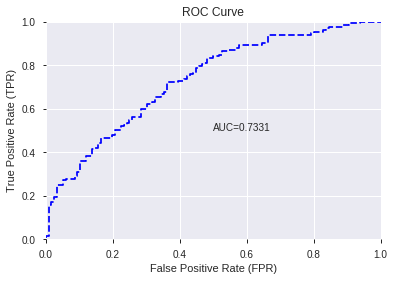

This function is available for GLM models only


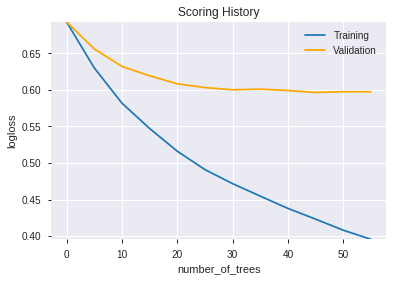

--2019-08-28 12:33:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123241_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123241_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STDDEV_20',
 'STOCHF_fastd',
 'CCI_8',
 'ADOSC',
 'ULTOSC',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'BETA_20',
 'LINEARREG_SLOPE_8',
 'MACDFIX_signal_24',
 'WILLR_8',
 'MACDFIX_12',
 'aroondown_30',
 'MACD_signal',
 'SAREXT',
 'WILLR_20',
 'weekday',
 'MOM_12',
 'WILLR_12',
 'ROCP_12',
 'aroondown_14',
 'CMO_8',
 'MOM_14',
 'RSI_12',
 'CMO_20',
 'MACDFIX_signal_14',
 'MOM_8',
 'WILLR_14',
 'WILLR_30',
 'ROC_14',
 'ROC_8',
 'quarter',
 'aroonup_30',
 'WILLR_24',
 'CDLCLOSINGMARUBOZU',
 'ROCR100_14',
 'RSI_8',
 'RSI_14',
 'ROCP_8',
 'ROCR100_12',
 'ROCR_12',
 'ROCR_8',
 'CDLLONGLINE',
 'CDLDOJI',
 'CDLBELTHOLD']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_123314_model_1  0.48668  17.234149                   0.5  0.723167  0.522971

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.009205           1.000000    0.030072
1           STOCHF_fastk             0.005933           0.644482    0.019381
2            CDLLONGLINE             0.005100           0.554072    0.016662
3         STOCHRSI_fastk             0.004988           0.541830    0.016294
4     CDLCLOSINGMARUBOZU             0.004905           0.532796    0.016022
...                  ...                  ...                ...         ...
1036              MAX_24             0.000000           0.000000    0.000000
1037              MIN_24             0.000000           0.000000    0.000000
1038       MINMAX_min_24             0.000000           0.000000    0.000000
1039       MINMAX_max_24             0.000000           0.000000    0.000000
1040              SUM_24             0.000000           0.000000    0.000000

[1041 rows x 4 columns]

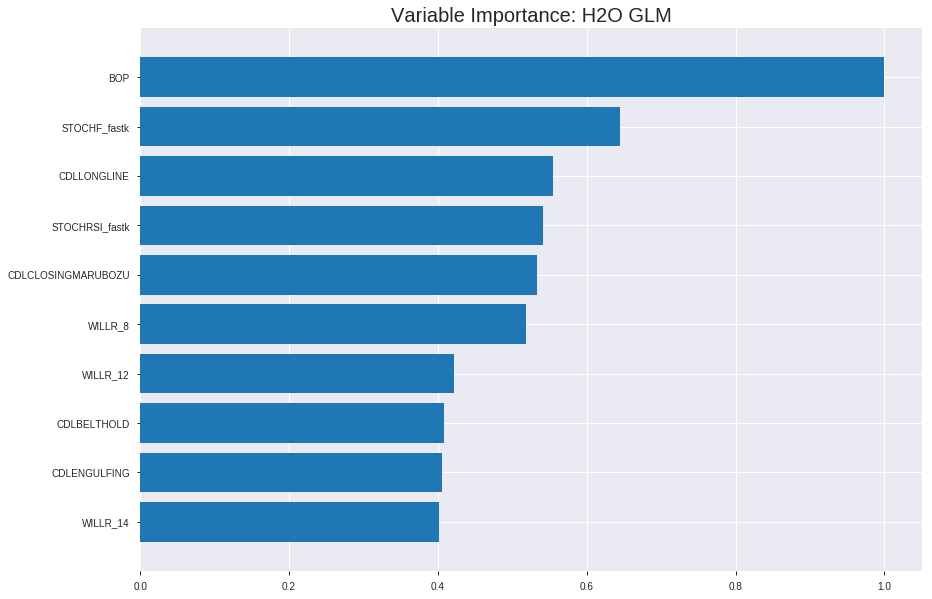

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123314_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24170193190999514
RMSE: 0.4916319069283392
LogLoss: 0.6764665119145573
Null degrees of freedom: 1740
Residual degrees of freedom: 754
Null deviance: 2407.4412986831494
Residual deviance: 2355.4563944864885
AIC: 4329.4563944864885
AUC: 0.6477663093715155
pr_auc: 0.6513199820071451
Gini: 0.29553261874303094
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4861980102409691: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      146  673   0.8217   (673.0/819.0)
1      62   860   0.0672   (62.0/922.0)
Total  208  1533  0.4222   (735.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486198     0.700611  317
max f2                       0.42771      0.8493    398
max f0point5                 0.527548     0.635735  196
max accuracy                 0.527548     0.614589  196
max precision                0.598518     1         0
max recall                   0.42771      1         398
max specificity              0.598518     1         0
max absolute_mcc             0.537618     0.22655   162
max min_per_class_accuracy   0.532877     0.607375  179
max mean_per_class_accuracy  0.536909     0.613156  165

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.584591           1.25886   1.25886            0.666667         0.590379  0.666667                    0.590379            0.0130152       0.0130152                  25.8858   25.8858
    2        0.0201034                   0.582361           1.44398   1.34878            0.764706         0.583596  0.714286                    0.587084            0.0140998       0.027115                   44.3984   34.8776
    3        0.0304423                   0.580726           1.57357   1.42512            0.833333         0.581323  0.754717                    0.585128            0.016269        0.0433839                  57.3572   42.5122
    4        0.0402068                   0.578903           1.11076   1.34878            0.588235         0.579699  0.714286                    0.583809            0.010846        0.0542299                  11.0757   34.8776
    5        0.0505457                   0.577179           1.25886   1.33038            0.666667         0.577937  0.704545                    0.582608            0.0130152       0.0672451                  25.8858   33.0384
    6        0.100517                    0.571053           1.36738   1.34878            0.724138         0.574033  0.714286                    0.578345            0.0683297       0.135575                   36.738    34.8776
    7        0.150488                    0.566032           1.4759    1.39099            0.781609         0.568475  0.736641                    0.575068            0.0737527       0.209328                   47.5902   39.099
    8        0.20046                     0.5619             1.23715   1.35264            0.655172         0.563993  0.716332                    0.572307            0.0618221       0.27115                    23.7153   35.2641
    9        0.300402                    0.552534           1.2046    1.30339            0.637931         0.557623  0.690249                    0.567422            0.12039         0.39154                    20.4596   30.3387
    10       0.400345                    0.543011           1.04181   1.23809            0.551724         0.548264  0.655667                    0.562639            0.104121        0.495662                   4.18131   23.8087
    11       0.500287                    0.533548           1.05267   1.20105            0.557471         0.53812   0.636051                    0.557741            0.105206        0.600868                   5.26654   20.1045
    12       0.60023                     0.523562           0.900734  1.15104            0.477011         0.528139  0.609569                    0.552812            0.0900217       0.690889                   -9.92657  15.1042
    13       0.700172                    0.511437           0.944143  1.12151            0.5              0.517532  0.593929                    0.547776            0.0943601       0.785249                   -5.58568  12.1509
    14       0.800115                    0.497883           0.846473  1.08715            0.448276         0.504488  0.575736                    0.542369            0.0845987       0.869848                   -15.3527  8.71541
    15       0.900057                    0.481389           0.759655  1.05079            0.402299         0.490267  0.556477                    0.536584            0.0759219       0.94577                    -24.0345  5.07886
    16       1                           0.399685           0.542611  1                  0.287356         0.466515  0.529581                    0.529581          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3301139741446919
RMSE: 0.5745554578495377
LogLoss: 5.378830112689041
Null degrees of freedom: 497
Residual degrees of freedom: -489
Null deviance: 689.27761756622
Residual deviance: 85574.69253686232
AIC: 87548.69253686232
AUC: 0.5257933621093813
pr_auc: 0.574745975442925
Gini: 0.05158672421876265
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.901229010827608e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    261  0        (0.0/261.0)
Total  0    498  0.4759   (237.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.90123e-49  0.687747  379
max f2                       8.90123e-49  0.846304  379
max f0point5                 8.90123e-49  0.579228  379
max accuracy                 0.497863     0.540161  265
max precision                0.587888     1         0
max recall                   8.90123e-49  1         379
max specificity              0.587888     1         0
max absolute_mcc             0.564749     0.147311  36
max min_per_class_accuracy   0.505386     0.528736  248
max mean_per_class_accuracy  0.545523     0.547408  112

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 37.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.580495           1.52644   1.52644            0.8              0.58382    0.8                         0.58382             0.0153257       0.0153257                  52.6437   52.6437
    2        0.0200803                   0.573952           1.52644   1.52644            0.8              0.578485   0.8                         0.581153            0.0153257       0.0306513                  52.6437   52.6437
    3        0.0301205                   0.570199           1.52644   1.52644            0.8              0.571893   0.8                         0.578066            0.0153257       0.045977                   52.6437   52.6437
    4        0.0401606                   0.568891           1.52644   1.52644            0.8              0.569282   0.8                         0.57587             0.0153257       0.0613027                  52.6437   52.6437
    5        0.0502008                   0.567354           1.52644   1.52644            0.8              0.568297   0.8                         0.574355            0.0153257       0.0766284                  52.6437   52.6437
    6        0.100402                    0.561052           0.915862  1.22115            0.48             0.564311   0.64                        0.569333            0.045977        0.122605                   -8.41379  22.1149
    7        0.150602                    0.555929           1.06851   1.17027            0.56             0.558318   0.613333                    0.565661            0.0536398       0.176245                   6.85057   17.0268
    8        0.200803                    0.5488             1.22115   1.18299            0.64             0.551934   0.62                        0.56223             0.0613027       0.237548                   22.1149   18.2989
    9        0.301205                    0.53542            0.877701  1.08123            0.46             0.541933   0.566667                    0.555464            0.0881226       0.32567                    -12.2299  8.12261
    10       0.399598                    0.520057           0.817734  1.01635            0.428571         0.528741   0.532663                    0.548884            0.0804598       0.40613                    -18.2266  1.63461
    11       0.5                         0.505217           1.22115   1.05747            0.64             0.511782   0.554217                    0.541434            0.122605        0.528736                   22.1149   5.74713
    12       0.600402                    0.477017           0.83954   1.02103            0.44             0.493909   0.535117                    0.533486            0.0842912       0.613027                   -16.046   2.10279
    13       0.698795                    0.416027           0.739855  0.981437           0.387755         0.458672   0.514368                    0.522952            0.0727969       0.685824                   -26.0145  -1.85626
    14       1                           0                  1.04307   1                  0.546667         0.0292316  0.524096                    0.374241            0.314176        1                          4.30651   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:33:19  0.000 sec   2            21        987           1.35293           171.837
    2019-08-28 12:33:21  2.297 sec   4            15        1009          1.34598           178.331
    2019-08-28 12:33:23  4.685 sec   6            11        1020          1.33775           185.517
    2019-08-28 12:33:26  7.132 sec   8            8.1       1030          1.32809           191.064
    2019-08-28 12:33:28  9.445 sec   10           5.9       1031          1.31686           194.184

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5341365461847389)

('F1', 0.6963350785340314)

('auc', 0.48668006222452687)

('logloss', 17.234149366685756)

('mean_per_class_error', 0.49248120300751874)

('rmse', 0.7231672648524248)

('mse', 0.5229708929541371)

glm prediction progress: |████████████████████████████████████████████████| 100%


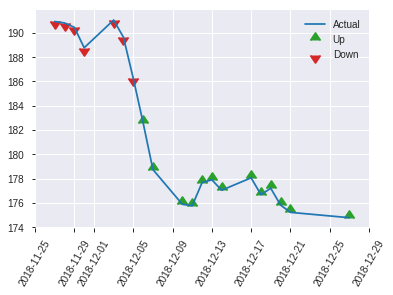


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5229708929541371
RMSE: 0.7231672648524248
LogLoss: 17.234149366685756
Null degrees of freedom: 248
Residual degrees of freedom: -738
Null deviance: 344.04650308459236
Residual deviance: 161457.73383307335
AIC: 163431.73383307335
AUC: 0.48668006222452687
pr_auc: 0.5043003966585428
Gini: -0.026639875550946268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.929273387026161e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    116  1        (116.0/116.0)
1      0    133  0        (0.0/133.0)
Total  0    249  0.4659   (116.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.92927e-53  0.696335  29
max f2                       6.92927e-53  0.851472  29
max f0point5                 6.92927e-53  0.589017  29
max accuracy                 6.92927e-53  0.534137  29
max precision                0.458344     1         0
max recall                   6.92927e-53  1         29
max specificity              0.458344     1         0
max absolute_mcc             0.00262429   0.125807  18
max min_per_class_accuracy   8.37706e-46  0.105263  28
max mean_per_class_accuracy  0.45455      0.507519  1

Gains/Lift Table: Avg response rate: 53.41 %, avg score:  1.71 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.452646           1.24812  1.24812            0.666667         0.455437      0.666667                    0.455437            0.0150376       0.0150376                  24.812    24.812
    2        0.0200803                   0.37784            0.93609  1.12331            0.5              0.438413      0.6                         0.448627            0.0075188       0.0225564                  -6.39098  12.3308
    3        0.0321285                   0.300303           0.62406  0.93609            0.333333         0.340784      0.5                         0.408186            0.0075188       0.0300752                  -37.594   -6.39098
    4        0.0401606                   0.159598           1.87218  1.12331            1                0.239907      0.6                         0.37453             0.0150376       0.0451128                  87.218    12.3308
    5        0.0522088                   0.0744303          0        0.864083           0                0.12797       0.461538                    0.317632            0               0.0451128                  -100      -13.5917
    6        0.100402                    1.62931e-20        0.62406  0.748872           0.333333         0.00996814    0.4                         0.169953            0.0300752       0.075188                   -37.594   -25.1128
    7        0.15261                     5.3408e-114        1.29612  0.93609            0.692308         3.11367e-29   0.5                         0.111811            0.0676692       0.142857                   29.6125   -6.39098
    8        0.200803                    7.32849e-303       1.09211  0.973534           0.583333         4.15796e-124  0.52                        0.0849766           0.0526316       0.195489                   9.21053   -2.64662
    9        1                           0                  1.00665  1                  0.537688         0             0.534137                    0.0170636           0.804511        1                          0.664979  0

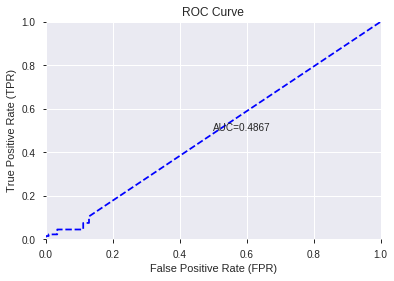

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


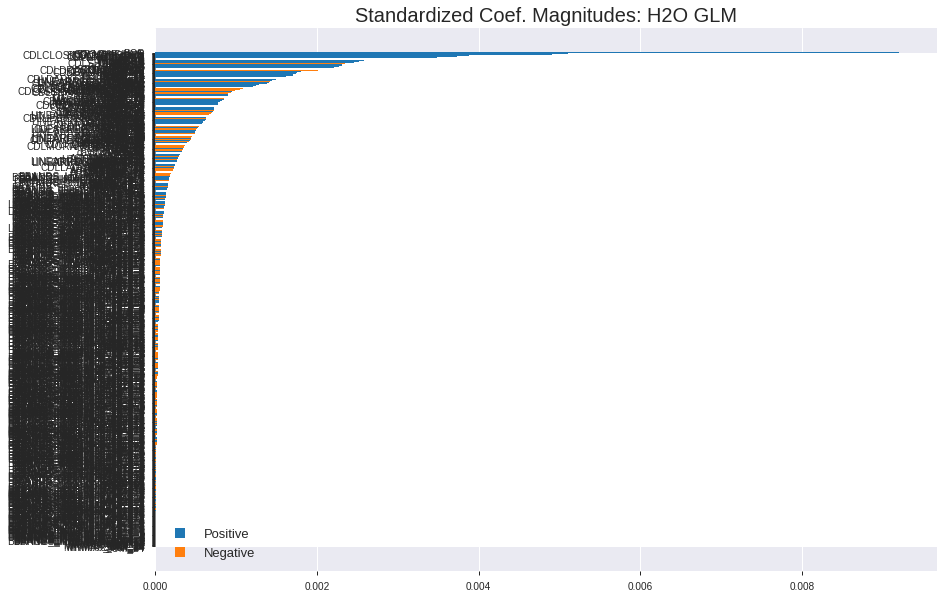

'log_likelihood'
--2019-08-28 12:33:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123314_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123314_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

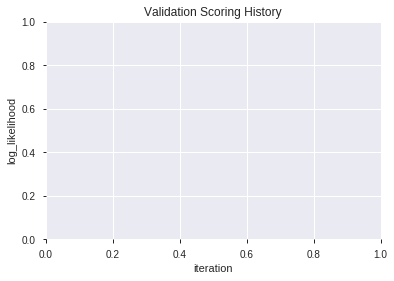

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123408_model_4  0.747407  0.600171              0.357110  0.454842  0.206881
1               XGBoost_2_AutoML_20190828_123408  0.743324  0.599528              0.326841  0.455028  0.207051
2  XGBoost_grid_1_AutoML_20190828_123408_model_2  0.739176  0.601043              0.319873  0.455719  0.207680
3               XGBoost_3_AutoML_20190828_123408  0.739176  0.599041              0.366833  0.454582  0.206645
4  XGBoost_grid_1_AutoML_20190828_123408_model_6  0.739046  0.600168              0.333355  0.454843  0.206882
5  XGBoost_grid_1_AutoML_20190828_123408_model_1  0.735027  0.597246              0.350694  0.455417  0.207404
6  XGBoost_grid_1_AutoML_20190828_123408_model_3  0.730166  0.604279              0.336563  0.457295  0.209119
7               XGBoost_1_AutoML_20190828_123408  0.729453  0.604713              0.310150  0.457913  0.209685
8  XGBoost_grid_1_AutoML_20190828_123408_model_7  0.728546  0.607542              0.345735  0.459362  0.211013
9  XGBoost_grid_1_AutoML_20190828_123408_model_5  0.701841  0.630338              0.382973  0.469901  0.220807

variable  relative_importance  scaled_importance  percentage
0                        BOP          2276.742432           1.000000    0.387362
1                     TRANGE           338.025879           0.148469    0.057511
2               STOCHF_fastk           232.218384           0.101996    0.039509
3                        DIV           109.960831           0.048297    0.018709
4                        SUB            93.734535           0.041170    0.015948
..                       ...                  ...                ...         ...
142               PLUS_DM_12             4.473158           0.001965    0.000761
143           MACDFIX_hist_8             4.041871           0.001775    0.000688
144              AROONOSC_12             4.004857           0.001759    0.000681
145  BBANDS_lowerband_24_1_2             3.393537           0.001491    0.000577
146                   NATR_8             3.285038           0.001443    0.000559

[147 rows x 4 columns]

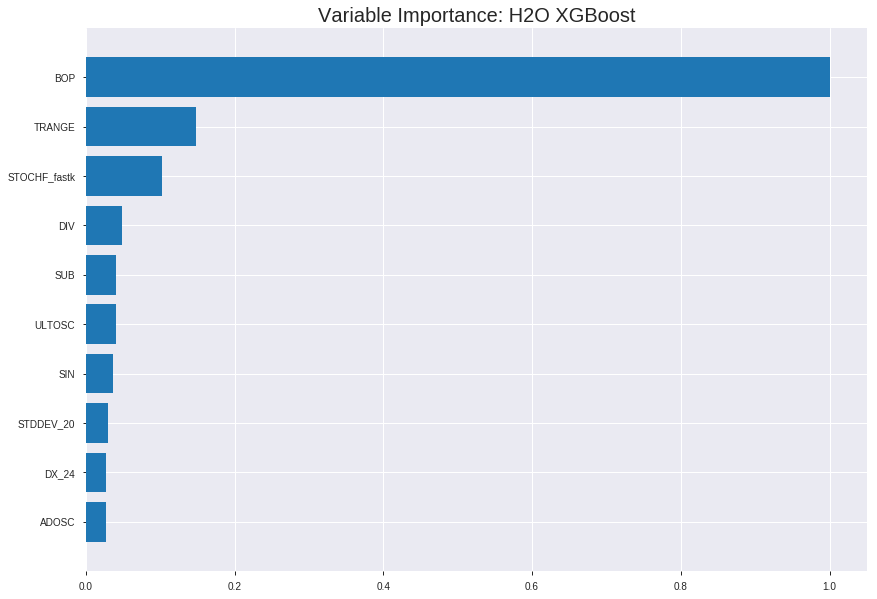

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123408_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16578205203991866
RMSE: 0.40716342178530557
LogLoss: 0.506209007575299
Mean Per-Class Error: 0.23157970012633788
AUC: 0.850154545382311
pr_auc: 0.8638039722726435
Gini: 0.7003090907646221
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5013612707455953: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      553  266   0.3248   (266.0/819.0)
1      152  770   0.1649   (152.0/922.0)
Total  705  1036  0.2401   (418.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501361     0.786517  214
max f2                       0.283675     0.885172  314
max f0point5                 0.603934     0.790266  159
max accuracy                 0.54569      0.769673  191
max precision                0.896863     1         0
max recall                   0.172169     1         363
max specificity              0.896863     1         0
max absolute_mcc             0.54569      0.537377  191
max min_per_class_accuracy   0.56253      0.763557  183
max mean_per_class_accuracy  0.54569      0.76842   191

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.872251           1.88829    1.88829            1                0.87982   1                           0.87982             0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.862494           1.88829    1.88829            1                0.868646  1                           0.874392            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.85336            1.88829    1.88829            1                0.858573  1                           0.86902             0.0195228       0.0574837                  88.8286   88.8286
    4        0.0402068                   0.841587           1.88829    1.88829            1                0.847539  1                           0.863803            0.0184382       0.0759219                  88.8286   88.8286
    5        0.0505457                   0.829595           1.78338    1.86683            0.944444         0.833574  0.988636                    0.85762             0.0184382       0.0943601                  78.3382   86.6829
    6        0.100517                    0.787577           1.82317    1.84513            0.965517         0.80727   0.977143                    0.832589            0.0911063       0.185466                   82.3173   84.5126
    7        0.150488                    0.759737           1.73636    1.80901            0.91954          0.773216  0.958015                    0.812874            0.0867679       0.272234                   73.6355   80.9007
    8        0.20046                     0.73219            1.56272    1.74761            0.827586         0.744346  0.925501                    0.795791            0.0780911       0.350325                   56.272    74.7612
    9        0.300402                    0.680374           1.53016    1.67527            0.810345         0.706172  0.887189                    0.765975            0.152928        0.503254                   53.0163   67.5267
    10       0.400345                    0.62478            1.31312    1.58486            0.695402         0.652191  0.839311                    0.73757             0.131236        0.63449                    31.3119   58.486
    11       0.500287                    0.571302           1.15034    1.49805            0.609195         0.596661  0.793341                    0.70942             0.114967        0.749458                   15.0335   49.8055
    12       0.60023                     0.49575            0.87903    1.39498            0.465517         0.534483  0.738756                    0.680292            0.0878525       0.83731                    -12.097   39.4983
    13       0.700172                    0.409962           0.737951   1.3012             0.390805         0.452817  0.689089                    0.647822            0.0737527       0.911063                   -26.2049  30.1198
    14       0.800115                    0.303402           0.607724   1.21458            0.321839         0.356075  0.643216                    0.61138             0.0607375       0.9718                     -39.2276  21.4576
    15       0.900057                    0.191929           0.238749   1.10622            0.126437         0.245187  0.585833                    0.570718            0.0238612       0.995662                   -76.1251  10.622
    16       1                           0.0932079          0.0434089  1                  0.0229885        0.152552  0.529581                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20455389632979712
RMSE: 0.45227634951409645
LogLoss: 0.5941200015789118
Mean Per-Class Error: 0.3187351471943354
AUC: 0.7440386698352652
pr_auc: 0.7516430005816778
Gini: 0.48807733967053046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28592121601104736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      20   241  0.0766   (20.0/261.0)
Total  106  392  0.3434   (171.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285921     0.738132  310
max f2                       0.202142     0.85906   352
max f0point5                 0.609563     0.702222  169
max accuracy                 0.500787     0.684739  241
max precision                0.886259     1         0
max recall                   0.129304     1         394
max specificity              0.886259     1         0
max absolute_mcc             0.476241     0.372113  249
max min_per_class_accuracy   0.584393     0.67433   195
max mean_per_class_accuracy  0.600244     0.681265  179

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 52.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.852626           1.90805   1.90805            1                0.875184  1                           0.875184            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.837055           1.52644   1.71724            0.8              0.847357  0.9                         0.86127             0.0153257       0.0344828                  52.6437   71.7241
    3        0.0301205                   0.827498           1.90805   1.78084            1                0.834135  0.933333                    0.852225            0.0191571       0.0536398                  90.8046   78.0843
    4        0.0401606                   0.818808           1.90805   1.81264            1                0.823105  0.95                        0.844945            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.80797            1.90805   1.83172            1                0.812848  0.96                        0.838526            0.0191571       0.091954                   90.8046   83.1724
    6        0.100402                    0.777082           1.60276   1.71724            0.84             0.794657  0.9                         0.816591            0.0804598       0.172414                   60.2759   71.7241
    7        0.150602                    0.737696           1.52644   1.65364            0.8              0.759864  0.866667                    0.797682            0.0766284       0.249042                   52.6437   65.364
    8        0.200803                    0.715748           1.29747   1.5646             0.68             0.727357  0.82                        0.780101            0.0651341       0.314176                   29.7471   56.4598
    9        0.301205                    0.671943           1.14483   1.42467            0.6              0.693865  0.746667                    0.751356            0.114943        0.429119                   14.4828   42.4674
    10       0.399598                    0.620033           1.32395   1.39987            0.693878         0.645571  0.733668                    0.725308            0.130268        0.559387                   32.395    39.9873
    11       0.5                         0.584806           1.10667   1.341              0.58             0.603154  0.702811                    0.700779            0.111111        0.670498                   10.6667   34.0996
    12       0.600402                    0.536397           0.877701  1.26352            0.46             0.559335  0.662207                    0.677126            0.0881226       0.758621                   -12.2299  26.3522
    13       0.698795                    0.373605           0.934553  1.2172             0.489796         0.464061  0.637931                    0.647126            0.091954        0.850575                   -6.54469  21.7202
    14       0.799197                    0.278615           0.801379  1.16496            0.42             0.324467  0.610553                    0.606591            0.0804598       0.931034                   -19.8621  16.4963
    15       0.899598                    0.196737           0.496092  1.09031            0.26             0.235469  0.571429                    0.565171            0.0498084       0.980843                   -50.3908  9.0312
    16       1                           0.10213            0.190805  1                  0.1              0.157693  0.524096                    0.524259           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:34:44  15.855 sec  0                  0.5              0.693147            0.5             0                  1                0.470419                         0.5                0.693147              0.5               0                    1                  0.475904
    2019-08-28 12:34:45  17.297 sec  5                  0.479683         0.653152            0.792413        0.791208           1.71662          0.310167                         0.48322            0.659982              0.72729           0.695785             1.52644            0.337349
    2019-08-28 12:34:46  17.760 sec  10                 0.462478         0.619704            0.805825        0.815722           1.88829          0.301551                         0.471073           0.635987              0.735632          0.740081             1.90805            0.321285
    2019-08-28 12:34:46  18.154 sec  15                 0.450032         0.595245            0.81168         0.821358           1.88829          0.283171                         0.463951           0.62148               0.737039          0.740635             1.90805            0.327309
    2019-08-28 12:34:46  18.551 sec  20                 0.440176         0.575431            0.816856        0.830096           1.88829          0.291212                         0.458676           0.610226              0.737257          0.739625             1.90805            0.331325
    2019-08-28 12:34:47  18.945 sec  25                 0.433142         0.560854            0.821754        0.831545           1.88829          0.284894                         0.455114           0.602554              0.743505          0.747287             1.90805            0.331325
    2019-08-28 12:34:47  19.350 sec  30                 0.427316         0.548422            0.825594        0.841298           1.88829          0.257898                         0.454273           0.599899              0.740102          0.743757             1.90805            0.329317
    2019-08-28 12:34:48  19.754 sec  35                 0.423211         0.539554            0.827751        0.843154           1.88829          0.27915                          0.452452           0.595605              0.743772          0.749589             1.90805            0.329317
    2019-08-28 12:34:48  20.152 sec  40                 0.419367         0.531557            0.833011        0.847532           1.88829          0.269385                         0.453161           0.59666               0.740983          0.744684             1.90805            0.329317
    2019-08-28 12:34:48  20.554 sec  45                 0.415841         0.524381            0.837856        0.851795           1.88829          0.26077                          0.452932           0.595918              0.741929          0.748982             1.90805            0.331325
    2019-08-28 12:34:49  20.971 sec  50                 0.412494         0.51758             0.843127        0.856813           1.88829          0.257323                         0.4533             0.596553              0.741226          0.748651             1.90805            0.335341
    2019-08-28 12:34:49  21.361 sec  55                 0.40966          0.511662            0.848122        0.86259            1.88829          0.25158                          0.452807           0.595458              0.741767          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2276.742431640625      1.0                    0.38736172433830857
TRANGE                   338.02587890625        0.14846909084163196    0.05751124303935553
STOCHF_fastk             232.2183837890625      0.10199589578594777    0.039509306067075145
DIV                      109.96083068847656     0.04829743986861025    0.018708579588630637
SUB                      93.73453521728516      0.041170460880697805   0.01594786071854998
---                      ---                    ---                    ---
PLUS_DM_12               4.47315788269043       0.001964718459376656   0.0007610567302634464
MACDFIX_hist_8           4.041871070861816      0.0017752869251658108  0.0006876782045274822
AROONOSC_12              4.004857063293457      0.0017590294833691614  0.0006813806938398024
BBANDS_lowerband_24_1_2  3.3935365676879883     0.0014905228279347344  0.0005773714927944108
NATR_8                   3.2850379943847656     0.001442867646656702   0.0005589116996008973


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6987951807228916)

('F1', 0.7469879518072289)

('auc', 0.7474073113819031)

('logloss', 0.6001712256131044)

('mean_per_class_error', 0.2968304381643765)

('rmse', 0.4548421770981861)

('mse', 0.20688140606741767)

xgboost prediction progress: |████████████████████████████████████████████| 100%


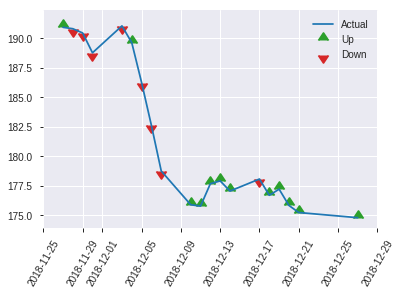


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20688140606741767
RMSE: 0.4548421770981861
LogLoss: 0.6001712256131044
Mean Per-Class Error: 0.2968304381643765
AUC: 0.7474073113819031
pr_auc: 0.7664935612560403
Gini: 0.49481462276380617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23492081463336945: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   75   0.6466   (75.0/116.0)
1      9    124  0.0677   (9.0/133.0)
Total  50   199  0.3373   (84.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234921     0.746988  198
max f2                       0.192841     0.859788  223
max f0point5                 0.595922     0.731497  111
max accuracy                 0.595922     0.698795  111
max precision                0.847435     1         0
max recall                   0.146565     1         246
max specificity              0.847435     1         0
max absolute_mcc             0.595922     0.40745   111
max min_per_class_accuracy   0.555985     0.655172  127
max mean_per_class_accuracy  0.595922     0.70317   111

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.830077           1.87218   1.87218            1                0.838181  1                           0.838181            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.821439           1.87218   1.87218            1                0.826197  1                           0.833387            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.805747           1.87218   1.87218            1                0.812337  1                           0.825493            0.0225564       0.0601504                  87.218    87.218
    4        0.0401606                   0.801138           1.87218   1.87218            1                0.803454  1                           0.821086            0.0150376       0.075188                   87.218    87.218
    5        0.0522088                   0.80012            1.24812   1.72817            0.666667         0.800811  0.923077                    0.816407            0.0150376       0.0902256                  24.812    72.8167
    6        0.100402                    0.765618           1.71617   1.72241            0.916667         0.784881  0.92                        0.801274            0.0827068       0.172932                   71.6165   72.2406
    7        0.15261                     0.74184            1.44014   1.62584            0.769231         0.754639  0.868421                    0.78532             0.075188        0.24812                    44.0139   62.5841
    8        0.200803                    0.711802           1.40414   1.57263            0.75             0.729249  0.84                        0.771863            0.0676692       0.315789                   40.4135   57.2632
    9        0.301205                    0.663898           1.27308   1.47278            0.68             0.686115  0.786667                    0.74328             0.12782         0.443609                   27.3083   47.2782
    10       0.401606                    0.622359           1.1982    1.40414            0.64             0.642819  0.75                        0.718165            0.120301        0.56391                    19.8195   40.4135
    11       0.502008                    0.565156           0.898647  1.30304            0.48             0.594723  0.696                       0.693477            0.0902256       0.654135                   -10.1353  30.3038
    12       0.598394                    0.526938           0.93609   1.24393            0.5              0.544432  0.66443                     0.66947             0.0902256       0.744361                   -6.39098  24.3932
    13       0.698795                    0.314695           0.973534  1.20508            0.52             0.426362  0.643678                    0.63454             0.0977444       0.842105                   -2.64662  20.5082
    14       0.799197                    0.233827           0.898647  1.16658            0.48             0.267199  0.623116                    0.588392            0.0902256       0.932331                   -10.1353  16.6585
    15       0.899598                    0.19281            0.449323  1.08653            0.24             0.210914  0.580357                    0.546263            0.0451128       0.977444                   -55.0677  8.65333
    16       1                           0.107029           0.224662  1                  0.12             0.169218  0.534137                    0.508407            0

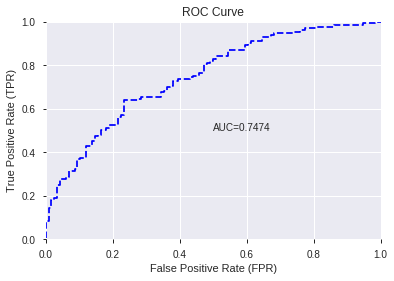

This function is available for GLM models only


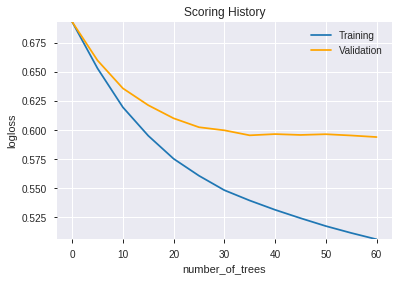

--2019-08-28 12:35:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123408_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123408_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_123525_model_6  0.732694  0.597587              0.333355  0.452682  0.204921
1  DeepLearning_grid_1_AutoML_20190828_123525_model_5  0.728740  0.604134              0.302534  0.457434  0.209246
2  DeepLearning_grid_1_AutoML_20190828_123525_model_9  0.723749  0.614420              0.305743  0.460883  0.212413
3  DeepLearning_grid_1_AutoML_20190828_123525_model_7  0.722064  0.697623              0.334911  0.474307  0.224967
4  DeepLearning_grid_1_AutoML_20190828_123525_model_8  0.718564  0.607688              0.309048  0.458508  0.210229
5               DeepLearning_1_AutoML_20190828_123525  0.718369  0.620728              0.360319  0.461809  0.213267
6  DeepLearning_grid_1_AutoML_20190828_123525_model_4  0.697239  0.774901              0.340874  0.488063  0.238205
7  DeepLearning_grid_1_AutoML_20190828_123525_model_3  0.685637  0.746855              0.366736  0.495936  0.245952
8  DeepLearning_grid_1_AutoML_20190828_123525_model_1  0.664895  0.883250              0.387283  0.522965  0.273492
9  DeepLearning_grid_1_AutoML_20190828_123525_model_2  0.661525  0.892637              0.405626  0.517001  0.267290

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.064214
1   CDLCLOSINGMARUBOZU             0.632662           0.632662    0.040626
2                  SUB             0.593324           0.593324    0.038100
3            STDDEV_20             0.423679           0.423679    0.027206
4          CDLLONGLINE             0.412082           0.412082    0.026462
5               ULTOSC             0.370568           0.370568    0.023796
6         STOCHF_fastk             0.367729           0.367729    0.023613
7               SAREXT             0.357398           0.357398    0.022950
8         aroondown_30             0.343814           0.343814    0.022078
9       STOCHRSI_fastd             0.328782           0.328782    0.021112
10        aroondown_14             0.326417           0.326417    0.020961
11               CCI_8             0.317419           0.317419    0.020383
12               ADOSC             0.313770           0.313770    0.020149
13             quarter             0.310461           0.310461    0.019936
14         MACD_signal             0.298553           0.298553    0.019171
15         CDLBELTHOLD             0.296652           0.296652    0.019049
16             CDLDOJI             0.293055           0.293055    0.018818
17   CDLLONGLEGGEDDOJI             0.292878           0.292878    0.018807
18             WILLR_8             0.291899           0.291899    0.018744
19   MACDFIX_signal_24             0.289871           0.289871    0.018614
20        STOCHF_fastd             0.289192           0.289192    0.018570
21   LINEARREG_SLOPE_8             0.287001           0.287001    0.018430
22          ROCR100_12             0.282146           0.282146    0.018118
23   MACDFIX_signal_14             0.278351           0.278351    0.017874
24      STOCHRSI_fastk             0.277886           0.277886    0.017844
25             ROCP_12             0.275010           0.275010    0.017660
26             BETA_20             0.273551           0.273551    0.017566
27              MOM_12             0.273147           0.273147    0.017540
28          MACDFIX_12             0.271900           0.271900    0.017460
29          aroonup_30             0.269032           0.269032    0.017276
30            WILLR_30             0.267999           0.267999    0.017209
31             ROCR_12             0.263836           0.263836    0.016942
32             weekday             0.262138           0.262138    0.016833
33           ROCR100_8             0.256672           0.256672    0.016482
34            WILLR_20             0.256522           0.256522    0.016472
35            WILLR_12             0.252675           0.252675    0.016225
36               ROC_8             0.248513           0.248513    0.015958
37               MOM_8             0.248440           0.248440    0.015953
38              ROCR_8             0.246350           0.246350    0.015819
39              ROCP_8             0.244853           0.244853    0.015723
40              CMO_20             0.243379           0.243379    0.015628
41            WILLR_24             0.242858           0.242858    0.015595
42              MOM_14             0.242008           0.242008    0.015540
43              ROC_14             0.241970           0.241970    0.015538
44          ROCR100_14             0.241503           0.241503    0.015508
45            WILLR_14             0.239821           0.239821    0.015400
46               RSI_8             0.237069           0.237069    0.015223
47               CMO_8             0.234911           0.234911    0.015085
48              RSI_14             0.234406           0.234406    0.015052
49              RSI_12             0.228720           0.228720    0.014687

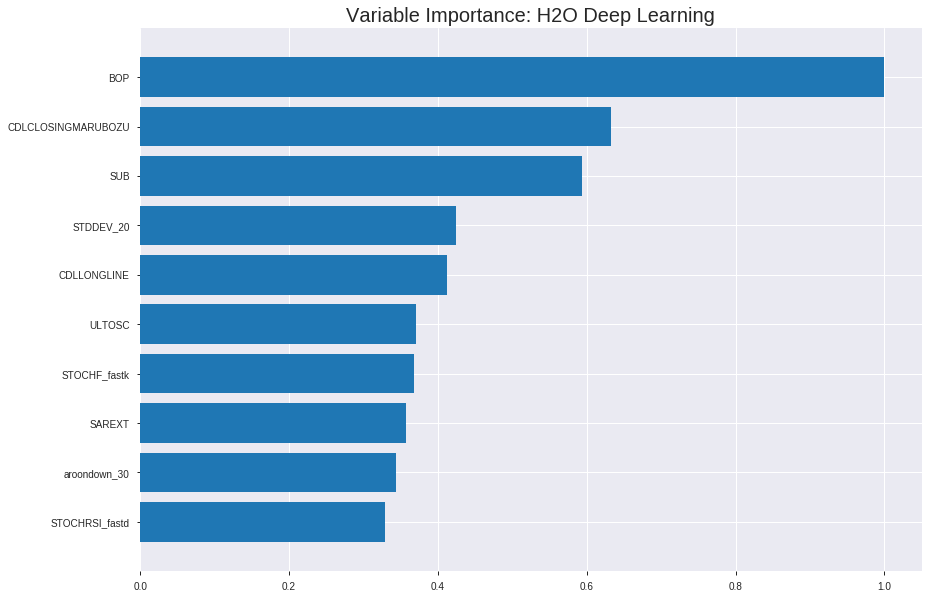

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_123525_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18866881633674953
RMSE: 0.434360237978512
LogLoss: 0.5569175377952468
Mean Per-Class Error: 0.27878954017782653
AUC: 0.7898924406516598
pr_auc: 0.7925053479156253
Gini: 0.5797848813033195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4598812012915637: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      404  415   0.5067   (415.0/819.0)
1      89   833   0.0965   (89.0/922.0)
Total  493  1248  0.2895   (504.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459881     0.767742  248
max f2                       0.30664      0.865927  308
max f0point5                 0.610716     0.734221  176
max accuracy                 0.597625     0.724871  186
max precision                0.997091     1         0
max recall                   0.140632     1         378
max specificity              0.997091     1         0
max absolute_mcc             0.597625     0.446694  186
max min_per_class_accuracy   0.61619      0.709402  171
max mean_per_class_accuracy  0.597625     0.72121   186

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 56.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.94944            1.88829   1.88829            1                0.966207  1                           0.966207            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.926995           1.77721   1.83434            0.941176         0.93891   0.971429                    0.952948            0.0173536       0.0368764                  77.7211   83.4335
    3        0.0304423                   0.898483           1.78338   1.81703            0.944444         0.91223   0.962264                    0.939119            0.0184382       0.0553145                  78.3382   81.703
    4        0.0402068                   0.884321           1.88829   1.83434            1                0.891464  0.971429                    0.927546            0.0184382       0.0737527                  88.8286   83.4335
    5        0.0505457                   0.865425           1.57357   1.781              0.833333         0.873033  0.943182                    0.916396            0.016269        0.0900217                  57.3572   78.0997
    6        0.100517                    0.790419           1.64954   1.71564            0.873563         0.822172  0.908571                    0.869553            0.0824295       0.172451                   64.9537   71.5643
    7        0.150488                    0.7427             1.4759    1.63603            0.781609         0.76184   0.866412                    0.833786            0.0737527       0.246204                   47.5902   63.6034
    8        0.20046                     0.713021           1.28056   1.54742            0.678161         0.72568   0.819484                    0.806837            0.0639913       0.310195                   28.0562   54.7421
    9        0.300402                    0.677388           1.46505   1.52002            0.775862         0.693511  0.804971                    0.769134            0.146421        0.456616                   46.505    52.0016
    10       0.400345                    0.646578           1.29141   1.46295            0.683908         0.661774  0.774749                    0.742332            0.129067        0.585683                   29.1414   46.2948
    11       0.500287                    0.619262           1.12863   1.39616            0.597701         0.632168  0.73938                     0.720325            0.112798        0.698482                   12.8631   39.6161
    12       0.60023                     0.584546           1.03096   1.33535            0.545977         0.604708  0.707177                    0.701074            0.103037        0.801518                   3.09609   33.5353
    13       0.700172                    0.476223           0.889882  1.27177            0.471264         0.539045  0.673503                    0.677946            0.0889371       0.890456                   -11.0118  27.1766
    14       0.800115                    0.347386           0.575168  1.18475            0.304598         0.416445  0.627423                    0.645282            0.0574837       0.947939                   -42.4832  18.4754
    15       0.900057                    0.233153           0.368975  1.09417            0.195402         0.289433  0.579451                    0.605768            0.0368764       0.984816                   -63.1025  9.41697
    16       1                           0.00948548         0.151931  1                  0.0804598        0.161946  0.529581                    0.561411          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2139714299375471
RMSE: 0.4625704594302873
LogLoss: 0.6155446871272789
Mean Per-Class Error: 0.3170861826470731
AUC: 0.7214139062676819
pr_auc: 0.7238873547666342
Gini: 0.44282781253536374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3100926320720521: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   166  0.7004   (166.0/237.0)
1      17   244  0.0651   (17.0/261.0)
Total  88   410  0.3675   (183.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310093     0.727273  323
max f2                       0.150898     0.851343  384
max f0point5                 0.63574      0.697264  168
max accuracy                 0.582062     0.686747  223
max precision                0.977441     1         0
max recall                   0.0804161    1         396
max specificity              0.977441     1         0
max absolute_mcc             0.582062     0.371245  223
max min_per_class_accuracy   0.614202     0.675105  194
max mean_per_class_accuracy  0.582062     0.682914  223

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 55.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.950287           1.90805   1.90805            1                0.964968  1                           0.964968            0.0191571       0.0191571                  90.8046    90.8046
    2        0.0200803                   0.930381           1.90805   1.90805            1                0.943984  1                           0.954476            0.0191571       0.0383142                  90.8046    90.8046
    3        0.0301205                   0.908409           1.90805   1.90805            1                0.924309  1                           0.94442             0.0191571       0.0574713                  90.8046    90.8046
    4        0.0401606                   0.881467           0.763218  1.62184            0.4              0.896451  0.85                        0.932428            0.00766284      0.0651341                  -23.6782   62.1839
    5        0.0502008                   0.854309           1.52644   1.60276            0.8              0.871039  0.84                        0.92015             0.0153257       0.0804598                  52.6437    60.2759
    6        0.100402                    0.773274           1.67908   1.64092            0.88             0.823451  0.86                        0.871801            0.0842912       0.164751                   67.908     64.092
    7        0.150602                    0.735521           1.37379   1.55188            0.72             0.752192  0.813333                    0.831931            0.0689655       0.233716                   37.3793    55.1877
    8        0.200803                    0.708272           0.992184  1.41195            0.52             0.722297  0.74                        0.804523            0.0498084       0.283525                   -0.781609  41.1954
    9        0.301205                    0.672456           1.14483   1.32291            0.6              0.68927   0.693333                    0.766105            0.114943        0.398467                   14.4828    32.2912
    10       0.399598                    0.645821           1.55759   1.3807             0.816327         0.65959   0.723618                    0.739878            0.153257        0.551724                   55.7589    38.0697
    11       0.5                         0.616401           1.10667   1.32567            0.58             0.631418  0.694779                    0.718099            0.111111        0.662835                   10.6667    32.567
    12       0.600402                    0.576192           0.992184  1.2699             0.52             0.599318  0.665552                    0.698236            0.0996169       0.762452                   -0.781609  26.9904
    13       0.698795                    0.459294           0.700915  1.18979            0.367347         0.519592  0.623563                    0.673082            0.0689655       0.831418                   -29.9085   18.9787
    14       0.799197                    0.343086           0.801379  1.14099            0.42             0.389096  0.59799                     0.637405            0.0804598       0.911877                   -19.8621   14.0992
    15       0.899598                    0.23026            0.572414  1.07753            0.3              0.283456  0.564732                    0.597902            0.0574713       0.969349                   -42.7586   7.75349
    16       1                           0.030294           0.305287  1                  0.16             0.159522  0.524096                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:39:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:39:40  2 min 22.619 sec  887 obs/sec       1         1             1741       0.485659         0.753685            0.0532276      0.718394        0.705019           1.57357          0.33027                          0.510918           0.828741              -0.0465789       0.672422          0.650298             1.90805            0.389558
    2019-08-28 12:39:46  2 min 28.749 sec  1615 obs/sec      7         7             12187      0.454655         0.600667            0.17025        0.75179         0.752184           1.78338          0.311315                         0.467632           0.625121              0.123243         0.714026          0.723451             1.90805            0.38755
    2019-08-28 12:39:51  2 min 34.370 sec  2206 obs/sec      16        16            27856      0.448853         0.587165            0.191294       0.760052        0.761577           1.88829          0.291786                         0.466282           0.622332              0.128298         0.722416          0.731785             1.90805            0.369478
    2019-08-28 12:39:57  2 min 40.123 sec  2540 obs/sec      26        26            45266      0.438933         0.565462            0.226646       0.7809          0.780957           1.88829          0.285468                         0.463965           0.618472              0.13694          0.730289          0.735325             1.90805            0.361446
    2019-08-28 12:40:03  2 min 45.772 sec  2734 obs/sec      36        36            62676      0.43436          0.556918            0.242674       0.789892        0.792505           1.88829          0.289489                         0.46257            0.615545              0.142122         0.721414          0.723887             1.90805            0.36747
    2019-08-28 12:40:08  2 min 51.358 sec  2866 obs/sec      46        46            80086      0.428262         0.543157            0.263791       0.798573        0.800384           1.78338          0.281447                         0.463379           0.62199               0.139121         0.727719          0.731512             1.90805            0.363454
    2019-08-28 12:40:14  2 min 57.376 sec  2970 obs/sec      57        57            99237      0.4269           0.541391            0.268464       0.807047        0.808751           1.78338          0.281447                         0.463641           0.61981               0.138145         0.720476          0.726248             1.90805            0.345382
    2019-08-28 12:40:15  2 min 57.946 sec  2968 obs/sec      57        57            99237      0.43436          0.556918            0.242674       0.789892        0.792505           1.88829          0.289489                         0.46257            0.615545              0.142122         0.721414          0.723887             1.90805            0.36747

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06421422185698161
CDLCLOSINGMARUBOZU  0.6326622366905212     0.6326622366905212   0.040625913227379344
SUB                 0.5933242440223694     0.5933242440223694   0.038099854638778324
STDDEV_20           0.42367929220199585    0.42367929220199585  0.0272062360656679
CDLLONGLINE         0.4120822548866272     0.4120822548866272   0.026461541338615124
---                 ---                    ---                  ---
WILLR_14            0.2398211807012558     0.2398211807012558   0.015399930503553717
RSI_8               0.2370685189962387     0.2370685189962387   0.015223170474130533
CMO_8               0.23491080105304718    0.23491080105304718  0.015084614295421642
RSI_14              0.23440636694431305    0.23440636694431305  0.01505222245165116
RSI_12              0.22872035205364227    0.22872035205364227  0.014687099429979525


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7108433734939759)

('F1', 0.7523510971786833)

('auc', 0.7326938034742028)

('logloss', 0.5975870589905452)

('mean_per_class_error', 0.2960202229712212)

('rmse', 0.4526819394997655)

('mse', 0.20492093834926933)

deeplearning prediction progress: |███████████████████████████████████████| 100%


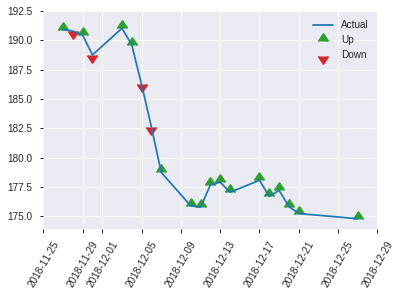


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20492093834926933
RMSE: 0.4526819394997655
LogLoss: 0.5975870589905452
Mean Per-Class Error: 0.2960202229712212
AUC: 0.7326938034742028
pr_auc: 0.736643195432765
Gini: 0.46538760694840553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3497105900776887: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   66   0.569    (66.0/116.0)
1      13   120  0.0977   (13.0/133.0)
Total  63   186  0.3173   (79.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349711     0.752351  185
max f2                       0.230137     0.85676   214
max f0point5                 0.564544     0.718121  152
max accuracy                 0.564544     0.710843  152
max precision                0.953325     1         0
max recall                   0.0708466    1         247
max specificity              0.953325     1         0
max absolute_mcc             0.547696     0.418666  154
max min_per_class_accuracy   0.612901     0.661654  126
max mean_per_class_accuracy  0.564544     0.70398   152

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 53.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.917227           1.87218   1.87218            1                0.936127  1                           0.936127            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.880993           1.87218   1.87218            1                0.893984  1                           0.91927             0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.856518           1.87218   1.87218            1                0.873121  1                           0.901964            0.0225564       0.0601504                  87.218    87.218
    4        0.0401606                   0.810473           0.93609   1.68496            0.5              0.826115  0.9                         0.886794            0.0075188       0.0676692                  -6.39098  68.4962
    5        0.0522088                   0.80533            1.24812   1.58415            0.666667         0.808203  0.846154                    0.868658            0.0150376       0.0827068                  24.812    58.4153
    6        0.100402                    0.741468           1.56015   1.57263            0.833333         0.776858  0.84                        0.824594            0.075188        0.157895                   56.015    57.2632
    7        0.15261                     0.710192           1.29612   1.47804            0.692308         0.722895  0.789474                    0.789802            0.0676692       0.225564                   29.6125   47.8037
    8        0.200803                    0.693116           1.56015   1.49774            0.833333         0.697824  0.8                         0.767727            0.075188        0.300752                   56.015    49.7744
    9        0.301205                    0.664763           1.1982    1.39789            0.64             0.678943  0.746667                    0.738133            0.120301        0.421053                   19.8195   39.7895
    10       0.401606                    0.648063           1.04842   1.31053            0.56             0.655413  0.7                         0.717453            0.105263        0.526316                   4.84211   31.0526
    11       0.502008                    0.617108           1.1982    1.28806            0.64             0.633505  0.688                       0.700663            0.120301        0.646617                   19.8195   28.806
    12       0.598394                    0.578946           1.32613   1.29419            0.708333         0.602043  0.691275                    0.684778            0.12782         0.774436                   32.6128   29.4192
    13       0.698795                    0.428075           0.748872  1.21584            0.4              0.504715  0.649425                    0.658907            0.075188        0.849624                   -25.1128  21.5841
    14       0.799197                    0.301424           0.599098  1.13836            0.32             0.352834  0.60804                     0.620456            0.0601504       0.909774                   -40.0902  13.8361
    15       0.899598                    0.195685           0.599098  1.07818            0.32             0.23948   0.575893                    0.577936            0.0601504       0.969925                   -40.0902  7.81753
    16       1                           0.0533604          0.299549  1                  0.16             0.133234  0.534137                    0.533287            0

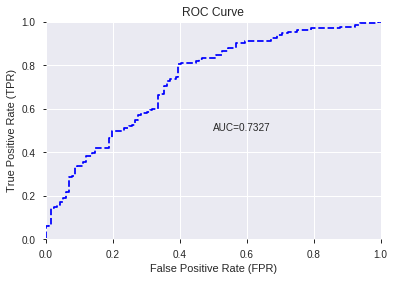

This function is available for GLM models only


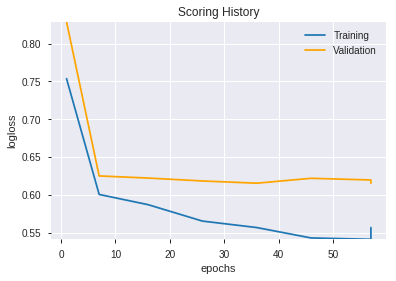

--2019-08-28 12:44:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_123525_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_123525_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STDDEV_20',
 'CDLLONGLINE',
 'ULTOSC',
 'STOCHF_fastk',
 'SAREXT',
 'aroondown_30',
 'STOCHRSI_fastd',
 'aroondown_14',
 'CCI_8',
 'ADOSC',
 'quarter',
 'MACD_signal',
 'CDLBELTHOLD',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'WILLR_8',
 'MACDFIX_signal_24',
 'STOCHF_fastd',
 'LINEARREG_SLOPE_8',
 'ROCR100_12',
 'MACDFIX_signal_14',
 'STOCHRSI_fastk',
 'ROCP_12',
 'BETA_20',
 'MOM_12',
 'MACDFIX_12',
 'aroonup_30',
 'WILLR_30',
 'ROCR_12',
 'weekday',
 'ROCR100_8',
 'WILLR_20',
 'WILLR_12',
 'ROC_8',
 'MOM_8',
 'ROCR_8',
 'ROCP_8',
 'CMO_20',
 'WILLR_24',
 'MOM_14',
 'ROC_14',
 'ROCR100_14',
 'WILLR_14',
 'RSI_8',
 'CMO_8',
 'RSI_14',
 'RSI_12']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_124421_model_1  0.731203  0.61061              0.364629  0.45921  0.210874

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.819183           1.000000    0.133120
1         STOCHF_fastk             0.460370           0.561987    0.074812
2         STOCHF_fastd             0.330462           0.403405    0.053701
3                CCI_8             0.297469           0.363128    0.048340
4                  SUB             0.296061           0.361411    0.048111
5               CMO_20             0.268453           0.327708    0.043624
6       STOCHRSI_fastk             0.261957           0.319778    0.042569
7               ULTOSC             0.241177           0.294412    0.039192
8              WILLR_8             0.195382           0.238508    0.031750
9               MOM_14             0.186573           0.227755    0.030319
10               MOM_8             0.181006           0.220960    0.029414
11          ROCR100_14             0.154979           0.189188    0.025185
12              ROC_14             0.154480           0.188578    0.025104
13          MACDFIX_12             0.148116           0.180809    0.024069
14               RSI_8             0.142605           0.174082    0.023174
15               CMO_8             0.138721           0.169341    0.022543
16   MACDFIX_signal_24             0.124259           0.151686    0.020192
17        aroondown_14             0.123307           0.150525    0.020038
18  CDLCLOSINGMARUBOZU             0.121880           0.148783    0.019806
19            WILLR_14             0.120408           0.146985    0.019567
20         CDLLONGLINE             0.106344           0.129817    0.017281
21         CDLBELTHOLD             0.101318           0.123681    0.016464
22              RSI_14             0.087697           0.107054    0.014251
23            WILLR_24             0.081948           0.100037    0.013317
24         MACD_signal             0.079841           0.097465    0.012975
25             CDLDOJI             0.076377           0.093236    0.012412
26        aroondown_30             0.071206           0.086923    0.011571
27      STOCHRSI_fastd             0.070777           0.086400    0.011502
28             quarter             0.066020           0.080593    0.010729
29            WILLR_20             0.065316           0.079733    0.010614
30              SAREXT             0.061129           0.074622    0.009934
31           STDDEV_20             0.059509           0.072644    0.009670
32   LINEARREG_SLOPE_8             0.054852           0.066960    0.008914
33               ADOSC             0.042464           0.051836    0.006900
34            WILLR_12             0.039729           0.048498    0.006456
35              MOM_12             0.036639           0.044726    0.005954
36          ROCR100_12             0.036020           0.043970    0.005853
37             ROCR_12             0.035710           0.043593    0.005803
38             ROCP_12             0.035116           0.042868    0.005707
39             weekday             0.033739           0.041186    0.005483
40            WILLR_30             0.025567           0.031210    0.004155
41           ROCR100_8             0.020060           0.024488    0.003260
42              ROCR_8             0.020047           0.024472    0.003258
43               ROC_8             0.019874           0.024261    0.003230
44              ROCP_8             0.019687           0.024033    0.003199
45   MACDFIX_signal_14             0.011126           0.013582    0.001808
46   CDLLONGLEGGEDDOJI             0.010003           0.012211    0.001626
47              RSI_12             0.008007           0.009775    0.001301
48             BETA_20             0.007430           0.009070    0.001207
49          aroonup_30             0.003320           0.004052    0.000539

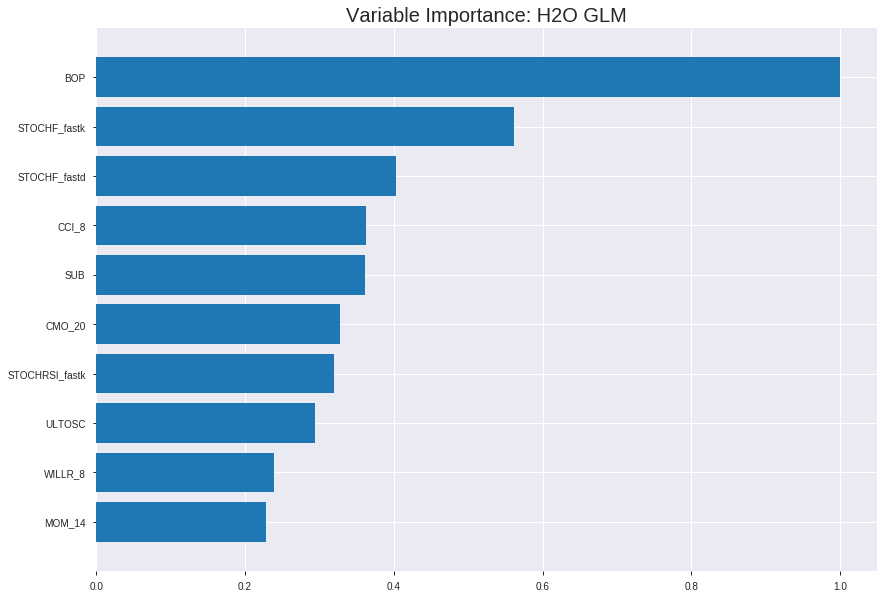

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_124421_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19407294418404789
RMSE: 0.4405371087480008
LogLoss: 0.5716073050529222
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2407.4412986831494
Residual deviance: 1990.3366361942753
AIC: 2092.3366361942753
AUC: 0.7692830789360074
pr_auc: 0.76715306618965
Gini: 0.5385661578720149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31866114399839857: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      321  498   0.6081   (498.0/819.0)
1      61   861   0.0662   (61.0/922.0)
Total  382  1359  0.3211   (559.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318661     0.754932  293
max f2                       0.187989     0.86099   350
max f0point5                 0.484789     0.721059  219
max accuracy                 0.484789     0.714532  219
max precision                0.916238     1         0
max recall                   0.0567165    1         393
max specificity              0.916238     1         0
max absolute_mcc             0.476342     0.426662  222
max min_per_class_accuracy   0.558444     0.692308  183
max mean_per_class_accuracy  0.484789     0.709676  219

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.884856           1.78338   1.78338            0.944444         0.898229  0.944444                    0.898229            0.0184382       0.0184382                  78.3382   78.3382
    2        0.0201034                   0.872802           1.77721   1.78038            0.941176         0.879643  0.942857                    0.889202            0.0173536       0.0357918                  77.7211   78.0384
    3        0.0304423                   0.861806           1.57357   1.71015            0.833333         0.86733   0.90566                     0.881773            0.016269        0.0520607                  57.3572   71.0146
    4        0.0402068                   0.854158           1.55506   1.67248            0.823529         0.856901  0.885714                    0.875733            0.0151844       0.0672451                  55.5059   67.2482
    5        0.0505457                   0.842736           1.57357   1.65225            0.833333         0.847684  0.875                       0.869996            0.016269        0.0835141                  57.3572   65.2251
    6        0.100517                    0.803852           1.54102   1.59695            0.816092         0.821736  0.845714                    0.846004            0.0770065       0.160521                   54.1015   59.6951
    7        0.150488                    0.772955           1.62783   1.60721            0.862069         0.788582  0.851145                    0.826936            0.0813449       0.241866                   62.7833   60.7206
    8        0.20046                     0.743661           1.41079   1.55824            0.747126         0.7581    0.825215                    0.809776            0.0704989       0.312364                   41.0789   55.8242
    9        0.300402                    0.690088           1.30227   1.47308            0.689655         0.715784  0.780115                    0.778506            0.130152        0.442516                   30.2266   47.308
    10       0.400345                    0.639059           1.33482   1.43857            0.706897         0.66518   0.761836                    0.750215            0.133406        0.575922                   33.4823   43.8565
    11       0.500287                    0.566064           1.03096   1.35714            0.545977         0.607196  0.718714                    0.721644            0.103037        0.678959                   3.09609   35.7138
    12       0.60023                     0.476154           1.18289   1.32812            0.626437         0.526268  0.703349                    0.689112            0.118221        0.79718                    18.2892   32.8125
    13       0.700172                    0.38451            0.705394  1.23924            0.373563         0.428536  0.656276                    0.651918            0.0704989       0.867679                   -29.4606  23.9236
    14       0.800115                    0.29914            0.748803  1.17798            0.396552         0.344539  0.623833                    0.613523            0.0748373       0.942516                   -25.1197  17.7976
    15       0.900057                    0.19869            0.368975  1.08814            0.195402         0.252266  0.57626                     0.573409            0.0368764       0.979393                   -63.1025  8.81446
    16       1                           0.0253755          0.206192  1                  0.109195         0.134875  0.529581                    0.529581          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2058228260442314
RMSE: 0.453677006298789
LogLoss: 0.5972100329644614
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.27761756622
Residual deviance: 594.8211928326035
AIC: 696.8211928326035
AUC: 0.7402395848489257
pr_auc: 0.7406429599872485
Gini: 0.4804791696978514
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30313136977352817: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   151  0.6371   (151.0/237.0)
1      23   238  0.0881   (23.0/261.0)
Total  109  389  0.3494   (174.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303131     0.732308  309
max f2                       0.164364     0.857713  366
max f0point5                 0.586682     0.7173    178
max accuracy                 0.555998     0.700803  197
max precision                0.882729     1         0
max recall                   0.131821     1         381
max specificity              0.882729     1         0
max absolute_mcc             0.555998     0.401186  197
max min_per_class_accuracy   0.555998     0.700422  197
max mean_per_class_accuracy  0.555998     0.700786  197

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 51.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.873793           1.90805   1.90805            1                0.878588  1                           0.878588            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.863046           1.90805   1.90805            1                0.866552  1                           0.87257             0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.846702           1.52644   1.78084            0.8              0.856549  0.933333                    0.86723             0.0153257       0.0536398                  52.6437   78.0843
    4        0.0401606                   0.831634           1.90805   1.81264            1                0.83882   0.95                        0.860127            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.808196           1.90805   1.83172            1                0.825265  0.96                        0.853155            0.0191571       0.091954                   90.8046   83.1724
    6        0.100402                    0.762014           1.37379   1.60276            0.72             0.785555  0.84                        0.819355            0.0689655       0.16092                    37.3793   60.2759
    7        0.150602                    0.737742           1.29747   1.501              0.68             0.751774  0.786667                    0.796828            0.0651341       0.226054                   29.7471   50.0996
    8        0.200803                    0.712663           1.22115   1.43103            0.64             0.726147  0.75                        0.779158            0.0613027       0.287356                   22.1149   43.1034
    9        0.301205                    0.666807           1.45011   1.43739            0.76             0.686588  0.753333                    0.748301            0.145594        0.43295                    45.0115   43.7395
    10       0.399598                    0.629457           1.40183   1.42864            0.734694         0.649621  0.748744                    0.724003            0.137931        0.570881                   40.183    42.8637
    11       0.5                         0.559905           1.14483   1.37165            0.6              0.596894  0.718876                    0.698479            0.114943        0.685824                   14.4828   37.1648
    12       0.600402                    0.460704           0.725057  1.26352            0.38             0.510704  0.662207                    0.667079            0.0727969       0.758621                   -27.4943  26.3522
    13       0.698795                    0.374458           0.778794  1.19527            0.408163         0.417703  0.626437                    0.631965            0.0766284       0.835249                   -22.1206  19.527
    14       0.799197                    0.286933           0.763218  1.14099            0.4              0.332781  0.59799                     0.594379            0.0766284       0.911877                   -23.6782  14.0992
    15       0.899598                    0.190703           0.534253  1.07328            0.28             0.244322  0.5625                      0.55531             0.0536398       0.965517                   -46.5747  7.32759
    16       1                           0.0261076          0.343448  1                  0.18             0.133648  0.524096                    0.512975          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 12:44:21  0.000 sec   2            .21E2     51            1.359573744872776   1.3682079361936468
     2019-08-28 12:44:21  0.024 sec   4            .13E2     51            1.3500005305424179  1.3615062044883264
     2019-08-28 12:44:21  0.040 sec   6            .81E1     51            1.3382532673031355  1.3530397838108765
     2019-08-28 12:44:21  0.057 sec   8            .5E1      51            1.3243422419094855  1.3425774332075213
     2019-08-28 12:44:21  0.074 sec   10           .31E1     51            1.3083533575470558  1.3298821716303844
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 12:44:21  0.365 sec   38           .4E-2     51            1.1405843887277163  1.1950392917156287
     2019-08-28 12:44:21  0.387 sec   40           .25E-2    51            1.1385053052640566  1.1963355657838117
     2019-08-28 12:44:22  0.412 sec   42           .15E-2    51            1.1369799471067468  1.198096270076636
     2019-08-28 12:44:22  0.437 sec   44           .95E-3    51            1.1359342418477227  1.2000206149943897
     2019-08-28 12:44:22  0.450 sec   46           .59E-3    51            1.1352902790268835  1.2018321433422254


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7393939393939394)

('auc', 0.731203007518797)

('logloss', 0.6106096742078307)

('mean_per_class_error', 0.3066502463054187)

('rmse', 0.4592102864786048)

('mse', 0.21087408720776227)

glm prediction progress: |████████████████████████████████████████████████| 100%


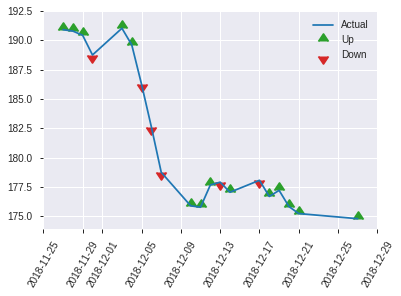


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21087408720776227
RMSE: 0.4592102864786048
LogLoss: 0.6106096742078307
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.04650308459236
Residual deviance: 304.08361775549974
AIC: 406.08361775549974
AUC: 0.731203007518797
pr_auc: 0.7309277253574472
Gini: 0.46240601503759393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24545214659145012: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   75   0.6466   (75.0/116.0)
1      11   122  0.0827   (11.0/133.0)
Total  52   197  0.3454   (86.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.245452     0.739394  196
max f2                       0.129697     0.865007  230
max f0point5                 0.519752     0.715421  123
max accuracy                 0.488229     0.694779  132
max precision                0.885598     1         0
max recall                   0.107316     1         238
max specificity              0.885598     1         0
max absolute_mcc             0.488229     0.3867    132
max min_per_class_accuracy   0.510794     0.681034  127
max mean_per_class_accuracy  0.488229     0.69335   132

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.845732           1.87218   1.87218            1                0.862805  1                           0.862805            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.834952           1.87218   1.87218            1                0.837359  1                           0.852627            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.815594           1.24812   1.63816            0.666667         0.823078  0.875                       0.841546            0.0150376       0.0526316                  24.812    63.8158
    4        0.0401606                   0.797864           1.87218   1.68496            1                0.808856  0.9                         0.835008            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.789552           1.87218   1.72817            1                0.793275  0.923077                    0.825377            0.0225564       0.0902256                  87.218    72.8167
    6        0.100402                    0.759922           1.09211   1.42286            0.583333         0.773323  0.76                        0.800391            0.0526316       0.142857                   9.21053   42.2857
    7        0.15261                     0.729435           1.72817   1.52731            0.923077         0.744207  0.815789                    0.78117             0.0902256       0.233083                   72.8167   52.7305
    8        0.200803                    0.696854           1.09211   1.42286            0.583333         0.710265  0.76                        0.764153            0.0526316       0.285714                   9.21053   42.2857
    9        0.301205                    0.667971           1.27308   1.37293            0.68             0.683452  0.733333                    0.737253            0.12782         0.413534                   27.3083   37.2932
    10       0.401606                    0.60358            1.27308   1.34797            0.68             0.640567  0.72                        0.713081            0.12782         0.541353                   27.3083   34.797
    11       0.502008                    0.518913           1.34797   1.34797            0.72             0.567227  0.72                        0.68391             0.135338        0.676692                   34.797    34.797
    12       0.598394                    0.409124           0.93609   1.28163            0.5              0.471844  0.684564                    0.649752            0.0902256       0.766917                   -6.39098  28.1627
    13       0.698795                    0.311592           0.599098  1.18356            0.32             0.361256  0.632184                    0.608301            0.0601504       0.827068                   -40.0902  18.3562
    14       0.799197                    0.229155           0.898647  1.14777            0.48             0.276425  0.613065                    0.566608            0.0902256       0.917293                   -10.1353  14.7769
    15       0.899598                    0.148359           0.524211  1.07818            0.28             0.186449  0.575893                    0.52418             0.0526316       0.969925                   -47.5789  7.81753
    16       1                           0.0503789          0.299549  1                  0.16             0.110516  0.534137                    0.482647            0

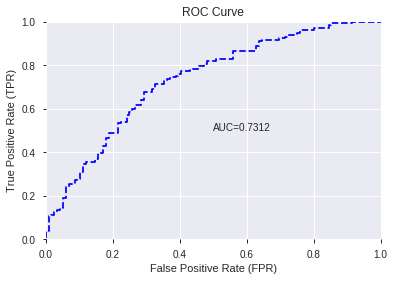

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


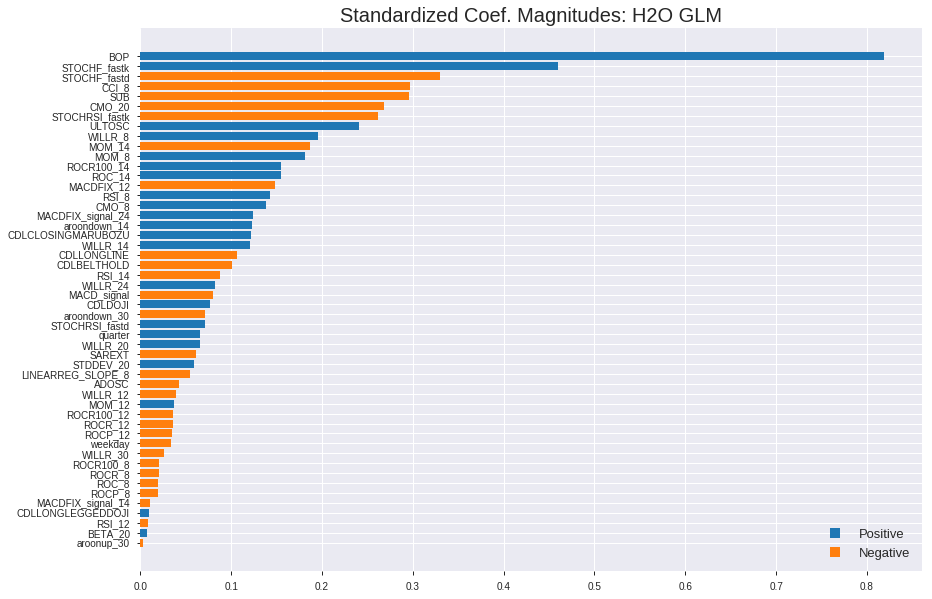

'log_likelihood'
--2019-08-28 12:44:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_124421_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_124421_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CCI_8',
 'SUB',
 'CMO_20',
 'STOCHRSI_fastk',
 'ULTOSC',
 'WILLR_8',
 'MOM_14',
 'MOM_8',
 'ROCR100_14',
 'ROC_14',
 'MACDFIX_12',
 'RSI_8',
 'CMO_8',
 'MACDFIX_signal_24',
 'aroondown_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_14',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'RSI_14',
 'WILLR_24',
 'MACD_signal',
 'CDLDOJI',
 'aroondown_30',
 'STOCHRSI_fastd',
 'quarter',
 'WILLR_20',
 'SAREXT',
 'STDDEV_20',
 'LINEARREG_SLOPE_8',
 'ADOSC',
 'WILLR_12',
 'MOM_12',
 'ROCR100_12',
 'ROCR_12',
 'ROCP_12',
 'weekday',
 'WILLR_30',
 'ROCR100_8',
 'ROCR_8',
 'ROC_8',
 'ROCP_8',
 'MACDFIX_signal_14',
 'CDLLONGLEGGEDDOJI',
 'RSI_12',
 'BETA_20',
 'aroonup_30']

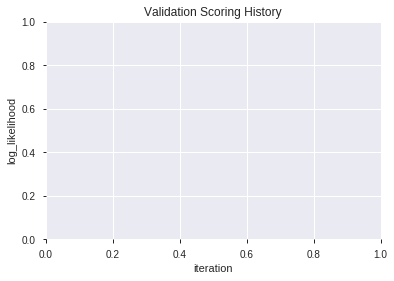

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_124437_model_7  0.733148  0.605452              0.361972  0.457542  0.209345
1  XGBoost_grid_1_AutoML_20190828_124437_model_4  0.733083  0.609434              0.327392  0.458492  0.210215
2  XGBoost_grid_1_AutoML_20190828_124437_model_1  0.731333  0.617156              0.326290  0.461051  0.212568
3               XGBoost_2_AutoML_20190828_124437  0.731073  0.609719              0.320327  0.458695  0.210401
4  XGBoost_grid_1_AutoML_20190828_124437_model_2  0.730425  0.604641              0.347388  0.457446  0.209257
5  XGBoost_grid_1_AutoML_20190828_124437_model_6  0.729777  0.605068              0.342527  0.457406  0.209220
6  XGBoost_grid_1_AutoML_20190828_124437_model_3  0.729647  0.606709              0.308951  0.457680  0.209471
7  XGBoost_grid_1_AutoML_20190828_124437_model_5  0.723036  0.624533              0.320878  0.466330  0.217463
8               XGBoost_3_AutoML_20190828_124437  0.721610  0.615405              0.334911  0.461837  0.213294
9               XGBoost_1_AutoML_20190828_124437  0.720379  0.620283              0.331702  0.463459  0.214795

variable  relative_importance  scaled_importance  percentage
0                  BOP          1920.311523           1.000000    0.196763
1         STOCHF_fastk           747.312012           0.389162    0.076573
2                  SUB           599.421021           0.312148    0.061419
3            STDDEV_20           471.510956           0.245539    0.048313
4         STOCHF_fastd           331.080048           0.172410    0.033924
5                CCI_8           291.413239           0.151753    0.029859
6                ADOSC           280.581177           0.146112    0.028750
7               ULTOSC           270.314301           0.140766    0.027698
8       STOCHRSI_fastd           266.674011           0.138870    0.027325
9       STOCHRSI_fastk           263.158356           0.137039    0.026964
10             BETA_20           235.337463           0.122552    0.024114
11   LINEARREG_SLOPE_8           212.741653           0.110785    0.021798
12   MACDFIX_signal_24           209.510162           0.109102    0.021467
13             WILLR_8           208.219238           0.108430    0.021335
14          MACDFIX_12           202.227936           0.105310    0.020721
15        aroondown_30           180.929916           0.094219    0.018539
16         MACD_signal           178.345779           0.092873    0.018274
17              SAREXT           177.010361           0.092178    0.018137
18            WILLR_20           172.614334           0.089889    0.017687
19             weekday           164.770035           0.085804    0.016883
20              MOM_12           155.876251           0.081172    0.015972
21            WILLR_12           144.040070           0.075009    0.014759
22             ROCP_12           141.430740           0.073650    0.014492
23        aroondown_14           140.970230           0.073410    0.014444
24               CMO_8           132.210632           0.068849    0.013547
25              MOM_14           131.251587           0.068349    0.013449
26              RSI_12           130.851028           0.068141    0.013408
27              CMO_20           118.638458           0.061781    0.012156
28   MACDFIX_signal_14           116.158188           0.060489    0.011902
29               MOM_8           113.197571           0.058948    0.011599
30            WILLR_14           111.438927           0.058032    0.011419
31            WILLR_30           105.223335           0.054795    0.010782
32              ROC_14           102.361435           0.053305    0.010488
33               ROC_8            94.680367           0.049305    0.009701
34             quarter            90.710114           0.047237    0.009295
35          aroonup_30            88.083969           0.045870    0.009025
36            WILLR_24            80.665421           0.042006    0.008265
37  CDLCLOSINGMARUBOZU            58.395630           0.030409    0.005983
38          ROCR100_14            53.984768           0.028113    0.005532
39               RSI_8            48.811806           0.025419    0.005001
40              RSI_14            46.468136           0.024198    0.004761
41              ROCP_8            46.131550           0.024023    0.004727
42          ROCR100_12            41.574234           0.021650    0.004260
43             ROCR_12            29.307932           0.015262    0.003003
44              ROCR_8            28.812321           0.015004    0.002952
45         CDLLONGLINE            14.841593           0.007729    0.001521
46             CDLDOJI             7.338287           0.003821    0.000752
47         CDLBELTHOLD             2.562977           0.001335    0.000263

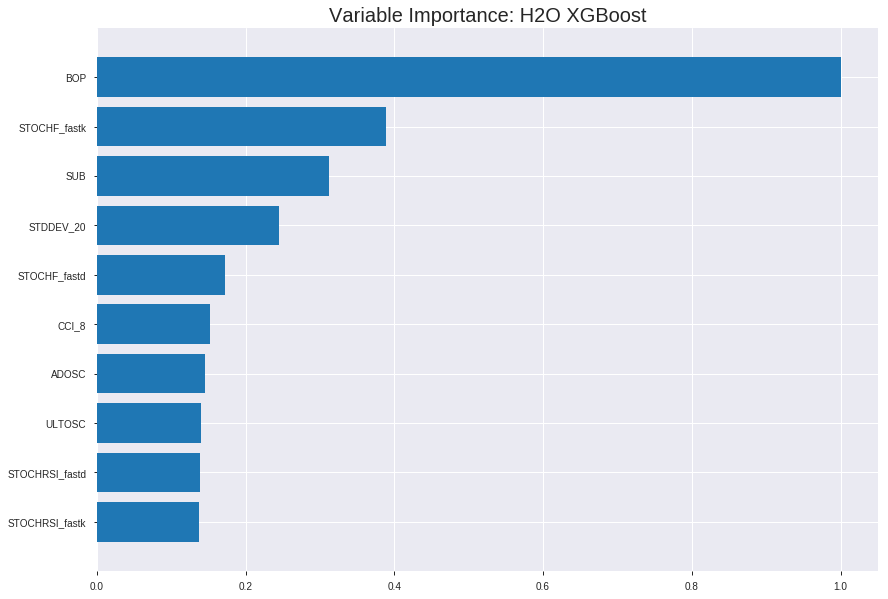

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_124437_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11756957410257057
RMSE: 0.3428841992605821
LogLoss: 0.3956606818672345
Mean Per-Class Error: 0.12227161847552304
AUC: 0.9501614317232538
pr_auc: 0.9562494762488623
Gini: 0.9003228634465077
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138338655233383: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      696  123  0.1502   (123.0/819.0)
1      87   835  0.0944   (87.0/922.0)
Total  783  958  0.1206   (210.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513834     0.888298  202
max f2                       0.379722     0.923345  261
max f0point5                 0.613407     0.902389  156
max accuracy                 0.513834     0.87938   202
max precision                0.936716     1         0
max recall                   0.191048     1         345
max specificity              0.936716     1         0
max absolute_mcc             0.513834     0.757972  202
max min_per_class_accuracy   0.537981     0.873102  192
max mean_per_class_accuracy  0.513834     0.877728  202

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.918158           1.88829    1.88829            1                0.925614  1                           0.925614            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.908648           1.88829    1.88829            1                0.913881  1                           0.919915            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.895555           1.88829    1.88829            1                0.901443  1                           0.913642            0.0195228       0.0574837                  88.8286   88.8286
    4        0.0402068                   0.886967           1.88829    1.88829            1                0.8904    1                           0.907997            0.0184382       0.0759219                  88.8286   88.8286
    5        0.0505457                   0.874943           1.88829    1.88829            1                0.880187  1                           0.902309            0.0195228       0.0954447                  88.8286   88.8286
    6        0.100517                    0.83837            1.88829    1.88829            1                0.855846  1                           0.87921             0.0943601       0.189805                   88.8286   88.8286
    7        0.150488                    0.804054           1.88829    1.88829            1                0.818331  1                           0.858995            0.0943601       0.284165                   88.8286   88.8286
    8        0.20046                     0.774493           1.84488    1.87747            0.977011         0.788717  0.994269                    0.841475            0.0921909       0.376356                   84.4877   87.7465
    9        0.300402                    0.715041           1.81232    1.85579            0.95977          0.744408  0.982792                    0.809181            0.181128        0.557484                   81.2321   85.5792
    10       0.400345                    0.639899           1.64954    1.8043             0.873563         0.677198  0.955524                    0.776233            0.164859        0.722343                   64.9537   80.4302
    11       0.500287                    0.553226           1.23715    1.691              0.655172         0.597112  0.895522                    0.74045             0.123644        0.845987                   23.7153   69.1003
    12       0.60023                     0.458017           0.922439   1.56303            0.488506         0.509873  0.827751                    0.702057            0.0921909       0.938178                   -7.75613  56.3031
    13       0.700172                    0.362421           0.401532   1.39724            0.212644         0.409458  0.739951                    0.660292            0.0401302       0.978308                   -59.8468  39.7239
    14       0.800115                    0.259033           0.141079   1.24033            0.0747126        0.313999  0.656856                    0.617036            0.0140998       0.992408                   -85.8921  24.0332
    15       0.900057                    0.165847           0.0759655  1.11104            0.0402299        0.215735  0.588385                    0.572476            0.00759219      1                          -92.4034  11.104
    16       1                           0.0569734          0          1                  0                0.119211  0.529581                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20545129919726557
RMSE: 0.4532673595101081
LogLoss: 0.5975800475058319
Mean Per-Class Error: 0.3064649110044133
AUC: 0.7434324328693599
pr_auc: 0.7489694110391251
Gini: 0.4868648657387198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3498722016811371: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  135  0.5696   (135.0/237.0)
1      32   229  0.1226   (32.0/261.0)
Total  134  364  0.3353   (167.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349872     0.7328    289
max f2                       0.116458     0.850785  386
max f0point5                 0.609945     0.715588  160
max accuracy                 0.565966     0.692771  192
max precision                0.930953     1         0
max recall                   0.0836891    1         396
max specificity              0.930953     1         0
max absolute_mcc             0.5903       0.388429  170
max min_per_class_accuracy   0.565966     0.685824  192
max mean_per_class_accuracy  0.5903       0.693535  170

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.905541           1.90805   1.90805            1                0.919083  1                           0.919083            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.88313            1.90805   1.90805            1                0.894837  1                           0.90696             0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.875309           1.90805   1.90805            1                0.878441  1                           0.897453            0.0191571       0.0574713                  90.8046   90.8046
    4        0.0401606                   0.861752           1.52644   1.81264            0.8              0.870857  0.95                        0.890804            0.0153257       0.0727969                  52.6437   81.2644
    5        0.0502008                   0.853765           1.90805   1.83172            1                0.859017  0.96                        0.884447            0.0191571       0.091954                   90.8046   83.1724
    6        0.100402                    0.810769           1.29747   1.5646             0.68             0.833775  0.82                        0.859111            0.0651341       0.157088                   29.7471   56.4598
    7        0.150602                    0.775946           1.45011   1.52644            0.76             0.792968  0.8                         0.837063            0.0727969       0.229885                   45.0115   52.6437
    8        0.200803                    0.734208           1.45011   1.50736            0.76             0.757067  0.79                        0.817064            0.0727969       0.302682                   45.0115   50.7356
    9        0.301205                    0.677939           1.33563   1.45011            0.7              0.703166  0.76                        0.779098            0.1341          0.436782                   33.5632   45.0115
    10       0.399598                    0.615417           1.36289   1.42864            0.714286         0.647998  0.748744                    0.746817            0.1341          0.570881                   36.289    42.8637
    11       0.5                         0.56649            1.10667   1.36398            0.58             0.592302  0.714859                    0.71579             0.111111        0.681992                   10.6667   36.3985
    12       0.600402                    0.49151            0.801379  1.2699             0.42             0.530153  0.665552                    0.684747            0.0804598       0.762452                   -19.8621  26.9904
    13       0.698795                    0.390692           0.817734  1.20624            0.428571         0.444603  0.632184                    0.650934            0.0804598       0.842912                   -18.2266  20.6236
    14       0.799197                    0.291304           0.725057  1.14579            0.38             0.336266  0.600503                    0.611403            0.0727969       0.915709                   -27.4943  14.5786
    15       0.899598                    0.195797           0.534253  1.07753            0.28             0.245515  0.564732                    0.570567            0.0536398       0.969349                   -46.5747  7.75349
    16       1                           0.070417           0.305287  1                  0.16             0.137864  0.524096                    0.527123         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:44:51  9.044 sec   0                  0.5              0.693147            0.5             0                  1                0.470419                         0.5                0.693147              0.5               0                    1                  0.475904
    2019-08-28 12:44:51  9.196 sec   5                  0.467749         0.630267            0.861199        0.873982           1.88829          0.233774                         0.4813             0.656178              0.729101          0.742193             1.90805            0.313253
    2019-08-28 12:44:51  9.297 sec   10                 0.442294         0.582033            0.88411         0.894396           1.88829          0.208501                         0.469168           0.632215              0.742341          0.749822             1.90805            0.339357
    2019-08-28 12:44:51  9.397 sec   15                 0.423917         0.547359            0.895675        0.905758           1.88829          0.205629                         0.462851           0.619377              0.742875          0.745557             1.90805            0.323293
    2019-08-28 12:44:51  9.498 sec   20                 0.407391         0.516246            0.907114        0.916929           1.88829          0.180356                         0.457644           0.608414              0.743618          0.748953             1.90805            0.321285
    2019-08-28 12:44:51  9.597 sec   25                 0.394142         0.491066            0.916043        0.925724           1.88829          0.166571                         0.455498           0.603285              0.743125          0.751004             1.90805            0.329317
    2019-08-28 12:44:51  9.706 sec   30                 0.383872         0.471791            0.924427        0.932675           1.88829          0.151637                         0.454179           0.600184              0.743263          0.750372             1.90805            0.321285
    2019-08-28 12:44:52  9.801 sec   35                 0.374903         0.454776            0.929794        0.93681            1.88829          0.148191                         0.454883           0.601068              0.74045           0.746299             1.90805            0.329317
    2019-08-28 12:44:52  9.901 sec   40                 0.366037         0.437926            0.935071        0.942162           1.88829          0.143021                         0.454114           0.599205              0.739908          0.746426             1.90805            0.327309
    2019-08-28 12:44:52  10.005 sec  45                 0.358213         0.423272            0.939588        0.946905           1.88829          0.138426                         0.45292            0.596571              0.742883          0.748096             1.90805            0.327309
    2019-08-28 12:44:52  10.111 sec  50                 0.34993          0.408154            0.945356        0.952141           1.88829          0.129236                         0.453391           0.59755               0.742196          0.746735             1.90805            0.345382
    2019-08-28 12:44:52  10.212 sec  55                 0.342884         0.395661            0.950161        0.956249           1.88829          0.12062                          0.453267           0.59758               0.743432          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           1920.3115234375        1.0                    0.1967632882596905
STOCHF_fastk  747.31201171875        0.38916186389435714    0.07657276800512383
SUB           599.4210205078125      0.31214780164147765    0.06141922787401076
STDDEV_20     471.5109558105469      0.24553878371073215    0.04831301847820859
STOCHF_fastd  331.0800476074219      0.1724095510372005     0.0339238701894565
---           ---                    ---                    ---
ROCR_12       29.307931900024414     0.015262071566159767   0.0030030153870123206
ROCR_8        28.812320709228516     0.015003982613014957   0.0029522329559280467
CDLLONGLINE   14.841592788696289     0.0077287422418466445  0.001520732737617318
CDLDOJI       7.338287353515625      0.0038214046335458877  0.0007519121414673065
CDLBELTHOLD   2.562976837158203      0.001334667217207698   0.0002626135103901972


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6867469879518072)

('F1', 0.7462686567164178)

('auc', 0.7331475239823697)

('logloss', 0.6054524104241265)

('mean_per_class_error', 0.32013222711952294)

('rmse', 0.45754194898686174)

('mse', 0.209344635082696)

xgboost prediction progress: |████████████████████████████████████████████| 100%


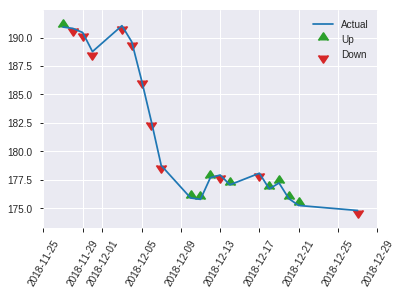


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.209344635082696
RMSE: 0.45754194898686174
LogLoss: 0.6054524104241265
Mean Per-Class Error: 0.32013222711952294
AUC: 0.7331475239823697
pr_auc: 0.7428760574116631
Gini: 0.4662950479647394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23126043379306793: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      39   77   0.6638   (77.0/116.0)
1      8    125  0.0602   (8.0/133.0)
Total  47   202  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.23126      0.746269  201
max f2                       0.101391     0.859173  241
max f0point5                 0.508651     0.70073   137
max accuracy                 0.378742     0.686747  166
max precision                0.909852     1         0
max recall                   0.101391     1         241
max specificity              0.909852     1         0
max absolute_mcc             0.378742     0.373439  166
max min_per_class_accuracy   0.532514     0.655172  127
max mean_per_class_accuracy  0.508651     0.679868  137

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.875038           1.24812   1.24812            0.666667         0.892846  0.666667                    0.892846            0.0150376       0.0150376                  24.812    24.812
    2        0.0200803                   0.867662           1.87218   1.49774            1                0.871372  0.8                         0.884256            0.0150376       0.0300752                  87.218    49.7744
    3        0.0321285                   0.863641           1.87218   1.63816            1                0.866694  0.875                       0.877671            0.0225564       0.0526316                  87.218    63.8158
    4        0.0401606                   0.852238           1.87218   1.68496            1                0.857693  0.9                         0.873675            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.851137           1.87218   1.72817            1                0.851648  0.923077                    0.868592            0.0225564       0.0902256                  87.218    72.8167
    6        0.100402                    0.822277           1.71617   1.72241            0.916667         0.833222  0.92                        0.851614            0.0827068       0.172932                   71.6165   72.2406
    7        0.15261                     0.790144           1.44014   1.62584            0.769231         0.807315  0.868421                    0.836459            0.075188        0.24812                    44.0139   62.5841
    8        0.200803                    0.737662           0.93609   1.4603             0.5              0.76274   0.78                        0.818767            0.0451128       0.293233                   -6.39098  46.0301
    9        0.301205                    0.6572             1.34797   1.42286            0.72             0.695238  0.76                        0.77759             0.135338        0.428571                   34.797    42.2857
    10       0.401606                    0.608715           1.04842   1.32925            0.56             0.632587  0.71                        0.741339            0.105263        0.533835                   4.84211   32.9248
    11       0.502008                    0.54041            1.1982    1.30304            0.64             0.576421  0.696                       0.708356            0.120301        0.654135                   19.8195   30.3038
    12       0.598394                    0.453832           1.0141    1.2565             0.541667         0.503855  0.671141                    0.675416            0.0977444       0.75188                    1.40977   25.6497
    13       0.698795                    0.340785           0.973534  1.21584            0.52             0.401298  0.649425                    0.636031            0.0977444       0.849624                   -2.64662  21.5841
    14       0.799197                    0.23626            0.673985  1.14777            0.36             0.276666  0.613065                    0.590885            0.0676692       0.917293                   -32.6015  14.7769
    15       0.899598                    0.168703           0.449323  1.06982            0.24             0.199749  0.571429                    0.547231            0.0451128       0.962406                   -55.0677  6.98174
    16       1                           0.0708383          0.374436  1                  0.2              0.125304  0.534137                    0.504869          

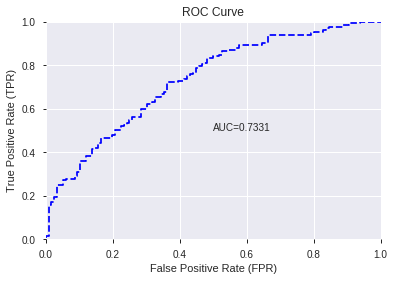

This function is available for GLM models only


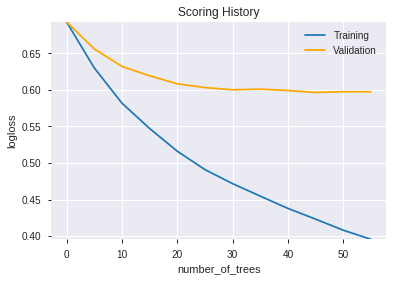

--2019-08-28 12:44:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_124437_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_124437_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'STDDEV_20',
 'STOCHF_fastd',
 'CCI_8',
 'ADOSC',
 'ULTOSC',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'BETA_20',
 'LINEARREG_SLOPE_8',
 'MACDFIX_signal_24',
 'WILLR_8',
 'MACDFIX_12',
 'aroondown_30',
 'MACD_signal',
 'SAREXT',
 'WILLR_20',
 'weekday',
 'MOM_12',
 'WILLR_12',
 'ROCP_12',
 'aroondown_14',
 'CMO_8',
 'MOM_14',
 'RSI_12',
 'CMO_20',
 'MACDFIX_signal_14',
 'MOM_8',
 'WILLR_14',
 'WILLR_30',
 'ROC_14',
 'ROC_8',
 'quarter',
 'aroonup_30',
 'WILLR_24',
 'CDLCLOSINGMARUBOZU',
 'ROCR100_14',
 'RSI_8',
 'RSI_14',
 'ROCP_8',
 'ROCR100_12',
 'ROCR_12',
 'ROCR_8',
 'CDLLONGLINE',
 'CDLDOJI',
 'CDLBELTHOLD']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

67

['BOP',
 'CCI_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MACDFIX_hist_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MACDFIX_hist_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'MACD_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_124510_model_8  0.748120  0.599377              0.286946  0.449839  0.202355
1  DeepLearning_grid_1_AutoML_20190828_124510_model_7  0.742416  0.642846              0.305192  0.468262  0.219269
2  DeepLearning_grid_1_AutoML_20190828_124510_model_5  0.738463  0.598969              0.310150  0.454047  0.206159
3  DeepLearning_grid_1_AutoML_20190828_124510_model_6  0.736648  0.594421              0.328494  0.451102  0.203493
4  DeepLearning_grid_1_AutoML_20190828_124510_model_9  0.736388  0.598435              0.302534  0.453495  0.205658
5  DeepLearning_grid_1_AutoML_20190828_124510_model_3  0.735351  0.614891              0.331799  0.458397  0.210128
6  DeepLearning_grid_1_AutoML_20190828_124510_model_4  0.720962  0.653079              0.333355  0.470668  0.221528
7  DeepLearning_grid_1_AutoML_20190828_124510_model_2  0.720119  0.632467              0.377107  0.467488  0.218545
8               DeepLearning_1_AutoML_20190828_124510  0.716036  0.706708              0.378662  0.488082  0.238224
9  DeepLearning_grid_1_AutoML_20190828_124510_model_1  0.709813  0.750442              0.319776  0.494991  0.245017

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.041982
1   CDLCLOSINGMARUBOZU             0.615642           0.615642    0.025846
2                  SUB             0.609138           0.609138    0.025573
3               ULTOSC             0.531294           0.531294    0.022305
4                  DIV             0.501231           0.501231    0.021043
..                 ...                  ...                ...         ...
62              RSI_24             0.276313           0.276313    0.011600
63               RSI_8             0.276155           0.276155    0.011594
64              RSI_12             0.273983           0.273983    0.011502
65              RSI_14             0.264292           0.264292    0.011096
66              CMO_14             0.254940           0.254940    0.010703

[67 rows x 4 columns]

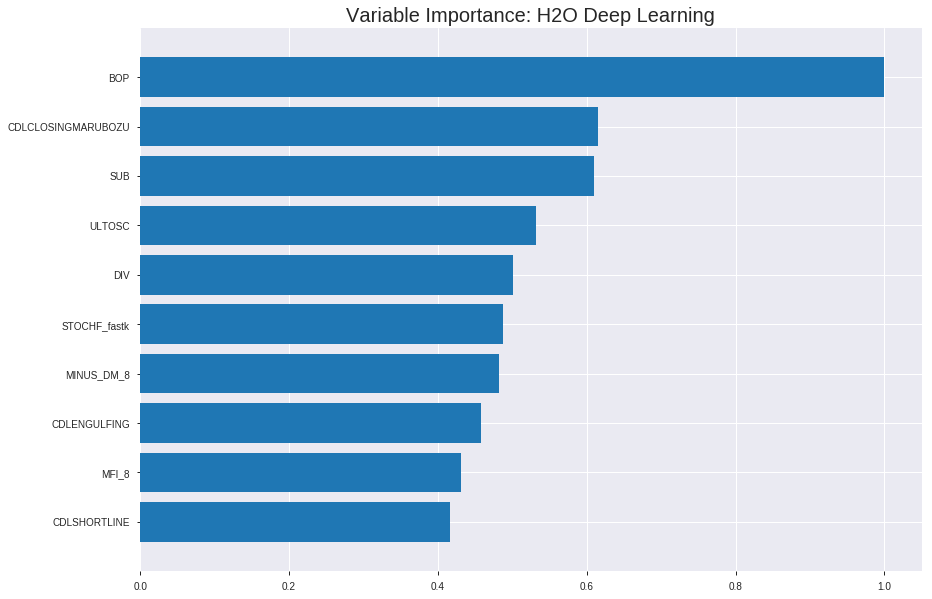

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_124510_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1838768177487179
RMSE: 0.4288086026990572
LogLoss: 0.5448620180088856
Mean Per-Class Error: 0.27723415413220187
AUC: 0.7936931711335182
pr_auc: 0.7947902901671752
Gini: 0.5873863422670365
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41180701227671146: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      441  378   0.4615   (378.0/819.0)
1      103  819   0.1117   (103.0/922.0)
Total  544  1197  0.2763   (481.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411807     0.773006  239
max f2                       0.24453      0.871434  311
max f0point5                 0.596401     0.736105  158
max accuracy                 0.520212     0.727743  196
max precision                0.966897     1         0
max recall                   0.0333972    1         393
max specificity              0.966897     1         0
max absolute_mcc             0.411807     0.459549  239
max min_per_class_accuracy   0.587454     0.715835  163
max mean_per_class_accuracy  0.52898      0.722766  192

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.923183           1.78338   1.78338            0.944444         0.93735    0.944444                    0.93735             0.0184382       0.0184382                  78.3382   78.3382
    2        0.0201034                   0.890462           1.77721   1.78038            0.941176         0.905626   0.942857                    0.921942            0.0173536       0.0357918                  77.7211   78.0384
    3        0.0304423                   0.87137            1.88829   1.81703            1                0.880846   0.962264                    0.907985            0.0195228       0.0553145                  88.8286   81.703
    4        0.0402068                   0.85057            1.55506   1.75341            0.823529         0.857479   0.928571                    0.895719            0.0151844       0.0704989                  55.5059   75.3409
    5        0.0505457                   0.832289           1.78338   1.75954            0.944444         0.839089   0.931818                    0.884136            0.0184382       0.0889371                  78.3382   75.954
    6        0.100517                    0.755285           1.69295   1.72643            0.896552         0.787305   0.914286                    0.835997            0.0845987       0.173536                   69.2946   72.6433
    7        0.150488                    0.695704           1.56272   1.67207            0.827586         0.723547   0.885496                    0.798656            0.0780911       0.251627                   56.272    67.207
    8        0.20046                     0.672857           1.43249   1.61235            0.758621         0.682995   0.853868                    0.769824            0.0715835       0.32321                    43.2493   61.2348
    9        0.300402                    0.643749           1.31312   1.5128             0.695402         0.657199   0.801147                    0.732354            0.131236        0.454447                   31.3119   51.2795
    10       0.400345                    0.622836           1.25886   1.4494             0.666667         0.632488   0.767575                    0.707423            0.125813        0.58026                    25.8858   44.9402
    11       0.500287                    0.59223            1.21545   1.40267            0.643678         0.610985   0.742824                    0.688158            0.121475        0.701735                   21.5449   40.2665
    12       0.60023                     0.51806            1.07437   1.348              0.568966         0.557874   0.713876                    0.666465            0.107375        0.809111                   7.43698   34.8002
    13       0.700172                    0.397616           0.868178  1.27951            0.45977          0.455894   0.677605                    0.636408            0.0867679       0.895879                   -13.1822  27.9511
    14       0.800115                    0.277136           0.58602   1.19289            0.310345         0.340441   0.63173                     0.599439            0.0585683       0.954447                   -41.398   19.2887
    15       0.900057                    0.144175           0.314714  1.09537            0.166667         0.205948   0.580089                    0.555745            0.0314534       0.9859                     -68.5286  9.53748
    16       1                           0.00926817         0.141079  1                  0.0747126        0.0870154  0.529581                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20308019430329785
RMSE: 0.4506441992340497
LogLoss: 0.595516135668331
Mean Per-Class Error: 0.2948494107376691
AUC: 0.7485894886593272
pr_auc: 0.752607148334312
Gini: 0.49717897731865435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5091490086777501: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  89   0.3755   (89.0/237.0)
1      56   205  0.2146   (56.0/261.0)
Total  204  294  0.2912   (145.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509149     0.738739  217
max f2                       0.0923234    0.852048  374
max f0point5                 0.560498     0.718105  189
max accuracy                 0.515048     0.708835  215
max precision                0.940094     1         0
max recall                   0.0491304    1         391
max specificity              0.940094     1         0
max absolute_mcc             0.509149     0.416292  217
max min_per_class_accuracy   0.569733     0.691983  183
max mean_per_class_accuracy  0.515048     0.705151  215

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.900912           1.90805   1.90805            1                0.924325   1                           0.924325            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.874101           1.90805   1.90805            1                0.891097   1                           0.907711            0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.856447           1.52644   1.78084            0.8              0.864462   0.933333                    0.893294            0.0153257       0.0536398                  52.6437   78.0843
    4        0.0401606                   0.833802           1.90805   1.81264            1                0.847033   0.95                        0.881729            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.810503           1.52644   1.7554             0.8              0.829841   0.92                        0.871351            0.0153257       0.0881226                  52.6437   75.5402
    6        0.100402                    0.737735           1.52644   1.64092            0.8              0.780025   0.86                        0.825688            0.0766284       0.164751                   52.6437   64.092
    7        0.150602                    0.686997           1.45011   1.57732            0.76             0.711119   0.826667                    0.787498            0.0727969       0.237548                   45.0115   57.7318
    8        0.200803                    0.658298           1.37379   1.52644            0.72             0.67043    0.8                         0.758231            0.0689655       0.306513                   37.3793   52.6437
    9        0.301205                    0.631337           1.22115   1.42467            0.64             0.642593   0.746667                    0.719685            0.122605        0.429119                   22.1149   42.4674
    10       0.415663                    0.616999           1.30551   1.39186            0.684211         0.622179   0.729469                    0.692836            0.149425        0.578544                   30.5505   39.186
    11       0.5                         0.577219           1.18117   1.35632            0.619048         0.599527   0.710843                    0.677097            0.0996169       0.678161                   18.1171   35.6322
    12       0.600402                    0.499511           1.10667   1.31457            0.58             0.540031   0.688963                    0.654176            0.111111        0.789272                   10.6667   31.4573
    13       0.698795                    0.39018            0.623035  1.2172             0.326531         0.451832   0.637931                    0.625685            0.0613027       0.850575                   -37.6965  21.7202
    14       0.799197                    0.263211           0.725057  1.15537            0.38             0.323791   0.605528                    0.587759            0.0727969       0.923372                   -27.4943  15.5375
    15       0.899598                    0.14913            0.381609  1.06902            0.2              0.200393   0.560268                    0.544526            0.0383142       0.961686                   -61.8391  6.90168
    16       1                           0.009183           0.381609  1                  0.2              0.0872323  0.524096                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:51:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:51:24  1 min 14.710 sec  642 obs/sec       0.535899  1             933        0.461923         0.619695            0.143512       0.72028         0.711204           1.46867          0.360138                         0.480103           0.653869              0.0758564        0.667208          0.669974             1.90805            0.39759
    2019-08-28 12:51:35  1 min 25.693 sec  1054 obs/sec      6.90695   13            12025      0.446353         0.584488            0.200277       0.756161        0.751131           1.57357          0.315336                         0.459974           0.610515              0.151726         0.72139           0.725072             1.52644            0.343373
    2019-08-28 12:51:46  1 min 36.073 sec  1203 obs/sec      14.3578   27            24997      0.4538           0.597773            0.173369       0.776234        0.777774           1.78338          0.290063                         0.464045           0.61838               0.136642         0.744604          0.743274             1.90805            0.313253
    2019-08-28 12:51:56  1 min 46.576 sec  1305 obs/sec      22.6864   43            39497      0.447509         0.585184            0.196128       0.777357        0.779998           1.78338          0.299828                         0.460585           0.612442              0.149472         0.742543          0.748823             1.90805            0.329317
    2019-08-28 12:52:07  1 min 56.957 sec  1371 obs/sec      31.2062   59            54330      0.428809         0.544862            0.261909       0.793693        0.79479            1.78338          0.276278                         0.450644           0.595516              0.185788         0.748589          0.752607             1.90805            0.291165
    2019-08-28 12:52:17  2 min  7.472 sec  1367 obs/sec      38.5503   73            67116      0.427213         0.539517            0.267394       0.796553        0.796128           1.78338          0.270534                         0.455432           0.604608              0.168394         0.73484           0.743261             1.90805            0.335341
    2019-08-28 12:52:28  2 min 18.037 sec  1411 obs/sec      47.5284   90            82747      0.422958         0.529687            0.281913       0.805635        0.80735            1.88829          0.271683                         0.461775           0.6285                0.14507          0.731453          0.741147             1.90805            0.329317
    2019-08-28 12:52:29  2 min 19.109 sec  1410 obs/sec      47.5284   90            82747      0.428809         0.544862            0.261909       0.793693        0.79479            1.78338          0.276278                         0.450644           0.595516              0.185788         0.748589          0.752607             1.90805            0.291165

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04198239581970324
CDLCLOSINGMARUBOZU  0.6156415939331055     0.6156415939331055   0.025846109079572646
SUB                 0.6091377139091492     0.6091377139091492   0.02557306061404305
ULTOSC              0.5312935709953308     0.5312935709953308   0.022304976993989582
DIV                 0.5012306571006775     0.5012306571006775   0.02104286384337059
---                 ---                    ---                  ---
RSI_24              0.27631258964538574    0.27631258964538574  0.011600264508459818
RSI_8               0.27615463733673096    0.27615463733673096  0.011593633292117237
RSI_12              0.2739827334880829     0.2739827334880829   0.011502451565060957
RSI_14              0.26429224014282227    0.26429224014282227  0.011095621437752026
CMO_14              0.254940003156662      0.254940003156662    0.010702992122799376


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7228915662650602)

('F1', 0.7676767676767676)

('auc', 0.7481203007518797)

('logloss', 0.5993767521279313)

('mean_per_class_error', 0.2869458128078818)

('rmse', 0.4498389323572855)

('mse', 0.20235506506434248)

deeplearning prediction progress: |███████████████████████████████████████| 100%


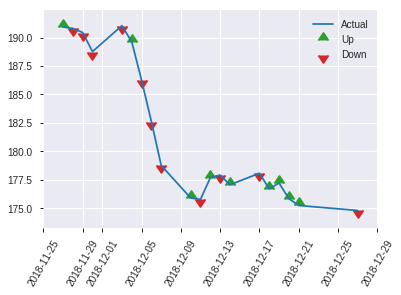


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20235506506434248
RMSE: 0.4498389323572855
LogLoss: 0.5993767521279313
Mean Per-Class Error: 0.2869458128078818
AUC: 0.7481203007518797
pr_auc: 0.7506941750665017
Gini: 0.4962406015037595
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3814096543691377: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   50   0.431    (50.0/116.0)
1      19   114  0.1429   (19.0/133.0)
Total  85   164  0.2771   (69.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38141      0.767677  148
max f2                       0.159712     0.858855  203
max f0point5                 0.38141      0.722433  148
max accuracy                 0.38141      0.722892  148
max precision                0.926504     1         0
max recall                   0.0184022    1         232
max specificity              0.926504     1         0
max absolute_mcc             0.38141      0.448274  148
max min_per_class_accuracy   0.558902     0.672414  112
max mean_per_class_accuracy  0.38141      0.713054  148

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 47.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.886971           1.87218   1.87218            1                0.904296   1                           0.904296            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.854982           1.87218   1.87218            1                0.871038   1                           0.890993            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.837377           1.87218   1.87218            1                0.850831   1                           0.875932            0.0225564       0.0601504                  87.218    87.218
    4        0.0401606                   0.807852           1.87218   1.87218            1                0.819349   1                           0.864615            0.0150376       0.075188                   87.218    87.218
    5        0.0522088                   0.78367            1.87218   1.87218            1                0.800387   1                           0.849793            0.0225564       0.0977444                  87.218    87.218
    6        0.100402                    0.712744           1.24812   1.57263            0.666667         0.745152   0.84                        0.799566            0.0601504       0.157895                   24.812    57.2632
    7        0.15261                     0.672551           1.29612   1.47804            0.692308         0.690715   0.789474                    0.762327            0.0676692       0.225564                   29.6125   47.8037
    8        0.200803                    0.646808           1.40414   1.4603             0.75             0.656404   0.78                        0.736906            0.0676692       0.293233                   40.4135   46.0301
    9        0.301205                    0.62599            1.34797   1.42286            0.72             0.634568   0.76                        0.702793            0.135338        0.428571                   34.797    42.2857
    10       0.409639                    0.616999           1.24812   1.3766             0.666667         0.618902   0.735294                    0.680587            0.135338        0.56391                    24.812    37.6603
    11       0.502008                    0.570385           1.05819   1.31802            0.565217         0.597812   0.704                       0.665356            0.0977444       0.661654                   5.8189    31.8015
    12       0.598394                    0.468451           1.24812   1.30676            0.666667         0.529063   0.697987                    0.643403            0.120301        0.781955                   24.812    30.6757
    13       0.698795                    0.343159           0.898647  1.24812            0.48             0.401706   0.666667                    0.608676            0.0902256       0.87218                    -10.1353  24.812
    14       0.799197                    0.226633           0.599098  1.16658            0.32             0.281287   0.623116                    0.567547            0.0601504       0.932331                   -40.0902  16.6585
    15       0.899598                    0.122304           0.374436  1.07818            0.2              0.175593   0.575893                    0.523802            0.037594        0.969925                   -62.5564  7.81753
    16       1                           0.0178524          0.299549  1                  0.16             0.0709316  0.534137                    0.478

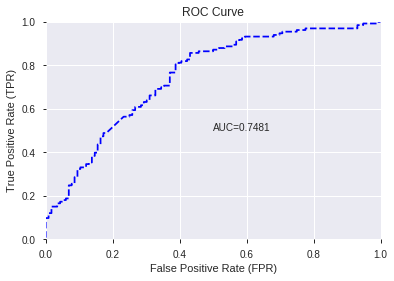

This function is available for GLM models only


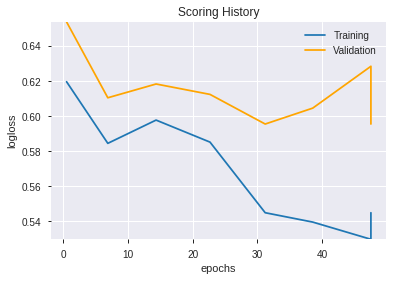

--2019-08-28 12:53:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_124510_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_124510_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'ULTOSC',
 'DIV',
 'STOCHF_fastk',
 'MINUS_DM_8',
 'CDLENGULFING',
 'MFI_8',
 'CDLSHORTLINE',
 'TRANGE',
 'CCI_14',
 'ADOSC',
 'RSI_30',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'PLUS_DI_8',
 'STOCH_slowk',
 'MINUS_DI_12',
 'CCI_30',
 'STOCHF_fastd',
 'CDLMARUBOZU',
 'CDLBELTHOLD',
 'CCI_8',
 'LINEARREG_SLOPE_8',
 'CCI_12',
 'WILLR_20',
 'MACDFIX_hist_14',
 'LINEARREG_ANGLE_8',
 'ROCP_12',
 'MOM_8',
 'WILLR_8',
 'ROCR_8',
 'MINUS_DI_8',
 'MOM_12',
 'MACD_hist',
 'CDLLONGLINE',
 'MACDFIX_hist_12',
 'CMO_8',
 'ROCR100_14',
 'MACDFIX_hist_8',
 'ROCR100_12',
 'CMO_24',
 'MOM_14',
 'WILLR_30',
 'WILLR_12',
 'CMO_30',
 'WILLR_24',
 'ROCR_12',
 'CCI_24',
 'CCI_20',
 'WILLR_14',
 'ROCP_14',
 'ROC_12',
 'ROCR_14',
 'CMO_20',
 'ROCP_8',
 'ROCR100_8',
 'CMO_12',
 'ROC_14',
 'RSI_20',
 'ROC_8',
 'RSI_24',
 'RSI_8',
 'RSI_12',
 'RSI_14',
 'CMO_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_125356_model_1  0.739629  0.602262              0.304641  0.456104  0.208031

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.709659           1.000000    0.127744
1         STOCHF_fastk             0.329730           0.464633    0.059354
2                  SUB             0.212416           0.299321    0.038237
3            PLUS_DI_8             0.165488           0.233194    0.029789
4   CDLCLOSINGMARUBOZU             0.160776           0.226554    0.028941
..                 ...                  ...                ...         ...
62              ROCR_8             0.007778           0.010960    0.001400
63              ROCP_8             0.007638           0.010762    0.001375
64               ROC_8             0.007564           0.010658    0.001362
65               ADOSC             0.003868           0.005450    0.000696
66                 DIV             0.002894           0.004078    0.000521

[67 rows x 4 columns]

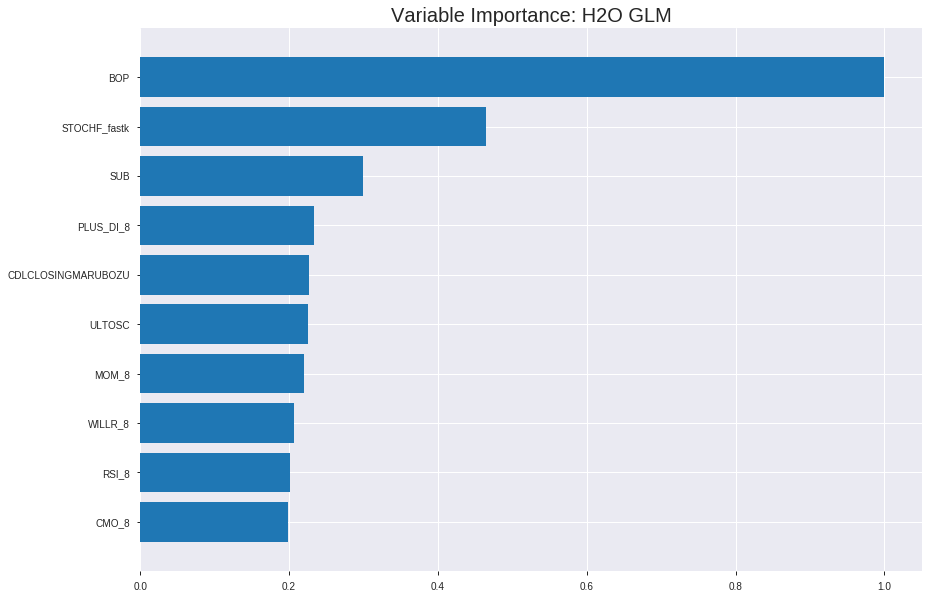

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_125356_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19412346367681704
RMSE: 0.44059444353829186
LogLoss: 0.5720399917766349
Null degrees of freedom: 1740
Residual degrees of freedom: 1673
Null deviance: 2407.4412986831494
Residual deviance: 1991.8432513662424
AIC: 2127.8432513662424
AUC: 0.769569126944398
pr_auc: 0.7615033625226861
Gini: 0.5391382538887961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34688858761148894: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      334  485   0.5922   (485.0/819.0)
1      66   856   0.0716   (66.0/922.0)
Total  400  1341  0.3165   (551.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346889     0.756518  283
max f2                       0.245275     0.863392  330
max f0point5                 0.512        0.719776  204
max accuracy                 0.463572     0.714532  227
max precision                0.923201     1         0
max recall                   0.0642317    1         394
max specificity              0.923201     1         0
max absolute_mcc             0.460933     0.429046  228
max min_per_class_accuracy   0.549631     0.692308  187
max mean_per_class_accuracy  0.463572     0.707903  227

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.892072           1.57357   1.57357            0.833333         0.906355  0.833333                    0.906355            0.016269        0.016269                   57.3572   57.3572
    2        0.0201034                   0.879              1.88829   1.72643            1                0.885656  0.914286                    0.896301            0.0184382       0.0347072                  88.8286   72.6433
    3        0.0304423                   0.864767           1.57357   1.67452            0.833333         0.871423  0.886792                    0.887852            0.016269        0.0509761                  57.3572   67.4518
    4        0.0402068                   0.850235           1.66614   1.67248            0.882353         0.856633  0.885714                    0.88027             0.016269        0.0672451                  66.6135   67.2482
    5        0.0505457                   0.836942           1.46867   1.63079            0.777778         0.842902  0.863636                    0.872627            0.0151844       0.0824295                  46.8667   63.0793
    6        0.100517                    0.794558           1.58442   1.60774            0.83908          0.812096  0.851429                    0.842534            0.0791757       0.161605                   58.4424   60.7741
    7        0.150488                    0.761891           1.4759    1.56396            0.781609         0.778352  0.828244                    0.821222            0.0737527       0.235358                   47.5902   56.3962
    8        0.20046                     0.738656           1.51931   1.55283            0.804598         0.750575  0.82235                     0.803611            0.0759219       0.31128                    51.9311   55.2831
    9        0.300402                    0.686595           1.29141   1.46586            0.683908         0.711762  0.776291                    0.773053            0.129067        0.440347                   29.1414   46.5859
    10       0.400345                    0.624195           1.33482   1.43315            0.706897         0.655207  0.758967                    0.743634            0.133406        0.573753                   33.4823   43.3147
    11       0.500287                    0.556382           1.06352   1.35931            0.563218         0.588964  0.719862                    0.712735            0.106291        0.680043                   6.35176   35.9306
    12       0.60023                     0.479045           1.12863   1.3209             0.597701         0.518462  0.699522                    0.680387            0.112798        0.792842                   12.8631   32.0897
    13       0.700172                    0.401556           0.835621  1.25163            0.442529         0.441479  0.662838                    0.646286            0.0835141       0.876356                   -16.4379  25.1629
    14       0.800115                    0.319304           0.661985  1.17798            0.350575         0.36103   0.623833                    0.610654            0.0661605       0.942516                   -33.8015  17.7976
    15       0.900057                    0.218636           0.379828  1.08935            0.201149         0.268791  0.576899                    0.572694            0.037961        0.980477                   -62.0172  8.93496
    16       1                           0.0203498          0.19534   1                  0.103448         0.141316  0.529581                    0.529581         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20643300097866152
RMSE: 0.4543489858893288
LogLoss: 0.5993488409159979
Null degrees of freedom: 497
Residual degrees of freedom: 430
Null deviance: 689.27761756622
Residual deviance: 596.951445552334
AIC: 732.951445552334
AUC: 0.7389543624812067
pr_auc: 0.7374618016598344
Gini: 0.47790872496241343
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32792218124010863: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   145  0.6118   (145.0/237.0)
1      23   238  0.0881   (23.0/261.0)
Total  115  383  0.3373   (168.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327922     0.73913   306
max f2                       0.119609     0.856299  385
max f0point5                 0.564025     0.705931  181
max accuracy                 0.514305     0.690763  205
max precision                0.890145     1         0
max recall                   0.119609     1         385
max specificity              0.890145     1         0
max absolute_mcc             0.514305     0.379858  205
max min_per_class_accuracy   0.532379     0.687764  197
max mean_per_class_accuracy  0.514305     0.689849  205

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 50.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.858131           1.90805   1.90805            1                0.878456  1                           0.878456            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.832803           1.52644   1.71724            0.8              0.847309  0.9                         0.862883            0.0153257       0.0344828                  52.6437   71.7241
    3        0.0301205                   0.819347           1.90805   1.78084            1                0.826488  0.933333                    0.850751            0.0191571       0.0536398                  90.8046   78.0843
    4        0.0401606                   0.802698           1.90805   1.81264            1                0.81112   0.95                        0.840843            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.796772           1.14483   1.67908            0.6              0.800763  0.88                        0.832827            0.0114943       0.0842912                  14.4828   67.908
    6        0.100402                    0.758965           1.29747   1.48828            0.68             0.776212  0.78                        0.804519            0.0651341       0.149425                   29.7471   48.8276
    7        0.150602                    0.730169           1.45011   1.47556            0.76             0.7472    0.773333                    0.785413            0.0727969       0.222222                   45.0115   47.5556
    8        0.200803                    0.695177           1.52644   1.48828            0.8              0.712554  0.78                        0.767198            0.0766284       0.298851                   52.6437   48.8276
    9        0.301205                    0.656593           1.48828   1.48828            0.78             0.674423  0.78                        0.736273            0.149425        0.448276                   48.8276   48.8276
    10       0.399598                    0.596718           1.01243   1.37111            0.530612         0.625844  0.718593                    0.709082            0.0996169       0.547893                   1.24326   37.1108
    11       0.5                         0.536742           1.25931   1.34866            0.66             0.570535  0.706827                    0.681261            0.126437        0.67433                    25.931    34.8659
    12       0.600402                    0.466549           0.954023  1.28267            0.5              0.499326  0.672241                    0.650837            0.0957854       0.770115                   -4.5977   28.2666
    13       0.698795                    0.391212           0.623035  1.18979            0.326531         0.422269  0.623563                    0.618654            0.0613027       0.831418                   -37.6965  18.9787
    14       0.799197                    0.2972             0.954023  1.16017            0.5              0.344894  0.60804                     0.584262            0.0957854       0.927203                   -4.5977   16.0169
    15       0.899598                    0.193329           0.381609  1.07328            0.2              0.24157   0.5625                      0.546015            0.0383142       0.965517                   -61.8391  7.32759
    16       1                           0.0306111          0.343448  1                  0.18             0.131196  0.524096                    0.504367          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 12:53:56  0.000 sec   2            .21E2     68            1.3559634734835115  1.366672806946225
     2019-08-28 12:53:56  0.035 sec   4            .13E2     68            1.3465631671183398  1.360162881003403
     2019-08-28 12:53:56  0.056 sec   6            .81E1     68            1.3353763244746149  1.3518589076907268
     2019-08-28 12:53:56  0.075 sec   8            .5E1      68            1.3220941897343417  1.3411697258448378
     2019-08-28 12:53:56  0.094 sec   10           .31E1     68            1.3062616941389673  1.327438342440958
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 12:53:57  0.318 sec   34           .1E-1     68            1.1394463332339928  1.1998281956867465
     2019-08-28 12:53:57  0.340 sec   36           .64E-2    68            1.1356745995333626  1.2019992561639314
     2019-08-28 12:53:57  0.358 sec   38           .4E-2     68            1.1324744670246305  1.204929369524693
     2019-08-28 12:53:57  0.380 sec   40           .25E-2    68            1.1297229485886664  1.2083150004736725
     2019-08-28 12:53:57  0.400 sec   42           .15E-2    68            1.1273812884831433  1.21206139888013


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7430555555555556)

('auc', 0.7396292455276121)

('logloss', 0.6022617098440871)

('mean_per_class_error', 0.3046409126263936)

('rmse', 0.4561040037033256)

('mse', 0.20803086219420328)

glm prediction progress: |████████████████████████████████████████████████| 100%


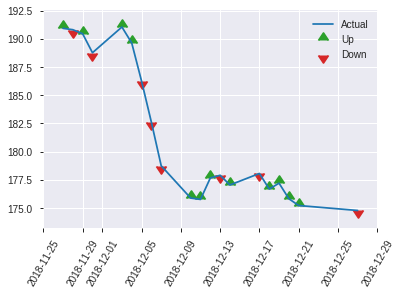


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20803086219420328
RMSE: 0.4561040037033256
LogLoss: 0.6022617098440871
Null degrees of freedom: 248
Residual degrees of freedom: 181
Null deviance: 344.04650308459236
Residual deviance: 299.92633150235537
AIC: 435.92633150235537
AUC: 0.7396292455276121
pr_auc: 0.7526291997234522
Gini: 0.4792584910552242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40233212981226796: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   48   0.4138   (48.0/116.0)
1      26   107  0.1955   (26.0/133.0)
Total  94   155  0.2972   (74.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402332     0.743056  154
max f2                       0.166547     0.860927  222
max f0point5                 0.402332     0.710491  154
max accuracy                 0.402332     0.702811  154
max precision                0.897772     1         0
max recall                   0.109764     1         241
max specificity              0.897772     1         0
max absolute_mcc             0.402332     0.402058  154
max min_per_class_accuracy   0.503132     0.684211  126
max mean_per_class_accuracy  0.402332     0.695359  154

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 48.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.870138           1.87218   1.87218            1                0.886357  1                           0.886357            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.851224           1.87218   1.87218            1                0.85974   1                           0.87571             0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.838764           1.87218   1.87218            1                0.845695  1                           0.864455            0.0225564       0.0601504                  87.218    87.218
    4        0.0401606                   0.830336           1.87218   1.87218            1                0.833284  1                           0.858221            0.0150376       0.075188                   87.218    87.218
    5        0.0522088                   0.816554           1.24812   1.72817            0.666667         0.822525  0.923077                    0.849983            0.0150376       0.0902256                  24.812    72.8167
    6        0.100402                    0.759145           1.71617   1.72241            0.916667         0.77501   0.92                        0.813996            0.0827068       0.172932                   71.6165   72.2406
    7        0.15261                     0.727673           1.29612   1.57657            0.692308         0.742527  0.842105                    0.789546            0.0676692       0.240602                   29.6125   57.6573
    8        0.200803                    0.706497           1.24812   1.49774            0.666667         0.717562  0.8                         0.77227             0.0601504       0.300752                   24.812    49.7744
    9        0.301205                    0.659463           1.27308   1.42286            0.68             0.689586  0.76                        0.744708            0.12782         0.428571                   27.3083   42.2857
    10       0.401606                    0.597887           1.12331   1.34797            0.6              0.628888  0.72                        0.715753            0.112782        0.541353                   12.3308   34.797
    11       0.502008                    0.506473           1.27308   1.33299            0.68             0.561509  0.712                       0.684905            0.12782         0.669173                   27.3083   33.2992
    12       0.598394                    0.43171            0.93609   1.26906            0.5              0.471674  0.677852                    0.650559            0.0902256       0.759398                   -6.39098  26.9062
    13       0.698795                    0.331314           0.898647  1.21584            0.48             0.379289  0.649425                    0.611583            0.0902256       0.849624                   -10.1353  21.5841
    14       0.799197                    0.237865           0.599098  1.13836            0.32             0.296636  0.60804                     0.572017            0.0601504       0.909774                   -40.0902  13.8361
    15       0.899598                    0.164787           0.673985  1.08653            0.36             0.201426  0.580357                    0.530656            0.0676692       0.977444                   -32.6015  8.65333
    16       1                           0.0614449          0.224662  1                  0.12             0.120648  0.534137                    0.489491            0.

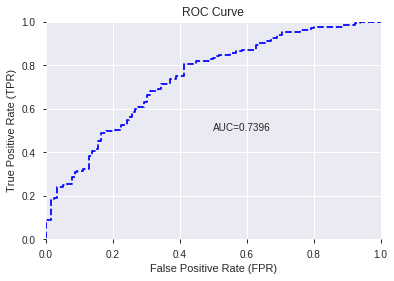

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


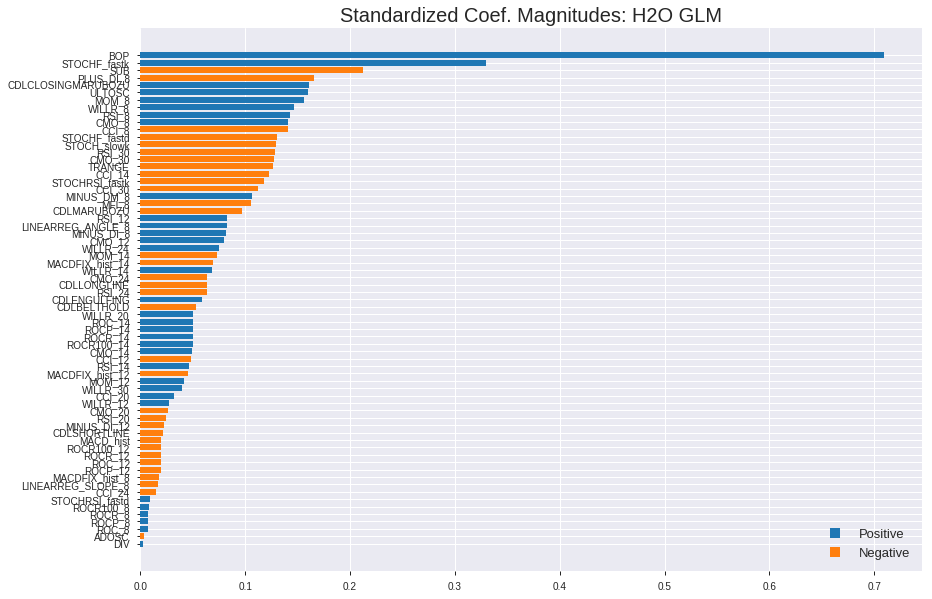

'log_likelihood'
--2019-08-28 12:54:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_125356_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_125356_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'SUB',
 'PLUS_DI_8',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'MOM_8',
 'WILLR_8',
 'RSI_8',
 'CMO_8',
 'CCI_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'RSI_30',
 'CMO_30',
 'TRANGE',
 'CCI_14',
 'STOCHRSI_fastk',
 'CCI_30',
 'MINUS_DM_8',
 'MFI_8',
 'CDLMARUBOZU',
 'RSI_12',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_8',
 'CMO_12',
 'WILLR_24',
 'MOM_14',
 'MACDFIX_hist_14',
 'WILLR_14',
 'CMO_24',
 'CDLLONGLINE',
 'RSI_24',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'WILLR_20',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'CMO_14',
 'CCI_12',
 'RSI_14',
 'MACDFIX_hist_12',
 'MOM_12',
 'WILLR_30',
 'CCI_20',
 'WILLR_12',
 'CMO_20',
 'RSI_20',
 'MINUS_DI_12',
 'CDLSHORTLINE',
 'MACD_hist',
 'ROCR100_12',
 'ROCR_12',
 'ROC_12',
 'ROCP_12',
 'MACDFIX_hist_8',
 'LINEARREG_SLOPE_8',
 'CCI_24',
 'STOCHRSI_fastd',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'ADOSC',
 'DIV']

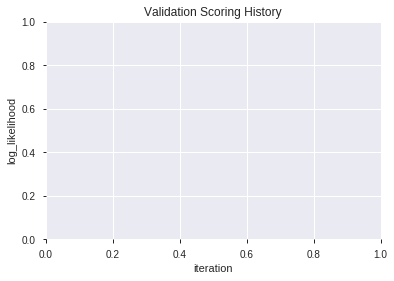

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_125412  0.731527  0.609331              0.325739  0.458375  0.210108
1  XGBoost_grid_1_AutoML_20190828_125412_model_6  0.731203  0.614255              0.338216  0.461677  0.213146
2               XGBoost_2_AutoML_20190828_125412  0.730296  0.610271              0.328396  0.459184  0.210850
3  XGBoost_grid_1_AutoML_20190828_125412_model_4  0.728124  0.616177              0.371143  0.461636  0.213108
4  XGBoost_grid_1_AutoML_20190828_125412_model_1  0.726018  0.614625              0.334360  0.461379  0.212871
5  XGBoost_grid_1_AutoML_20190828_125412_model_2  0.724851  0.615443              0.377107  0.462058  0.213498
6  XGBoost_grid_1_AutoML_20190828_125412_model_3  0.723619  0.616988              0.327392  0.461871  0.213324
7               XGBoost_1_AutoML_20190828_125412  0.723555  0.616956              0.332707  0.461822  0.213280
8  XGBoost_grid_1_AutoML_20190828_125412_model_7  0.720379  0.622415              0.337017  0.464109  0.215397
9  XGBoost_grid_1_AutoML_20190828_125412_model_5  0.710008  0.633748              0.325739  0.469829  0.220739

variable  relative_importance  scaled_importance  percentage
0            BOP          2680.915527           1.000000    0.325030
1   STOCHF_fastk           641.996094           0.239469    0.077834
2            SUB           314.240631           0.117214    0.038098
3         TRANGE           282.650482           0.105431    0.034268
4          ADOSC           276.740875           0.103226    0.033552
..           ...                  ...                ...         ...
58        ROCR_8            10.246419           0.003822    0.001242
59  CDLSHORTLINE             4.514207           0.001684    0.000547
60     ROCR100_8             4.200927           0.001567    0.000509
61       ROCR_12             4.183885           0.001561    0.000507
62        RSI_14             3.787595           0.001413    0.000459

[63 rows x 4 columns]

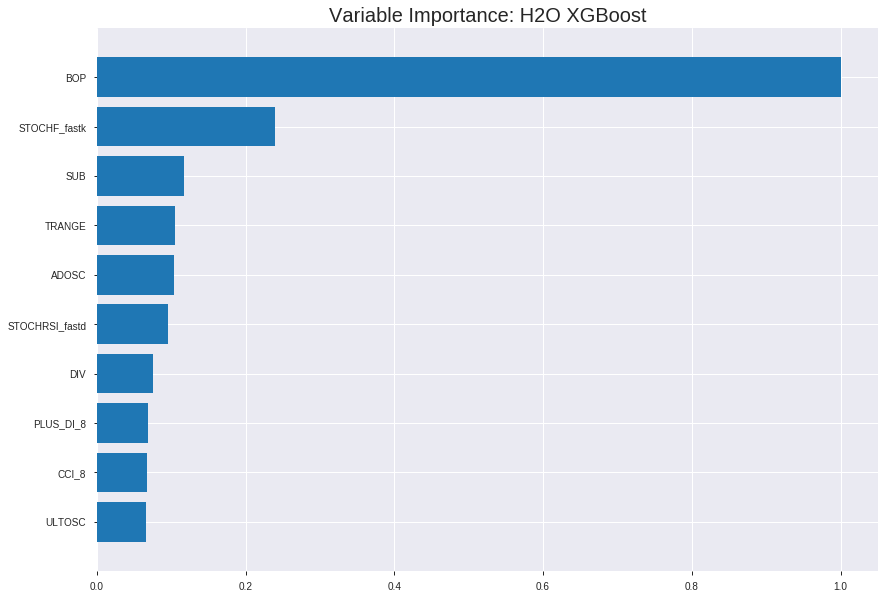

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_125412


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1387169813720345
RMSE: 0.3724472867024735
LogLoss: 0.4433445272816706
Mean Per-Class Error: 0.17100042642341995
AUC: 0.9126414679560017
pr_auc: 0.9192296080715081
Gini: 0.8252829359120033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.515873521566391: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      629  190   0.232    (190.0/819.0)
1      108  814   0.1171   (108.0/922.0)
Total  737  1004  0.1712   (298.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.515874     0.845275  205
max f2                       0.339116     0.899439  282
max f0point5                 0.627454     0.867183  145
max accuracy                 0.534678     0.829408  196
max precision                0.919269     1         0
max recall                   0.171634     1         353
max specificity              0.919269     1         0
max absolute_mcc             0.520424     0.658264  203
max min_per_class_accuracy   0.556504     0.824176  184
max mean_per_class_accuracy  0.589004     0.829     166

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.896567           1.88829   1.88829            1                0.905579  1                           0.905579            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.888785           1.88829   1.88829            1                0.892708  1                           0.899327            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.879762           1.88829   1.88829            1                0.885022  1                           0.894469            0.0195228       0.0574837                  88.8286   88.8286
    4        0.0402068                   0.869418           1.88829   1.88829            1                0.873212  1                           0.889307            0.0184382       0.0759219                  88.8286   88.8286
    5        0.0505457                   0.863367           1.88829   1.88829            1                0.866523  1                           0.884646            0.0195228       0.0954447                  88.8286   88.8286
    6        0.100517                    0.826363           1.86658   1.8775             0.988506         0.844541  0.994286                    0.864708            0.0932755       0.18872                    86.6582   87.7496
    7        0.150488                    0.781979           1.77976   1.84504            0.942529         0.803238  0.977099                    0.844296            0.0889371       0.277657                   77.9764   84.5043
    8        0.20046                     0.750037           1.75806   1.82336            0.931034         0.767619  0.965616                    0.825182            0.0878525       0.36551                    75.806    82.336
    9        0.300402                    0.685984           1.7038    1.78358            0.902299         0.717792  0.944551                    0.789454            0.170282        0.535792                   70.3799   78.3582
    10       0.400345                    0.628859           1.61698   1.74199            0.856322         0.657729  0.922525                    0.75657             0.161605        0.697397                   61.6981   74.1992
    11       0.500287                    0.567637           1.09607   1.61296            0.58046          0.597715  0.854191                    0.724835            0.109544        0.806941                   9.60743   61.2956
    12       0.60023                     0.498053           0.87903   1.49075            0.465517         0.534292  0.789474                    0.693108            0.0878525       0.894794                   -12.097   49.0752
    13       0.700172                    0.401616           0.575168  1.36006            0.304598         0.453891  0.720263                    0.658963            0.0574837       0.952278                   -42.4832  36.0062
    14       0.800115                    0.274431           0.358123  1.23491            0.189655         0.338105  0.653984                    0.618884            0.0357918       0.988069                   -64.1877  23.4909
    15       0.900057                    0.166904           0.119374  1.11104            0.0632184        0.219076  0.588385                    0.574489            0.0119306       1                          -88.0626  11.104
    16       1                           0.0724994          0         1                  0                0.122842  0.529581                    0.529351           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20593986092956723
RMSE: 0.45380597277863943
LogLoss: 0.5981444055808962
Mean Per-Class Error: 0.3162617003734419
AUC: 0.7403689154016523
pr_auc: 0.7480591538719997
Gini: 0.48073783080330457
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3689264953136444: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  129  0.5443   (129.0/237.0)
1      31   230  0.1188   (31.0/261.0)
Total  139  359  0.3213   (160.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368926     0.741935  284
max f2                       0.139352     0.858184  375
max f0point5                 0.576913     0.701541  187
max accuracy                 0.524553     0.686747  223
max precision                0.922309     1         0
max recall                   0.104098     1         393
max specificity              0.922309     1         0
max absolute_mcc             0.368926     0.375119  284
max min_per_class_accuracy   0.570739     0.675105  194
max mean_per_class_accuracy  0.576913     0.683738  187

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.882521           1.90805   1.90805            1                0.898003  1                           0.898003            0.0191571       0.0191571                  90.8046    90.8046
    2        0.0200803                   0.875144           1.90805   1.90805            1                0.880054  1                           0.889028            0.0191571       0.0383142                  90.8046    90.8046
    3        0.0301205                   0.870178           1.52644   1.78084            0.8              0.873281  0.933333                    0.883779            0.0153257       0.0536398                  52.6437    78.0843
    4        0.0401606                   0.858494           1.90805   1.81264            1                0.866512  0.95                        0.879462            0.0191571       0.0727969                  90.8046    81.2644
    5        0.0502008                   0.852528           1.52644   1.7554             0.8              0.856513  0.92                        0.874872            0.0153257       0.0881226                  52.6437    75.5402
    6        0.100402                    0.811453           1.52644   1.64092            0.8              0.830714  0.86                        0.852793            0.0766284       0.164751                   52.6437    64.092
    7        0.150602                    0.760956           1.45011   1.57732            0.76             0.785106  0.826667                    0.830231            0.0727969       0.237548                   45.0115    57.7318
    8        0.200803                    0.718761           1.45011   1.54552            0.76             0.73674   0.81                        0.806858            0.0727969       0.310345                   45.0115    54.5517
    9        0.301205                    0.665449           1.14483   1.41195            0.6              0.692048  0.74                        0.768588            0.114943        0.425287                   14.4828    41.1954
    10       0.399598                    0.616194           1.28501   1.3807             0.673469         0.639569  0.723618                    0.736819            0.126437        0.551724                   28.5011    38.0697
    11       0.5                         0.57251            1.18299   1.341              0.62             0.597184  0.702811                    0.70878             0.118774        0.670498                   18.2989    34.0996
    12       0.600402                    0.517718           0.992184  1.28267            0.52             0.543135  0.672241                    0.68108             0.0996169       0.770115                   -0.781609  28.2666
    13       0.698795                    0.394559           0.817734  1.2172             0.428571         0.468109  0.637931                    0.651093            0.0804598       0.850575                   -18.2266   21.7202
    14       0.799197                    0.258867           0.686897  1.15058            0.36             0.32076   0.603015                    0.609594            0.0689655       0.91954                    -31.3103   15.058
    15       0.899598                    0.16734            0.457931  1.07328            0.24             0.211523  0.5625                      0.565166            0.045977        0.965517                   -54.2069   7.32759
    16       1                           0.0899789          0.343448  1                  0.18             0.12896   0.524096                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:54:16  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.470419                         0.5                0.693147              0.5               0                    1                  0.475904
    2019-08-28 12:54:16  0.139 sec   5                  0.472147         0.638628            0.830205        0.741622           1.80793          0.251005                         0.481113           0.655817              0.725043          0.672955             1.64786            0.329317
    2019-08-28 12:54:16  0.208 sec   10                 0.450821         0.597626            0.843665        0.772119           1.81275          0.248708                         0.469246           0.632257              0.730014          0.681157             1.69604            0.339357
    2019-08-28 12:54:16  0.279 sec   15                 0.435424         0.567769            0.853551        0.855001           1.88829          0.232625                         0.461894           0.617122              0.733393          0.74176              1.90805            0.331325
    2019-08-28 12:54:16  0.350 sec   20                 0.423995         0.545104            0.860648        0.866671           1.88829          0.220563                         0.45913            0.610793              0.73391           0.746619             1.90805            0.327309
    2019-08-28 12:54:16  0.423 sec   25                 0.413239         0.523754            0.869718        0.876997           1.88829          0.216542                         0.456034           0.603872              0.735665          0.748114             1.90805            0.325301
    2019-08-28 12:54:16  0.495 sec   30                 0.405118         0.507417            0.876611        0.885582           1.88829          0.218265                         0.454417           0.600397              0.738486          0.751238             1.90805            0.323293
    2019-08-28 12:54:16  0.588 sec   35                 0.396804         0.49115             0.887431        0.893754           1.88829          0.20448                          0.453451           0.598029              0.739763          0.746912             1.90805            0.325301
    2019-08-28 12:54:16  0.660 sec   40                 0.390696         0.479008            0.8939          0.900542           1.88829          0.191269                         0.453348           0.597559              0.740126          0.745809             1.90805            0.323293
    2019-08-28 12:54:16  0.731 sec   45                 0.385776         0.469439            0.899297        0.906307           1.88829          0.186674                         0.452742           0.596162              0.742034          0.749083             1.90805            0.321285
    2019-08-28 12:54:16  0.807 sec   50                 0.381062         0.45989             0.903492        0.911079           1.88829          0.183228                         0.453057           0.596634              0.741452          0.748872             1.90805            0.323293
    2019-08-28 12:54:17  0.883 sec   55                 0.377052         0.452086            0.907583        0.914269           1.88829          0.174038                         0.453074           0.596908              0.741509          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2680.91552734375       1.0                    0.32502954130642264
STOCHF_fastk  641.99609375           0.23946897513256954    0.0778344911444582
SUB           314.2406311035156      0.11721392483218787    0.03809798822293153
TRANGE        282.6504821777344      0.10543058119320318    0.03426805344489638
ADOSC         276.7408752441406      0.1032262570086777     0.033551582966309404
---           ---                    ---                    ---
ROCR_8        10.246418952941895     0.0038219850078954343  0.0012422580339962771
CDLSHORTLINE  4.514206886291504      0.0016838303334250067  0.0005472946009109705
ROCR100_8     4.200926780700684      0.0015669746912402571  0.000509313065132594
ROCR_12       4.183885097503662      0.0015606180257566912  0.0005072469610662323
RSI_14        3.787594795227051      0.0014127990071286574  0.0004592014132451968


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7450980392156864)

('auc', 0.7315270935960592)

('logloss', 0.6093308570596484)

('mean_per_class_error', 0.30519185895773915)

('rmse', 0.45837519127330123)

('mse', 0.2101078159748355)

xgboost prediction progress: |████████████████████████████████████████████| 100%


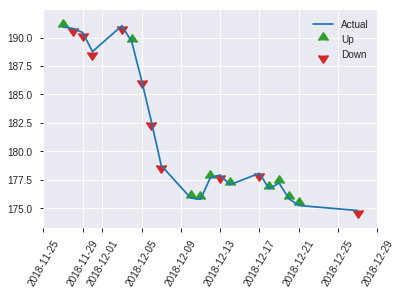


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2101078159748355
RMSE: 0.45837519127330123
LogLoss: 0.6093308570596484
Mean Per-Class Error: 0.30519185895773915
AUC: 0.7315270935960592
pr_auc: 0.7419609381864724
Gini: 0.4630541871921183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31628483533859253: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   59   0.5086   (59.0/116.0)
1      19   114  0.1429   (19.0/133.0)
Total  76   173  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316285     0.745098  172
max f2                       0.13198      0.853977  234
max f0point5                 0.445829     0.709593  156
max accuracy                 0.445829     0.702811  156
max precision                0.90041      1         0
max recall                   0.100381     1         247
max specificity              0.90041      1         0
max absolute_mcc             0.445829     0.402669  156
max min_per_class_accuracy   0.545897     0.663793  127
max mean_per_class_accuracy  0.445829     0.694808  156

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.894412           1.87218   1.87218            1                0.897878  1                           0.897878            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.882763           1.87218   1.87218            1                0.891168  1                           0.895194            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.877959           1.24812   1.63816            0.666667         0.880771  0.875                       0.889785            0.0150376       0.0526316                  24.812    63.8158
    4        0.0401606                   0.873549           1.87218   1.68496            1                0.877163  0.9                         0.887261            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.870549           1.24812   1.58415            0.666667         0.872934  0.846154                    0.883955            0.0150376       0.0827068                  24.812    58.4153
    6        0.100402                    0.822461           1.71617   1.64752            0.916667         0.854021  0.88                        0.869587            0.0827068       0.165414                   71.6165   64.7519
    7        0.15261                     0.769969           1.44014   1.57657            0.769231         0.793641  0.842105                    0.843605            0.075188        0.240602                   44.0139   57.6573
    8        0.200803                    0.733027           1.40414   1.53519            0.75             0.753994  0.82                        0.822099            0.0676692       0.308271                   40.4135   53.5188
    9        0.301205                    0.67282            1.1982    1.42286            0.64             0.702644  0.76                        0.78228             0.120301        0.428571                   19.8195   42.2857
    10       0.401606                    0.619002           1.1982    1.36669            0.64             0.649396  0.73                        0.749059            0.120301        0.548872                   19.8195   36.6692
    11       0.502008                    0.554029           0.973534  1.28806            0.52             0.588542  0.688                       0.716956            0.0977444       0.646617                   -2.64662  28.806
    12       0.598394                    0.469139           1.24812   1.28163            0.666667         0.511264  0.684564                    0.683824            0.120301        0.766917                   24.812    28.1627
    13       0.698795                    0.305701           0.898647  1.2266             0.48             0.406324  0.655172                    0.643954            0.0902256       0.857143                   -10.1353  22.6601
    14       0.799197                    0.208542           0.524211  1.13836            0.28             0.245978  0.60804                     0.593957            0.0526316       0.909774                   -47.5789  13.8361
    15       0.899598                    0.162411           0.524211  1.06982            0.28             0.188152  0.571429                    0.548666            0.0526316       0.962406                   -47.5789  6.98174
    16       1                           0.0904444          0.374436  1                  0.2              0.12963   0.534137                    0.506594            

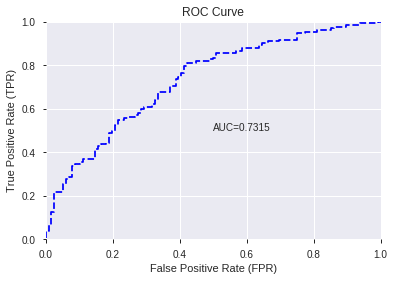

This function is available for GLM models only


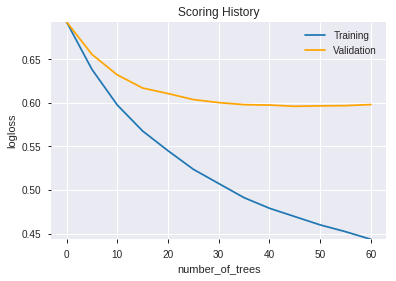

--2019-08-28 12:54:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTr

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_125412',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_125412',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a718',
   'type

['BOP',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'ADOSC',
 'STOCHRSI_fastd',
 'DIV',
 'PLUS_DI_8',
 'CCI_8',
 'ULTOSC',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_12',
 'STOCH_slowk',
 'MINUS_DM_8',
 'MINUS_DI_12',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CCI_12',
 'CMO_30',
 'MINUS_DI_8',
 'MOM_14',
 'CCI_14',
 'ROC_12',
 'MACDFIX_hist_8',
 'MOM_8',
 'MFI_8',
 'ROCP_14',
 'CDLCLOSINGMARUBOZU',
 'ROC_8',
 'WILLR_12',
 'ROC_14',
 'CMO_8',
 'CCI_30',
 'WILLR_24',
 'CMO_12',
 'CCI_20',
 'WILLR_30',
 'WILLR_20',
 'MOM_12',
 'CMO_14',
 'MACD_hist',
 'MACDFIX_hist_14',
 'STOCHF_fastd',
 'CCI_24',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'ROCP_8',
 'RSI_30',
 'ROCP_12',
 'CDLLONGLINE',
 'CMO_24',
 'CMO_20',
 'RSI_24',
 'WILLR_14',
 'RSI_12',
 'CDLBELTHOLD',
 'ROCR_14',
 'RSI_20',
 'ROCR_8',
 'CDLSHORTLINE',
 'ROCR100_8',
 'ROCR_12',
 'RSI_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

175

['BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_14_5_5',
 'MA_14_6',
 'MAVP_14_6',
 'BBANDS_upperband_14_6_2',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_14_6_3',
 'MA_14_7',
 'BBANDS_middleband_14_7_2',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lowerband_14_7_5',
 'EMA_20',
 'MIDPRICE_20',
 'BBANDS_upperband_20_0_2',
 'BBANDS_lowerband_20_0_2',
 'BBANDS_upperband_20_0_3',
 'BBANDS_middleband_20_0_5',
 'MA_20_1',
 'BBANDS_upperband_20_1_2',
 'BBANDS_middleband_20_1_2',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_middleband_20_1_4',
 'BBANDS_upperband_20_2_3',
 'BBANDS_middleband_20_2_3',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_upperband_20_3_2',
 'BBANDS_middleband_20_3_3',
 'BBANDS_middleband_20_3_4',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_upperband_20_5_5',
 'BBANDS_upperband_20_6_2',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_upperband_20_6_4',
 'BBANDS_upperband_20_7_4',
 'BBANDS_lowerband_24_0_3',
 'BBANDS_middleban

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_125553_model_6  0.749741  0.608197              0.324086  0.457506  0.209312
1  DeepLearning_grid_1_AutoML_20190828_125553_model_3  0.745722  0.660621              0.312257  0.470914  0.221760
2  DeepLearning_grid_1_AutoML_20190828_125553_model_9  0.737425  0.605024              0.328947  0.456260  0.208173
3  DeepLearning_grid_1_AutoML_20190828_125553_model_8  0.732305  0.646810              0.342527  0.477844  0.228335
4  DeepLearning_grid_1_AutoML_20190828_125553_model_5  0.727703  0.644182              0.339221  0.475716  0.226306
5  DeepLearning_grid_1_AutoML_20190828_125553_model_7  0.704952  0.644276              0.365180  0.472148  0.222924
6               DeepLearning_1_AutoML_20190828_125553  0.699054  1.092226              0.373250  0.605698  0.366871
7  DeepLearning_grid_1_AutoML_20190828_125553_model_2  0.681812  1.047196              0.373153  0.563715  0.317775
8  DeepLearning_grid_1_AutoML_20190828_125553_model_4  0.674618  0.694429              0.372699  0.488427  0.238561
9  DeepLearning_grid_1_AutoML_20190828_125553_model_1  0.610578  0.996370              0.481106  0.550281  0.302809

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.022376
1          CDLCLOSINGMARUBOZU             0.594511           0.594511    0.013303
2                 CDLLONGLINE             0.470239           0.470239    0.010522
3                      ULTOSC             0.465775           0.465775    0.010422
4                CDLENGULFING             0.431824           0.431824    0.009662
..                        ...                  ...                ...         ...
170                    CMO_24             0.208254           0.208254    0.004660
171   BBANDS_upperband_20_0_2             0.207585           0.207585    0.004645
172  BBANDS_middleband_24_1_3             0.206443           0.206443    0.004619
173                CDLHIKKAKE             0.203576           0.203576    0.004555
174   BBANDS_upperband_20_3_2             0.199324           0.199324    0.004460

[175 rows x 4 columns]

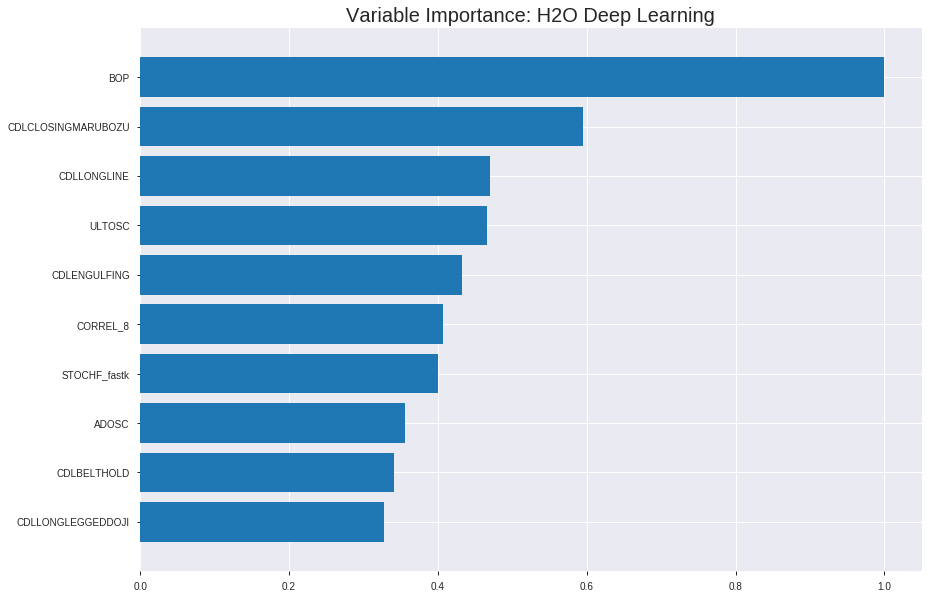

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_125553_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18620453622619834
RMSE: 0.4315142364119617
LogLoss: 0.5506107571712912
Mean Per-Class Error: 0.2782571730510993
AUC: 0.7979084063682763
pr_auc: 0.8078737506080632
Gini: 0.5958168127365526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46555063722168044: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      436  383   0.4676   (383.0/819.0)
1      106  816   0.115    (106.0/922.0)
Total  542  1199  0.2809   (489.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465551     0.769448  241
max f2                       0.349413     0.864222  297
max f0point5                 0.556337     0.741884  186
max accuracy                 0.508872     0.727168  216
max precision                0.995828     1         0
max recall                   0.0447715    1         392
max specificity              0.995828     1         0
max absolute_mcc             0.508872     0.452771  216
max min_per_class_accuracy   0.548675     0.718004  191
max mean_per_class_accuracy  0.508872     0.721743  216

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 54.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.978342           1.88829   1.88829            1                0.986404  1                           0.986404            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.958726           1.77721   1.83434            0.941176         0.966313  0.971429                    0.976645            0.0173536       0.0368764                  77.7211   83.4335
    3        0.0304423                   0.941377           1.78338   1.81703            0.944444         0.949519  0.962264                    0.967433            0.0184382       0.0553145                  78.3382   81.703
    4        0.0402068                   0.921754           1.88829   1.83434            1                0.930494  0.971429                    0.958462            0.0184382       0.0737527                  88.8286   83.4335
    5        0.0505457                   0.905899           1.88829   1.84537            1                0.91389   0.977273                    0.949345            0.0195228       0.0932755                  88.8286   84.5371
    6        0.100517                    0.839895           1.69295   1.76959            0.896552         0.87342   0.937143                    0.911599            0.0845987       0.177874                   69.2946   76.9594
    7        0.150488                    0.791021           1.54102   1.69369            0.816092         0.813317  0.896947                    0.878963            0.0770065       0.254881                   54.1015   69.3692
    8        0.20046                     0.736995           1.36738   1.61235            0.724138         0.763678  0.853868                    0.850225            0.0683297       0.32321                    36.738    61.2348
    9        0.300402                    0.65366            1.44335   1.55612            0.764368         0.692917  0.824092                    0.797889            0.144252        0.467462                   44.3345   55.6121
    10       0.400345                    0.601867           1.23715   1.47649            0.655172         0.626273  0.781923                    0.755047            0.123644        0.591106                   23.7153   47.6494
    11       0.500287                    0.553595           1.16119   1.4135             0.614943         0.575921  0.748565                    0.719263            0.116052        0.707158                   16.1188   41.3505
    12       0.60023                     0.50981            0.987552  1.34258            0.522989         0.530239  0.711005                    0.687789            0.0986985       0.805857                   -1.2448   34.2581
    13       0.700172                    0.454061           0.835621  1.27022            0.442529         0.485693  0.672683                    0.658942            0.0835141       0.889371                   -16.4379  27.0217
    14       0.800115                    0.370704           0.58602   1.18475            0.310345         0.415696  0.627423                    0.628558            0.0585683       0.947939                   -41.398   18.4754
    15       0.900057                    0.246736           0.336419  1.09055            0.178161         0.316803  0.577537                    0.593941            0.0336226       0.981562                   -66.3581  9.05546
    16       1                           0.0123641          0.184488  1                  0.0977011        0.153538  0.529581                    0.549926          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21883431199152
RMSE: 0.4677972979737271
LogLoss: 0.6280333714684005
Mean Per-Class Error: 0.3352247926669576
AUC: 0.7064277284705046
pr_auc: 0.72529684158976
Gini: 0.4128554569410092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3516614343292281: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   148  0.6245   (148.0/237.0)
1      33   228  0.1264   (33.0/261.0)
Total  122  376  0.3635   (181.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351661     0.715856  291
max f2                       0.103224     0.852384  388
max f0point5                 0.525606     0.683544  184
max accuracy                 0.525606     0.662651  184
max precision                0.940116     1         0
max recall                   0.103224     1         388
max specificity              0.940116     1         0
max absolute_mcc             0.525606     0.330031  184
max min_per_class_accuracy   0.507825     0.64751   196
max mean_per_class_accuracy  0.525606     0.664775  184

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 49.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.888544           1.90805   1.90805            1                0.911327  1                           0.911327            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.875412           1.90805   1.90805            1                0.880824  1                           0.896076            0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.851551           1.14483   1.65364            0.6              0.866341  0.866667                    0.886164            0.0114943       0.0498084                  14.4828   65.364
    4        0.0401606                   0.836488           1.14483   1.52644            0.6              0.84796   0.8                         0.876613            0.0114943       0.0613027                  14.4828   52.6437
    5        0.0502008                   0.81784            1.52644   1.52644            0.8              0.829525  0.8                         0.867195            0.0153257       0.0766284                  52.6437   52.6437
    6        0.100402                    0.759335           1.67908   1.60276            0.88             0.794623  0.84                        0.830909            0.0842912       0.16092                    67.908    60.2759
    7        0.150602                    0.711744           1.83172   1.67908            0.96             0.735907  0.88                        0.799242            0.091954        0.252874                   83.1724   67.908
    8        0.200803                    0.669394           1.22115   1.5646             0.64             0.691364  0.82                        0.772272            0.0613027       0.314176                   22.1149   56.4598
    9        0.301205                    0.607782           1.03034   1.38651            0.54             0.636238  0.726667                    0.726927            0.103448        0.417625                   3.03448   38.6513
    10       0.399598                    0.558908           1.20713   1.34234            0.632653         0.58288   0.703518                    0.691458            0.118774        0.536398                   20.7131   34.2344
    11       0.5                         0.507907           1.10667   1.29502            0.58             0.532823  0.678715                    0.659604            0.111111        0.64751                    10.6667   29.5019
    12       0.600402                    0.459379           0.725057  1.19971            0.38             0.489159  0.628763                    0.631101            0.0727969       0.720307                   -27.4943  19.9708
    13       0.698795                    0.37878            1.05137   1.17882            0.55102          0.421338  0.617816                    0.601566            0.103448        0.823755                   5.13723   17.8822
    14       0.799197                    0.317686           0.610575  1.10743            0.32             0.354484  0.580402                    0.570525            0.0613027       0.885057                   -38.9425  10.7434
    15       0.899598                    0.193874           0.610575  1.05198            0.32             0.267688  0.551339                    0.536727            0.0613027       0.94636                    -38.9425  5.19807
    16       1                           0.0180319          0.534253  1                  0.28             0.136161  0.524096                    0.496509           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:00:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:00:53  2 min 28.111 sec  735 obs/sec       0.740379  1             1289       0.508714         0.866186            -0.0387943     0.706123        0.696663           1.57357          0.367605                         0.511547           0.769197              -0.0491586       0.665478          0.694548             1.90805            0.429719
    2019-08-28 13:01:02  2 min 36.617 sec  1212 obs/sec      6.60712   9             11503      0.480887         0.653596            0.0717424      0.737781        0.752943           1.78338          0.346353                         0.490749           0.674001              0.0344188        0.6866            0.699991             1.90805            0.361446
    2019-08-28 13:01:10  2 min 44.984 sec  1500 obs/sec      14.7111   20            25612      0.445716         0.580504            0.202556       0.765547        0.776667           1.88829          0.3027                           0.474989           0.642224              0.0954421        0.691951          0.708692             1.90805            0.359438
    2019-08-28 13:01:18  2 min 52.895 sec  1642 obs/sec      22.861    31            39801      0.441458         0.56998             0.217723       0.781934        0.800336           1.88829          0.290638                         0.476695           0.643605              0.0889305        0.70081           0.718668             1.90805            0.379518
    2019-08-28 13:01:26  3 min  0.639 sec  1729 obs/sec      30.9816   42            53939      0.431514         0.550611            0.252566       0.797908        0.807874           1.88829          0.280873                         0.467797           0.628033              0.122625         0.706428          0.725297             1.90805            0.363454
    2019-08-28 13:01:34  3 min  8.975 sec  1790 obs/sec      39.8294   54            69343      0.427715         0.542163            0.26567        0.807437        0.819755           1.88829          0.263067                         0.469464           0.632507              0.116361         0.708303          0.725442             1.90805            0.407631
    2019-08-28 13:01:42  3 min 17.264 sec  1832 obs/sec      48.6686   66            84732      0.422676         0.531842            0.28287        0.819651        0.831806           1.88829          0.252154                         0.47071            0.636497              0.111666         0.702734          0.71722              1.52644            0.353414
    2019-08-28 13:01:51  3 min 25.622 sec  1860 obs/sec      57.5221   78            100146     0.414234         0.512523            0.31123        0.826728        0.841964           1.88829          0.275704                         0.480118           0.678079              0.0757991        0.701416          0.724902             1.90805            0.421687
    2019-08-28 13:01:51

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.022375631032525854
CDLCLOSINGMARUBOZU        0.594510555267334      0.594510555267334    0.013302548829603935
CDLLONGLINE               0.4702392518520355     0.4702392518520355   0.010521899996452148
ULTOSC                    0.46577513217926025    0.46577513217926025  0.010422012501769088
CDLENGULFING              0.4318242371082306     0.4318242371082306   0.009662339800435727
---                       ---                    ---                  ---
CMO_24                    0.20825442671775818    0.20825442671775818  0.004659824213126751
BBANDS_upperband_20_0_2   0.20758527517318726    0.20758527517318726  0.004644851525060588
BBANDS_middleband_24_1_3  0.2064427137374878     0.2064427137374878   0.004619285991943383
CDLHIKKAKE                0.2035764902830124     0.2035764902830124   0.00455515243346927
BBANDS_upperband_20_3_2   0.199324369430542      0.199324369430542    0.004460008546168683


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7399999999999999)

('auc', 0.7497407311381903)

('logloss', 0.6081967594177968)

('mean_per_class_error', 0.30775213896810993)

('rmse', 0.4575060808147626)

('mse', 0.20931181398248405)

deeplearning prediction progress: |███████████████████████████████████████| 100%


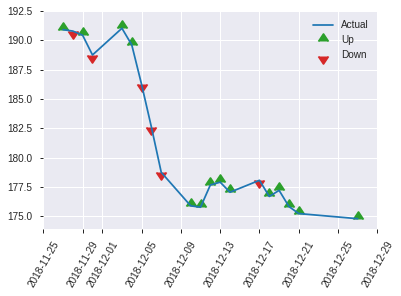


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20931181398248405
RMSE: 0.4575060808147626
LogLoss: 0.6081967594177968
Mean Per-Class Error: 0.30775213896810993
AUC: 0.7497407311381903
pr_auc: 0.7693312019895205
Gini: 0.4994814622763806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40176439050353774: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   56   0.4828   (56.0/116.0)
1      22   111  0.1654   (22.0/133.0)
Total  82   167  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401764     0.74      166
max f2                       0.105239     0.852564  247
max f0point5                 0.567734     0.720824  75
max accuracy                 0.465978     0.694779  136
max precision                0.887312     1         0
max recall                   0.105239     1         247
max specificity              0.887312     1         0
max absolute_mcc             0.576134     0.391728  67
max min_per_class_accuracy   0.47638      0.684211  126
max mean_per_class_accuracy  0.465978     0.692248  136

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.874349           1.87218   1.87218            1                0.881726  1                           0.881726            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.80906            1.87218   1.87218            1                0.862649  1                           0.874095            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.79543            1.24812   1.63816            0.666667         0.800529  0.875                       0.846508            0.0150376       0.0526316                  24.812    63.8158
    4        0.0401606                   0.790289           1.87218   1.68496            1                0.793258  0.9                         0.835858            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.784074           1.87218   1.72817            1                0.787086  0.923077                    0.824603            0.0225564       0.0902256                  87.218    72.8167
    6        0.100402                    0.687439           1.56015   1.64752            0.833333         0.741913  0.88                        0.784912            0.075188        0.165414                   56.015    64.7519
    7        0.15261                     0.628721           1.72817   1.67511            0.923077         0.660789  0.894737                    0.742449            0.0902256       0.255639                   72.8167   67.5109
    8        0.200803                    0.614954           1.40414   1.61008            0.75             0.623403  0.86                        0.713878            0.0676692       0.323308                   40.4135   61.0075
    9        0.301205                    0.569022           1.42286   1.54767            0.76             0.589436  0.826667                    0.672397            0.142857        0.466165                   42.2857   54.7669
    10       0.401606                    0.537779           0.898647  1.38541            0.48             0.550957  0.74                        0.642037            0.0902256       0.556391                   -10.1353  38.5414
    11       0.502008                    0.479978           1.12331   1.33299            0.6              0.510113  0.712                       0.615652            0.112782        0.669173                   12.3308   33.2992
    12       0.598394                    0.433366           0.93609   1.26906            0.5              0.459709  0.677852                    0.590534            0.0902256       0.759398                   -6.39098  26.9062
    13       0.698795                    0.389849           0.823759  1.20508            0.44             0.410944  0.643678                    0.564731            0.0827068       0.842105                   -17.6241  20.5082
    14       0.799197                    0.344577           0.673985  1.13836            0.36             0.364313  0.60804                     0.539553            0.0676692       0.909774                   -32.6015  13.8361
    15       0.899598                    0.25961            0.524211  1.06982            0.28             0.313656  0.571429                    0.514341            0.0526316       0.962406                   -47.5789  6.98174
    16       1                           0.0795543          0.374436  1                  0.2              0.18531   0.534137                    0.481306           

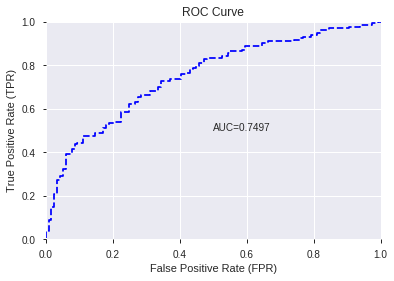

This function is available for GLM models only


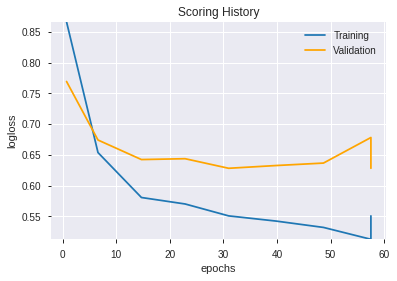

--2019-08-28 13:07:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_125553_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_125553_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'ULTOSC',
 'CDLENGULFING',
 'CORREL_8',
 'STOCHF_fastk',
 'ADOSC',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'CDLSHORTLINE',
 'DX_20',
 'aroonup_24',
 'WILLR_24',
 'CDLRICKSHAWMAN',
 'STOCHRSI_fastk',
 'AROONOSC_12',
 'OBV',
 'DX_8',
 'aroondown_30',
 'WILLR_8',
 'STOCH_slowd',
 'STDDEV_8',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'CCI_14',
 'STOCH_slowk',
 'AROONOSC_8',
 'ROC_14',
 'STOCHF_fastd',
 'aroonup_8',
 'ADX_12',
 'LINEARREG_ANGLE_8',
 'CDLSPINNINGTOP',
 'MFI_30',
 'PLUS_DM_24',
 'ADX_14',
 'aroondown_20',
 'CCI_8',
 'ATR_14',
 'BETA_8',
 'PLUS_DI_20',
 'ADX_24',
 'ADXR_14',
 'WILLR_30',
 'AROONOSC_24',
 'PLUS_DI_30',
 'ROCP_8',
 'BETA_12',
 'PLUS_DM_14',
 'ROCP_14',
 'aroondown_14',
 'aroonup_30',
 'PLUS_DM_20',
 'PLUS_DI_24',
 'ROCR100_12',
 'MINUS_DM_24',
 'MINUS_DM_8',
 'aroondown_8',
 'ROC_8',
 'RSI_14',
 'PLUS_DM_30',
 'VAR_8',
 'aroonup_20',
 'LINEARREG_SLOPE_8',
 'LINEARREG_SLOPE_12',
 'MFI_12',
 'APO',
 'MINUS_DI_12',
 'PLUS_DM_1

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_130744_model_1  0.750065  0.599684              0.359217  0.453804  0.205938

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.636782           1.000000    0.093234
1                STOCHF_fastk             0.250661           0.393637    0.036700
2                    WILLR_24             0.158417           0.248778    0.023195
3                      ULTOSC             0.145772           0.228920    0.021343
4                      MFI_30             0.125622           0.197277    0.018393
..                        ...                  ...                ...         ...
170  BBANDS_middleband_24_1_4             0.000941           0.001477    0.000138
171           MACDFIX_hist_14             0.000478           0.000750    0.000070
172  BBANDS_middleband_24_6_5             0.000337           0.000530    0.000049
173  BBANDS_middleband_14_5_5             0.000137           0.000216    0.000020
174                    EMA_20             0.000079           0.000124    0.000012

[175 rows x 4 columns]

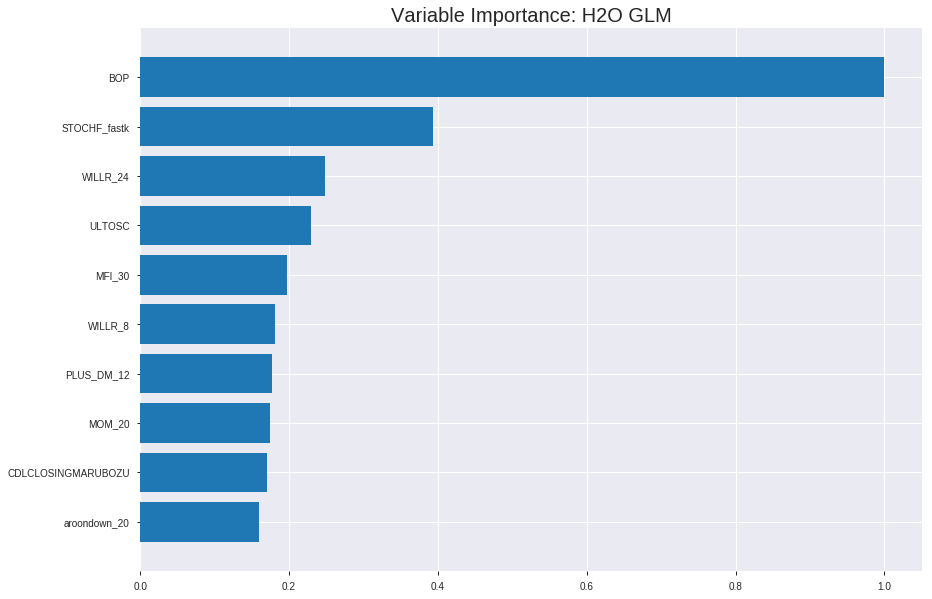

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_130744_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1944064155699985
RMSE: 0.44091542904507036
LogLoss: 0.5731030805071166
Null degrees of freedom: 1740
Residual degrees of freedom: 1565
Null deviance: 2407.4412986831494
Residual deviance: 1995.5449263257797
AIC: 2347.5449263257797
AUC: 0.7709099769837298
pr_auc: 0.770507674604807
Gini: 0.5418199539674595
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34891698020247786: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      354  465   0.5678   (465.0/819.0)
1      79   843   0.0857   (79.0/922.0)
Total  433  1308  0.3125   (544.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348917     0.756054  284
max f2                       0.269993     0.860236  321
max f0point5                 0.515305     0.72268   203
max accuracy                 0.515305     0.71166   203
max precision                0.928461     1         0
max recall                   0.07871      1         395
max specificity              0.928461     1         0
max absolute_mcc             0.515305     0.419931  203
max min_per_class_accuracy   0.549315     0.698413  183
max mean_per_class_accuracy  0.515305     0.708601  203

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.892976           1.78338   1.78338            0.944444         0.911101  0.944444                    0.911101            0.0184382       0.0184382                  78.3382   78.3382
    2        0.0201034                   0.868614           1.66614   1.72643            0.882353         0.878353  0.914286                    0.895195            0.016269        0.0347072                  66.6135   72.6433
    3        0.0304423                   0.85207            1.78338   1.74577            0.944444         0.860438  0.924528                    0.88339             0.0184382       0.0531453                  78.3382   74.5774
    4        0.0402068                   0.842213           1.66614   1.72643            0.882353         0.847598  0.914286                    0.874698            0.016269        0.0694143                  66.6135   72.6433
    5        0.0505457                   0.832081           1.46867   1.67371            0.777778         0.835902  0.886364                    0.866762            0.0151844       0.0845987                  46.8667   67.3708
    6        0.100517                    0.789447           1.60613   1.64011            0.850575         0.807605  0.868571                    0.837353            0.0802603       0.164859                   60.6129   64.0112
    7        0.150488                    0.761912           1.49761   1.59279            0.793103         0.775202  0.843511                    0.816715            0.0748373       0.239696                   49.7606   59.2791
    8        0.20046                     0.733444           1.49761   1.56906            0.793103         0.747583  0.830946                    0.799482            0.0748373       0.314534                   49.7606   56.9063
    9        0.300402                    0.675013           1.41079   1.51641            0.747126         0.704906  0.803059                    0.768017            0.140998        0.455531                   41.0789   51.6406
    10       0.400345                    0.623839           1.10693   1.41418            0.586207         0.650468  0.748924                    0.738672            0.110629        0.566161                   10.6926   41.4183
    11       0.500287                    0.558081           1.19374   1.37015            0.632184         0.59143   0.725603                    0.709257            0.119306        0.685466                   19.3744   37.0146
    12       0.60023                     0.482438           1.06352   1.31909            0.563218         0.52287   0.698565                    0.678222            0.106291        0.791757                   6.35176   31.909
    13       0.700172                    0.398957           0.792212  1.24388            0.41954          0.440219  0.658737                    0.64425             0.0791757       0.870933                   -20.7788  24.3883
    14       0.800115                    0.307864           0.672838  1.17255            0.356322         0.350916  0.620962                    0.607609            0.0672451       0.938178                   -32.7162  17.2554
    15       0.900057                    0.223859           0.368975  1.08332            0.195402         0.270988  0.573708                    0.570231            0.0368764       0.975054                   -63.1025  8.33245
    16       1                           0.0470761          0.249601  1                  0.132184         0.163495  0.529581                    0.529581          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2118794093502874
RMSE: 0.460303605623818
LogLoss: 0.6110193178771788
Null degrees of freedom: 497
Residual degrees of freedom: 322
Null deviance: 689.27761756622
Residual deviance: 608.57524060567
AIC: 960.57524060567
AUC: 0.7248734985531144
pr_auc: 0.7444868078640143
Gini: 0.4497469971062289
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2693347359227045: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      63   174  0.7342   (174.0/237.0)
1      17   244  0.0651   (17.0/261.0)
Total  80   418  0.3835   (191.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269335     0.718704  333
max f2                       0.132992     0.854058  386
max f0point5                 0.490058     0.697589  216
max accuracy                 0.490058     0.686747  216
max precision                0.904197     1         0
max recall                   0.132992     1         386
max specificity              0.904197     1         0
max absolute_mcc             0.490058     0.370855  216
max min_per_class_accuracy   0.522976     0.666667  199
max mean_per_class_accuracy  0.490058     0.684466  216

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 50.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.853492           1.90805   1.90805            1                0.872318  1                           0.872318            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.837887           1.90805   1.90805            1                0.850154  1                           0.861236            0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.808646           1.52644   1.78084            0.8              0.822398  0.933333                    0.84829             0.0153257       0.0536398                  52.6437   78.0843
    4        0.0401606                   0.801121           1.90805   1.81264            1                0.803824  0.95                        0.837173            0.0191571       0.0727969                  90.8046   81.2644
    5        0.0502008                   0.789336           1.52644   1.7554             0.8              0.796818  0.92                        0.829102            0.0153257       0.0881226                  52.6437   75.5402
    6        0.100402                    0.758271           1.67908   1.71724            0.88             0.76933   0.9                         0.799216            0.0842912       0.172414                   67.908    71.7241
    7        0.150602                    0.720872           1.29747   1.57732            0.68             0.736463  0.826667                    0.778299            0.0651341       0.237548                   29.7471   57.7318
    8        0.200803                    0.688193           1.45011   1.54552            0.76             0.702654  0.81                        0.759387            0.0727969       0.310345                   45.0115   54.5517
    9        0.301205                    0.642106           1.29747   1.46284            0.68             0.667973  0.766667                    0.728916            0.130268        0.440613                   29.7471   46.2835
    10       0.399598                    0.59558            1.12925   1.3807             0.591837         0.61899   0.723618                    0.701849            0.111111        0.551724                   12.9252   38.0697
    11       0.5                         0.525187           1.06851   1.31801            0.56             0.560818  0.690763                    0.673529            0.10728         0.659004                   6.85057   31.8008
    12       0.600402                    0.446104           1.03034   1.2699             0.54             0.488113  0.665552                    0.642523            0.103448        0.762452                   3.03448   26.9904
    13       0.698795                    0.37806            0.428337  1.15141            0.22449          0.414269  0.603448                    0.610384            0.0421456       0.804598                   -57.1663  15.1407
    14       0.799197                    0.300768           0.83954   1.11223            0.44             0.344171  0.582915                    0.57694             0.0842912       0.888889                   -16.046   11.2228
    15       0.899598                    0.213649           0.725057  1.06902            0.38             0.261771  0.560268                    0.541765            0.0727969       0.961686                   -27.4943  6.90168
    16       1                           0.053931           0.381609  1                  0.2              0.148438  0.524096                    0.502274         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:07:45  0.000 sec   2            .21E2     172           1.3591265566375965  1.3681929750927646
     2019-08-28 13:07:45  0.103 sec   4            .15E2     172           1.3531585592659652  1.3639643031956439
     2019-08-28 13:07:45  0.190 sec   6            .11E2     175           1.3460897553927764  1.3587978181425153
     2019-08-28 13:07:45  0.281 sec   8            .81E1     175           1.3377853239162918  1.3525183417434261
     2019-08-28 13:07:45  0.367 sec   10           .59E1     175           1.3281247215100689  1.3449971253737103
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:07:47  2.026 sec   46           .19E-1    176           1.1413644584633627  1.2222016859314035
     2019-08-28 13:07:47  2.130 sec   48           .14E-1    176           1.1370071504946901  1.2229107583352128
     2019-08-28 13:07:47  2.223 sec   50           .1E-1     176           1.1330395016871602  1.2241127236358509
     2019-08-28 13:07:47  2.320 sec   52           .75E-2    176           1.129385996173623   1.2258049153473498
     2019-08-28 13:07:47  2.413 sec   54           .54E-2    176           1.1259838792117964  1.2280195205211077


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7384615384615384)

('auc', 0.7500648172154525)

('logloss', 0.5996843540811944)

('mean_per_class_error', 0.2936219859994815)

('rmse', 0.45380359690543975)

('mse', 0.20593770456431484)

glm prediction progress: |████████████████████████████████████████████████| 100%


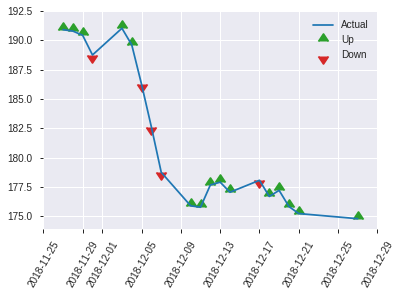


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20593770456431484
RMSE: 0.45380359690543975
LogLoss: 0.5996843540811944
Null degrees of freedom: 248
Residual degrees of freedom: 73
Null deviance: 344.04650308459236
Residual deviance: 298.64280833243475
AIC: 650.6428083324347
AUC: 0.7500648172154525
pr_auc: 0.7621445806517655
Gini: 0.500129634430905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2880194178363961: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      44   72   0.6207   (72.0/116.0)
1      13   120  0.0977   (13.0/133.0)
Total  57   192  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288019     0.738462  191
max f2                       0.216988     0.855615  215
max f0point5                 0.551225     0.733558  114
max accuracy                 0.551225     0.702811  114
max precision                0.885784     1         0
max recall                   0.128302     1         245
max specificity              0.885784     1         0
max absolute_mcc             0.551225     0.412997  114
max min_per_class_accuracy   0.514144     0.676692  124
max mean_per_class_accuracy  0.551225     0.706378  114

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 48.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.868155           1.87218   1.87218            1                0.878409  1                           0.878409            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.841769           0.93609   1.49774            0.5              0.853182  0.8                         0.868318            0.0075188       0.0300752                  -6.39098  49.7744
    3        0.0321285                   0.818352           1.87218   1.63816            1                0.830128  0.875                       0.853997            0.0225564       0.0526316                  87.218    63.8158
    4        0.0401606                   0.79124            1.87218   1.68496            1                0.8065    0.9                         0.844497            0.0150376       0.0676692                  87.218    68.4962
    5        0.0522088                   0.790022           1.24812   1.58415            0.666667         0.790666  0.846154                    0.832075            0.0150376       0.0827068                  24.812    58.4153
    6        0.100402                    0.744988           1.71617   1.64752            0.916667         0.765442  0.88                        0.800091            0.0827068       0.165414                   71.6165   64.7519
    7        0.15261                     0.70605            1.58415   1.62584            0.846154         0.724818  0.868421                    0.77434             0.0827068       0.24812                    58.4153   62.5841
    8        0.200803                    0.676109           1.56015   1.61008            0.833333         0.685803  0.86                        0.753091            0.075188        0.323308                   56.015    61.0075
    9        0.301205                    0.635934           1.34797   1.52271            0.72             0.656421  0.813333                    0.720868            0.135338        0.458647                   34.797    52.2707
    10       0.401606                    0.583916           1.12331   1.42286            0.6              0.613283  0.76                        0.693971            0.112782        0.571429                   12.3308   42.2857
    11       0.502008                    0.514144           1.04842   1.34797            0.56             0.554339  0.72                        0.666045            0.105263        0.676692                   4.84211   34.797
    12       0.598394                    0.418167           0.93609   1.28163            0.5              0.460858  0.684564                    0.632995            0.0902256       0.766917                   -6.39098  28.1627
    13       0.698795                    0.337559           0.524211  1.1728             0.28             0.379974  0.626437                    0.596641            0.0526316       0.819549                   -47.5789  17.2803
    14       0.799197                    0.261886           0.823759  1.12895            0.44             0.300506  0.603015                    0.559438            0.0827068       0.902256                   -17.6241  12.8953
    15       0.899598                    0.203185           0.673985  1.07818            0.36             0.229193  0.575893                    0.52258             0.0676692       0.969925                   -32.6015  7.81753
    16       1                           0.0724813          0.299549  1                  0.16             0.156465  0.534137                    0.485822           

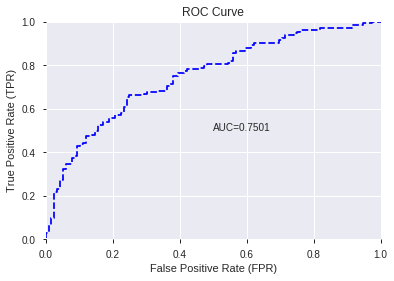

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


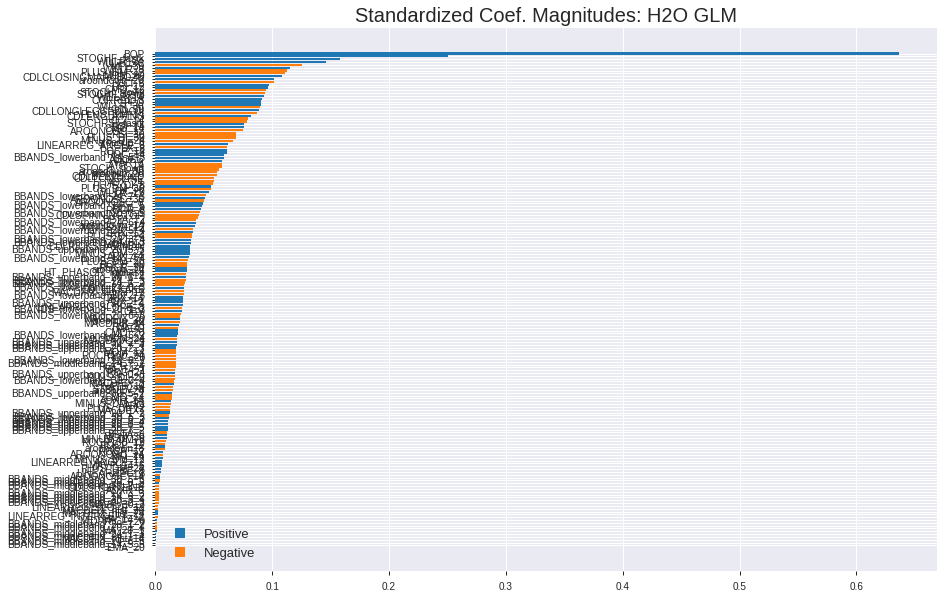

'log_likelihood'
--2019-08-28 13:07:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.112
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.112|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_130744_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_130744_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'WILLR_24',
 'ULTOSC',
 'MFI_30',
 'WILLR_8',
 'PLUS_DM_12',
 'MOM_20',
 'CDLCLOSINGMARUBOZU',
 'aroondown_20',
 'CCI_8',
 'RSI_12',
 'CMO_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'WILLR_14',
 'CORREL_8',
 'PPO',
 'WILLR_30',
 'CCI_30',
 'CDLLONGLEGGEDDOJI',
 'PLUS_DM_14',
 'CDLENGULFING',
 'CCI_14',
 'STOCHRSI_fastk',
 'RSI_14',
 'CMO_14',
 'AROONOSC_12',
 'RSI_30',
 'PLUS_DI_30',
 'MINUS_DI_24',
 'aroonup_8',
 'LINEARREG_ANGLE_8',
 'DX_8',
 'ROCP_14',
 'ROC_14',
 'BBANDS_lowerband_14_5_5',
 'ADOSC',
 'VAR_8',
 'ATR_14',
 'STOCH_slowd',
 'aroondown_30',
 'aroonup_20',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'ADX_24',
 'PLUS_DI_8',
 'PLUS_DM_30',
 'DX_20',
 'WILLR_12',
 'BBANDS_lowerband_24_7_3',
 'AROONOSC_30',
 'AROONOSC_8',
 'BBANDS_lowerband_14_7_5',
 'ROC_8',
 'ROCP_8',
 'BBANDS_lowerband_20_3_5',
 'CDLSPINNINGTOP',
 'BETA_12',
 'BBANDS_lowerband_24_6_4',
 'aroondown_14',
 'MINUS_DI_12',
 'BBANDS_lowerband_20_5_4',
 'TRIX_12',
 'PLUS_DI_24',
 'BBANDS_lowerband_20_

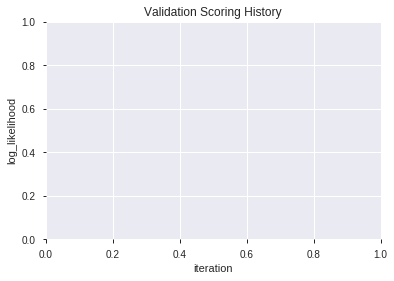

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_130805  0.736453  0.598149              0.335008  0.454658  0.206714
1  XGBoost_grid_1_AutoML_20190828_130805_model_6  0.734638  0.602780              0.331702  0.456481  0.208375
2  XGBoost_grid_1_AutoML_20190828_130805_model_5  0.731722  0.615360              0.360870  0.463242  0.214593
3  XGBoost_grid_1_AutoML_20190828_130805_model_2  0.730425  0.604139              0.344730  0.456876  0.208736
4  XGBoost_grid_1_AutoML_20190828_130805_model_4  0.729842  0.611890              0.362523  0.460687  0.212232
5               XGBoost_1_AutoML_20190828_130805  0.729583  0.610203              0.333355  0.460499  0.212059
6  XGBoost_grid_1_AutoML_20190828_130805_model_1  0.728481  0.603346              0.318771  0.456612  0.208494
7  XGBoost_grid_1_AutoML_20190828_130805_model_7  0.724138  0.608756              0.315563  0.458536  0.210256
8  XGBoost_grid_1_AutoML_20190828_130805_model_3  0.721221  0.607242              0.318220  0.458996  0.210678
9               XGBoost_2_AutoML_20190828_130805  0.719277  0.614796              0.338767  0.462703  0.214094

variable  relative_importance  scaled_importance  percentage
0                         BOP          2480.303711           1.000000    0.300894
1                STOCHF_fastk           441.669525           0.178071    0.053580
2                      ULTOSC           257.217621           0.103704    0.031204
3                  PLUS_DI_30           202.913651           0.081810    0.024616
4                     WILLR_8           171.629532           0.069197    0.020821
..                        ...                  ...                ...         ...
151   BBANDS_lowerband_14_6_2             2.074835           0.000837    0.000252
152   BBANDS_lowerband_20_1_3             1.790734           0.000722    0.000217
153  BBANDS_middleband_20_0_5             1.731209           0.000698    0.000210
154   BBANDS_lowerband_20_6_3             1.277954           0.000515    0.000155
155  BBANDS_middleband_14_6_2             0.175579           0.000071    0.000021

[156 rows x 4 columns]

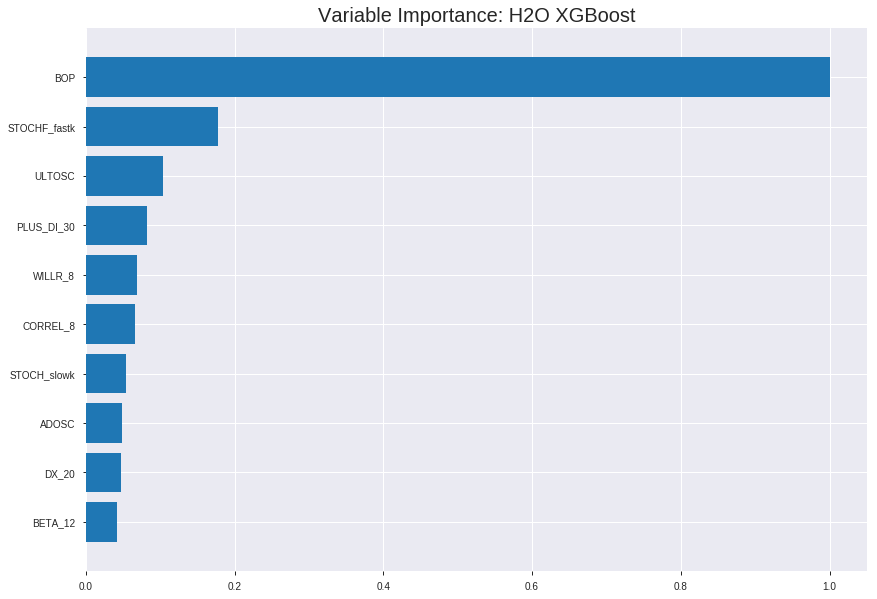

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_130805


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1378101707663234
RMSE: 0.37122792293458123
LogLoss: 0.4444187319249081
Mean Per-Class Error: 0.16442132223043282
AUC: 0.9170818335677339
pr_auc: 0.9251102453475584
Gini: 0.8341636671354677
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.550507378578186: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      690  129  0.1575   (129.0/819.0)
1      161  761  0.1746   (161.0/922.0)
Total  851  890  0.1666   (290.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.550507     0.839956  187
max f2                       0.330165     0.909729  292
max f0point5                 0.617057     0.86703   155
max accuracy                 0.563374     0.834003  181
max precision                0.907667     1         0
max recall                   0.220385     1         344
max specificity              0.907667     1         0
max absolute_mcc             0.583304     0.671715  171
max min_per_class_accuracy   0.547334     0.828633  189
max mean_per_class_accuracy  0.583304     0.835579  171

Gains/Lift Table: Avg response rate: 52.96 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.883985           1.88829    1.88829            1                0.892511  1                           0.892511            0.0195228       0.0195228                  88.8286   88.8286
    2        0.0201034                   0.87243            1.88829    1.88829            1                0.877394  1                           0.885168            0.0184382       0.037961                   88.8286   88.8286
    3        0.0304423                   0.86766            1.88829    1.88829            1                0.869933  1                           0.879994            0.0195228       0.0574837                  88.8286   88.8286
    4        0.0402068                   0.859635           1.88829    1.88829            1                0.863328  1                           0.875947            0.0184382       0.0759219                  88.8286   88.8286
    5        0.0505457                   0.849292           1.88829    1.88829            1                0.854038  1                           0.871465            0.0195228       0.0954447                  88.8286   88.8286
    6        0.100517                    0.809602           1.88829    1.88829            1                0.829823  1                           0.850763            0.0943601       0.189805                   88.8286   88.8286
    7        0.150488                    0.775075           1.80147    1.85946            0.954023         0.789806  0.984733                    0.830522            0.0900217       0.279826                   80.1469   85.9458
    8        0.20046                     0.745242           1.75806    1.83418            0.931034         0.760028  0.971347                    0.812949            0.0878525       0.367679                   75.806    83.4181
    9        0.300402                    0.686597           1.73636    1.80163            0.91954          0.716652  0.954111                    0.780911            0.173536        0.541215                   73.6355   80.1635
    10       0.400345                    0.62933            1.56272    1.74199            0.827586         0.656134  0.922525                    0.749762            0.156182        0.697397                   56.272    74.1992
    11       0.500287                    0.561417           1.17204    1.62813            0.62069          0.594289  0.862227                    0.718703            0.117137        0.814534                   17.204    62.8132
    12       0.60023                     0.487235           0.716247   1.4763             0.37931          0.522086  0.781818                    0.685965            0.0715835       0.886117                   -28.3753  47.6297
    13       0.700172                    0.380688           0.759655   1.374              0.402299         0.439597  0.727646                    0.650798            0.0759219       0.962039                   -24.0345  37.4003
    14       0.800115                    0.265256           0.303862   1.24033            0.16092          0.32313   0.656856                    0.609869            0.0303688       0.992408                   -69.6138  24.0332
    15       0.900057                    0.196978           0.0759655  1.11104            0.0402299        0.228381  0.588385                    0.567509            0.00759219      1                          -92.4034  11.104
    16       1                           0.0867051          0          1                  0                0.161921  0.529581                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21427937211154022
RMSE: 0.4629031995045403
LogLoss: 0.6187263116023551
Mean Per-Class Error: 0.3179591638779766
AUC: 0.7228527086667637
pr_auc: 0.740634502565877
Gini: 0.4457054173335273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4360039532184601: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  113  0.4768   (113.0/237.0)
1      49   212  0.1877   (49.0/261.0)
Total  173  325  0.3253   (162.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436004     0.723549  254
max f2                       0.153229     0.849673  388
max f0point5                 0.597902     0.703606  163
max accuracy                 0.597902     0.678715  163
max precision                0.891318     1         0
max recall                   0.134434     1         393
max specificity              0.891318     1         0
max absolute_mcc             0.597902     0.366327  163
max min_per_class_accuracy   0.569503     0.662835  189
max mean_per_class_accuracy  0.597902     0.682041  163

Gains/Lift Table: Avg response rate: 52.41 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.87238            1.90805   1.90805            1                0.883338  1                           0.883338            0.0191571       0.0191571                  90.8046   90.8046
    2        0.0200803                   0.862526           1.90805   1.90805            1                0.867946  1                           0.875642            0.0191571       0.0383142                  90.8046   90.8046
    3        0.0301205                   0.85001            1.90805   1.90805            1                0.855808  1                           0.869031            0.0191571       0.0574713                  90.8046   90.8046
    4        0.0401606                   0.83943            1.52644   1.81264            0.8              0.848545  0.95                        0.863909            0.0153257       0.0727969                  52.6437   81.2644
    5        0.0502008                   0.820972           1.14483   1.67908            0.6              0.830439  0.88                        0.857215            0.0114943       0.0842912                  14.4828   67.908
    6        0.100402                    0.777572           1.45011   1.5646             0.76             0.801878  0.82                        0.829546            0.0727969       0.157088                   45.0115   56.4598
    7        0.150602                    0.735776           1.60276   1.57732            0.84             0.75552   0.826667                    0.804871            0.0804598       0.237548                   60.2759   57.7318
    8        0.200803                    0.695674           1.45011   1.54552            0.76             0.714402  0.81                        0.782254            0.0727969       0.310345                   45.0115   54.5517
    9        0.301205                    0.652225           1.29747   1.46284            0.68             0.673105  0.766667                    0.745871            0.130268        0.440613                   29.7471   46.2835
    10       0.399598                    0.618094           1.09031   1.37111            0.571429         0.633964  0.718593                    0.718316            0.10728         0.547893                   9.0312    37.1108
    11       0.5                         0.572119           1.06851   1.31034            0.56             0.593999  0.686747                    0.693353            0.10728         0.655172                   6.85057   31.0345
    12       0.600402                    0.506509           1.03034   1.26352            0.54             0.541865  0.662207                    0.66802             0.103448        0.758621                   3.03448   26.3522
    13       0.698795                    0.368865           0.739855  1.18979            0.387755         0.441567  0.623563                    0.636135            0.0727969       0.831418                   -26.0145  18.9787
    14       0.799197                    0.246601           0.610575  1.11702            0.32             0.292257  0.585427                    0.592934            0.0613027       0.89272                    -38.9425  11.7022
    15       0.899598                    0.196706           0.496092  1.04772            0.26             0.221535  0.549107                    0.551483            0.0498084       0.942529                   -50.3908  4.77217
    16       1                           0.119063           0.572414  1                  0.3              0.167465  0.524096                    0.512927          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:08:09  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.470419                         0.5                0.693147              0.5               0                    1                  0.475904
    2019-08-28 13:08:10  0.262 sec   5                  0.472879         0.64008             0.840536        0.84816            1.80619          0.270534                         0.484289           0.66207               0.718181          0.716697             1.52644            0.331325
    2019-08-28 13:08:10  0.342 sec   10                 0.451083         0.598397            0.855923        0.862292           1.88829          0.25158                          0.474633           0.64291               0.714753          0.724959             1.69604            0.361446
    2019-08-28 13:08:10  0.422 sec   15                 0.435715         0.568941            0.86417         0.873449           1.88829          0.255026                         0.468845           0.631173              0.718698          0.731196             1.90805            0.337349
    2019-08-28 13:08:10  0.507 sec   20                 0.423193         0.544825            0.872767        0.881426           1.88829          0.24641                          0.466442           0.625893              0.716637          0.731682             1.90805            0.339357
    2019-08-28 13:08:10  0.627 sec   25                 0.411886         0.522811            0.879056        0.88701            1.88829          0.238943                         0.465207           0.623048              0.713428          0.729618             1.90805            0.337349
    2019-08-28 13:08:10  0.727 sec   30                 0.403451         0.506145            0.885509        0.891553           1.88829          0.198736                         0.464818           0.6221                0.713985          0.7322               1.90805            0.333333
    2019-08-28 13:08:10  0.836 sec   35                 0.395408         0.490304            0.891983        0.900378           1.88829          0.19529                          0.464502           0.621537              0.715303          0.733865             1.90805            0.333333
    2019-08-28 13:08:10  0.958 sec   40                 0.389275         0.478441            0.897855        0.906584           1.88829          0.186674                         0.464279           0.62101               0.716338          0.735406             1.90805            0.343373
    2019-08-28 13:08:10  1.046 sec   45                 0.382867         0.466002            0.904119        0.912792           1.88829          0.179207                         0.463584           0.619985              0.718949          0.736523             1.90805            0.329317
    2019-08-28 13:08:11  1.141 sec   50                 0.376154         0.453556            0.912242        0.920395           1.88829          0.170017                         0.462808           0.61847               0.721648          0.739613             1.90805            0.329317
    2019-08-28 13:08:11  1.231 sec   55                 0.371228         0.444419            0.917082        0.92511            1.88829          0.166571                         0.462903           0.618726              0.722853          0

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       2480.3037109375        1.0                    0.30089399767501035
STOCHF_fastk              441.6695251464844      0.17807074319118082    0.053580417787754527
ULTOSC                    257.2176208496094      0.10370408257478549    0.031203935981146583
PLUS_DI_30                202.9136505126953      0.08181000158081383    0.02461613842544999
WILLR_8                   171.62953186035156     0.0691969822500001     0.02082095661624926
---                       ---                    ---                    ---
BBANDS_lowerband_14_6_2   2.0748348236083984     0.0008365245007935567  0.0002517052011968656
BBANDS_lowerband_20_1_3   1.7907342910766602     0.0007219818618098999  0.00021724000864882767
BBANDS_middleband_20_0_5  1.7312090396881104     0.0006979826833520124  0.00021001879990171788
BBANDS_lowerband_20_6_3   1.2779536247253418     0.000515240782445269   0.00015503285879515726
BBANDS_middleband_14_6_2  0.17557907104492188    7.078934336575937e-05  2.130008851811231e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6867469879518072)

('F1', 0.756923076923077)

('auc', 0.7364532019704434)

('logloss', 0.5981494213340757)

('mean_per_class_error', 0.3206831734508686)

('rmse', 0.4546579476871057)

('mse', 0.20671384939505097)

xgboost prediction progress: |████████████████████████████████████████████| 100%


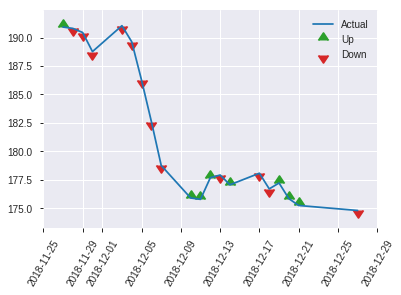


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20671384939505097
RMSE: 0.4546579476871057
LogLoss: 0.5981494213340757
Mean Per-Class Error: 0.3206831734508686
AUC: 0.7364532019704434
pr_auc: 0.7481251913902746
Gini: 0.4729064039408868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2674178183078766: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   69   0.5948   (69.0/116.0)
1      10   123  0.0752   (10.0/133.0)
Total  57   192  0.3173   (79.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267418     0.756923  191
max f2                       0.221298     0.867209  205
max f0point5                 0.526243     0.699856  139
max accuracy                 0.344055     0.686747  176
max precision                0.891473     1         0
max recall                   0.142114     1         245
max specificity              0.891473     1         0
max absolute_mcc             0.267418     0.391796  191
max min_per_class_accuracy   0.539718     0.672414  127
max mean_per_class_accuracy  0.526243     0.679317  139

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.871336           1.87218   1.87218            1                0.882542  1                           0.882542            0.0225564       0.0225564                  87.218    87.218
    2        0.0200803                   0.860057           1.87218   1.87218            1                0.866348  1                           0.876064            0.0150376       0.037594                   87.218    87.218
    3        0.0321285                   0.851447           1.87218   1.87218            1                0.855564  1                           0.868377            0.0225564       0.0601504                  87.218    87.218
    4        0.0401606                   0.848454           1.87218   1.87218            1                0.848952  1                           0.864492            0.0150376       0.075188                   87.218    87.218
    5        0.0522088                   0.839257           1.24812   1.72817            0.666667         0.843213  0.923077                    0.859581            0.0150376       0.0902256                  24.812    72.8167
    6        0.100402                    0.758489           1.71617   1.72241            0.916667         0.807994  0.92                        0.834819            0.0827068       0.172932                   71.6165   72.2406
    7        0.15261                     0.715457           1.29612   1.57657            0.692308         0.736306  0.842105                    0.801117            0.0676692       0.240602                   29.6125   57.6573
    8        0.200803                    0.689758           1.09211   1.4603             0.583333         0.705501  0.78                        0.778169            0.0526316       0.293233                   9.21053   46.0301
    9        0.301205                    0.642819           1.34797   1.42286            0.72             0.663095  0.76                        0.739811            0.135338        0.428571                   34.797    42.2857
    10       0.401606                    0.604658           1.04842   1.32925            0.56             0.624009  0.71                        0.710861            0.105263        0.533835                   4.84211   32.9248
    11       0.502008                    0.54966            1.1982    1.30304            0.64             0.578952  0.696                       0.684479            0.120301        0.654135                   19.8195   30.3038
    12       0.598394                    0.499649           1.0141    1.2565             0.541667         0.52506   0.671141                    0.658801            0.0977444       0.75188                    1.40977   25.6497
    13       0.698795                    0.350272           0.973534  1.21584            0.52             0.419864  0.649425                    0.624471            0.0977444       0.849624                   -2.64662  21.5841
    14       0.799197                    0.253308           0.898647  1.17599            0.48             0.293742  0.628141                    0.582922            0.0902256       0.93985                    -10.1353  17.5993
    15       0.899598                    0.181929           0.299549  1.07818            0.16             0.213167  0.575893                    0.541655            0.0300752       0.969925                   -70.0451  7.81753
    16       1                           0.13437            0.299549  1                  0.16             0.158246  0.534137                    0.50316             0

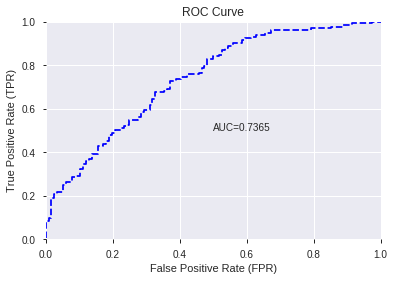

This function is available for GLM models only


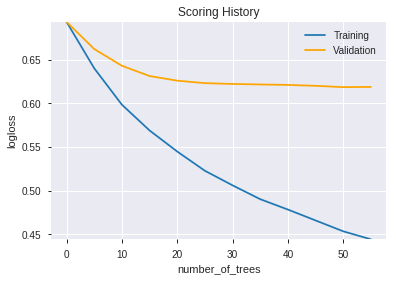

--2019-08-28 13:08:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_130805',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_130805',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a718',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a718',
   'ty

['BOP',
 'STOCHF_fastk',
 'ULTOSC',
 'PLUS_DI_30',
 'WILLR_8',
 'CORREL_8',
 'STOCH_slowk',
 'ADOSC',
 'DX_20',
 'BETA_12',
 'aroonup_8',
 'PLUS_DM_30',
 'CCI_8',
 'BETA_8',
 'MACDFIX_hist_20',
 'OBV',
 'STOCHRSI_fastk',
 'ROC_20',
 'ADXR_14',
 'ADX_14',
 'NATR_14',
 'STOCHF_fastd',
 'PLUS_DI_8',
 'HT_PHASOR_inphase',
 'AROONOSC_12',
 'MOM_20',
 'ROC_14',
 'ADXR_8',
 'WILLR_12',
 'ATR_14',
 'ADX_24',
 'TRIX_12',
 'TRIX_14',
 'DX_8',
 'WILLR_14',
 'MFI_14',
 'MINUS_DM_24',
 'LINEARREG_ANGLE_8',
 'CDLCLOSINGMARUBOZU',
 'MACDFIX_8',
 'CCI_14',
 'PLUS_DI_20',
 'ROCP_12',
 'MACDFIX_hist_24',
 'MACDFIX_signal_12',
 'aroondown_8',
 'PLUS_DM_20',
 'aroonup_14',
 'MOM_24',
 'PLUS_DM_12',
 'STOCH_slowd',
 'AROONOSC_14',
 'AROONOSC_24',
 'MOM_12',
 'ROCP_30',
 'MACDFIX_hist_14',
 'CDLLONGLINE',
 'PLUS_DI_24',
 'PLUS_DI_12',
 'BBANDS_upperband_14_6_2',
 'MFI_30',
 'CMO_12',
 'VAR_8',
 'MFI_12',
 'MOM_30',
 'CMO_20',
 'ADX_12',
 'MINUS_DI_24',
 'CDLSHORTLINE',
 'APO',
 'aroondown_20',
 'BBANDS_uppe

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.723
GLM             0.703
XGBoost         0.703
dtype: float64

DeepLearning    GLM  XGBoost
All          0.562  0.534    0.699
DLF          0.703  0.695    0.687
Fwe          0.723  0.703    0.703
RFE          0.695  0.703    0.687
XGBF         0.711  0.695    0.687





F1


DeepLearning    0.768
GLM             0.743
XGBoost         0.757
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.696    0.747
DLF          0.750  0.739    0.746
Fwe          0.768  0.743    0.745
RFE          0.740  0.738    0.757
XGBF         0.752  0.739    0.746





auc


DeepLearning    0.750
GLM             0.750
XGBoost         0.747
dtype: float64

DeepLearning    GLM  XGBoost
All          0.526  0.487    0.747
DLF          0.734  0.731    0.733
Fwe          0.748  0.740    0.732
RFE          0.750  0.750    0.736
XGBF         0.733  0.731    0.733





logloss


DeepLearning    14.145
GLM             17.234
XGBoost          0.609
dtype: float64

DeepLearning     GLM  XGBoost
All         14.145  17.234    0.600
DLF          0.613   0.611    0.605
Fwe          0.599   0.602    0.609
RFE          0.608   0.600    0.598
XGBF         0.598   0.611    0.605





mean_per_class_error


DeepLearning    0.467
GLM             0.492
XGBoost         0.321
dtype: float64

DeepLearning    GLM  XGBoost
All          0.467  0.492    0.297
DLF          0.301  0.307    0.320
Fwe          0.287  0.305    0.305
RFE          0.308  0.294    0.321
XGBF         0.296  0.307    0.320





rmse


DeepLearning    0.665
GLM             0.723
XGBoost         0.458
dtype: float64

DeepLearning    GLM  XGBoost
All          0.665  0.723    0.455
DLF          0.460  0.459    0.458
Fwe          0.450  0.456    0.458
RFE          0.458  0.454    0.455
XGBF         0.453  0.459    0.458





mse


DeepLearning    0.443
GLM             0.523
XGBoost         0.210
dtype: float64

DeepLearning    GLM  XGBoost
All          0.443  0.523    0.207
DLF          0.211  0.211    0.209
Fwe          0.202  0.208    0.210
RFE          0.209  0.206    0.207
XGBF         0.205  0.211    0.209

{'F1':       DeepLearning    GLM  XGBoost
 All          0.700    NaN      NaN
 DLF          0.750    NaN      NaN
 DLF            NaN  0.739      NaN
 DLF            NaN    NaN    0.746
 All            NaN  0.696      NaN
 All            NaN    NaN    0.747
 XGBF         0.752    NaN      NaN
 XGBF           NaN  0.739      NaN
 XGBF           NaN    NaN    0.746
 Fwe          0.768    NaN      NaN
 Fwe            NaN  0.743      NaN
 Fwe            NaN    NaN    0.745
 RFE          0.740    NaN      NaN
 RFE            NaN  0.738      NaN
 RFE            NaN    NaN    0.757,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.562    NaN      NaN
 DLF          0.703    NaN      NaN
 DLF            NaN  0.695      NaN
 DLF            NaN    NaN    0.687
 All            NaN  0.534      NaN
 All            NaN    NaN    0.699
 XGBF         0.711    NaN      NaN
 XGBF           NaN  0.695      NaN
 XGBF           NaN    NaN    0.687
 Fwe          0.723    NaN      NaN
 Fwe     